In [1]:
# Includes
# os
import os
from time import sleep
import datetime
from datetime import timezone

# websockets and connectivity
from binance.websockets import BinanceSocketManager
from twisted.internet import reactor

# interactive shell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# binance
from binance.client import Client
import binance.helpers as btime

# pandas
import pandas as pd
from pandas import DataFrame as df
pd.set_option("display.max_rows", 100, "display.max_columns", None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)


# numpy
import numpy as np

# plotting
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sb
from mpl_toolkits.mplot3d import Axes3D
from statsmodels.graphics import tsaplots


# data science utils
from scipy import stats
from scipy import fft
from scipy import signal
import statsmodels.api as sm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pingouin as pg

import warnings
warnings.filterwarnings("ignore")


In [2]:
# Load api login data

# open api login file
apifile = open("apilogin.txt", "r");
apilogin = (str(apifile.read()).split("\n"));

# extract key
apikey = apilogin[0].split(":")[1];
# extract secret
apisecret = apilogin[1].split(":")[1];

# check values
"key: " + apikey;
"secret: " + apisecret;

client=Client(api_key=apikey,api_secret=apisecret);

In [3]:
# define trade pair
base_asset = 'ETH'
quote_asset = 'BTC'
trade_pair = base_asset+quote_asset

# define request interval
time_interval = Client.KLINE_INTERVAL_1MINUTE

# define initial start as utc timestamp
start_time = btime.date_to_milliseconds('Dec 1, 2020')

# request initial historical data
candles = client.get_historical_klines(symbol=trade_pair,interval=time_interval, start_str=start_time,limit=1000)


In [4]:
len(candles)
# Verify the last known data point is today
end_unix_timestamp = candles[-1][0]/1000
datetime.datetime.fromtimestamp(end_unix_timestamp)

577112

datetime.datetime(2022, 1, 6, 10, 54)

In [5]:
# Dynamically name headers
kline_headers = ['Open Time UTC', 
    'Open ' + quote_asset, 
    'High ' + quote_asset, 
    'Low ' + quote_asset, 
    'Close ' + quote_asset, 
    'Volume ' + base_asset, 
    'Close Time UTC', 
    'Volume ' + quote_asset, 
    'Number of Trades',
    'Taker Buy Volume ' + base_asset,
    'Taker Buy Volume ' + quote_asset]
# kline_headers

In [6]:
# Create key-value pairs for each column and associated numpy dtype
typedict = {
    kline_headers[0]: np.uint64,
    kline_headers[1]: np.float32,
    kline_headers[2]: np.float32,
    kline_headers[3]: np.float32,
    kline_headers[4]: np.float32,
    kline_headers[5]: np.float32,
    kline_headers[6]: np.uint64,
    kline_headers[7]: np.float32,
    kline_headers[8]: np.float32,
    kline_headers[9]: np.float32,
    kline_headers[10]: np.float32,
}

# Instantiate klines dataframe and assign dtypes via dictionary
klines = df(data=[entry[:-1] for entry in candles], columns=kline_headers).astype(typedict)

# Sort klines dataframe by ascending UTC open
klines.sort_values(by=['Open Time UTC'], ascending=True, inplace=True)

# Assign open UTC as index
klines.index = klines['Open Time UTC']

print('Kline data types:')
klines.dtypes

# klines.head()

Kline data types:


Open Time UTC            uint64
Open BTC                float32
High BTC                float32
Low BTC                 float32
Close BTC               float32
Volume ETH              float32
Close Time UTC           uint64
Volume BTC              float32
Number of Trades        float32
Taker Buy Volume ETH    float32
Taker Buy Volume BTC    float32
dtype: object

In [7]:
# calculate close-open differences for each period
klines['Difference ' + quote_asset] = klines['Close ' + quote_asset]-klines['Open ' + quote_asset]
klines['Percent Change ' + quote_asset] = 100 * klines['Difference ' + quote_asset] / klines['Open ' + quote_asset]
klines.head()

Open Time UTC  Open BTC  High BTC  Low BTC  Close BTC  \
Open Time UTC                                                          
1606780800000  1606780800000   0.03131   0.03132  0.03125    0.03125   
1606780860000  1606780860000   0.03125   0.03130  0.03125    0.03127   
1606780920000  1606780920000   0.03126   0.03134  0.03126    0.03133   
1606780980000  1606780980000   0.03133   0.03137  0.03132    0.03137   
1606781040000  1606781040000   0.03137   0.03140  0.03134    0.03137   

               Volume ETH  Close Time UTC  Volume BTC  Number of Trades  \
Open Time UTC                                                             
1606780800000   332.94400   1606780859999    10.41869         285.00000   
1606780860000   347.59900   1606780919999    10.87070         246.00000   
1606780920000   348.82599   1606780979999    10.92332         232.00000   
1606780980000   377.57199   1606781039999    11.83920         302.00000   
1606781040000   689.13098   1606781099999    21.61878         317.00000   

               Taker Buy Volume ETH  Taker Buy Volume BTC  Difference BTC  \
Open Time UTC                                                               
1606780800000             120.16900               3.76137        -0.00006   
1606780860000             169.12000               5.28886         0.00002   
1606780920000             252.61099               7.91123         0.00007   
1606780980000             284.16000               8.91018         0.00004   
1606781040000             462.52200              14.50975        -0.00000   

               Percent Change BTC  
Open Time UTC                      
1606780800000            -0.20121  
1606780860000             0.06081  
1606780920000             0.23030  
1606780980000             0.12127  
1606781040000            -0.01274

In [8]:
# create Maker-Taker ratio
klines['Maker-Taker Volume ' + quote_asset + ' Ratio'] = ((klines['Volume ' + quote_asset] - klines['Taker Buy Volume ' + quote_asset]) / klines['Volume ' + quote_asset])

# create generic Ratios
klines['Price-Volume ' + quote_asset + ' Ratio'] = klines['Open ' + quote_asset] / klines['Volume ' + quote_asset]
klines['Trade-Volume ' + quote_asset + ' Ratio'] = klines['Number of Trades']/klines['Volume ' + quote_asset]
klines['Price-Taker Buy Volume ' + quote_asset + ' Ratio'] = klines['Open ' + quote_asset] / klines['Taker Buy Volume ' + quote_asset]
klines['Trade-Taker Buy Volume ' + quote_asset + ' Ratio'] = klines['Number of Trades']/klines['Taker Buy Volume ' + quote_asset]

In [9]:
# Differentials lagged by 1 timestep
# so that all diff columns are predictors

klines_diff_1 = klines.diff(axis='index',periods=1).shift(1)
klines_diff_1.columns = ['DIFF 1 ' + colname for colname in klines.columns]
klines_diff_1.drop(columns=[klines_diff_1.columns[0], klines_diff_1.columns[6]], inplace=True)

klines_diff_2 = klines.diff(axis='index',periods=2).shift(1)
klines_diff_2.columns = ['DIFF 2 ' + colname for colname in klines.columns]
klines_diff_2.drop(columns=[klines_diff_2.columns[0], klines_diff_2.columns[6]], inplace=True)

klines_diff_3 = klines.diff(axis='index',periods=3).shift(1)
klines_diff_3.columns = ['DIFF 3 ' + colname for colname in klines.columns]
klines_diff_3.drop(columns=[klines_diff_3.columns[0], klines_diff_3.columns[6]], inplace=True)


In [10]:
klines = klines.join(klines_diff_1,how='inner').join(klines_diff_2,how='inner').join(klines_diff_3,how='inner')
klines.head()

Open Time UTC  Open BTC  High BTC  Low BTC  Close BTC  \
Open Time UTC                                                          
1606780800000  1606780800000   0.03131   0.03132  0.03125    0.03125   
1606780860000  1606780860000   0.03125   0.03130  0.03125    0.03127   
1606780920000  1606780920000   0.03126   0.03134  0.03126    0.03133   
1606780980000  1606780980000   0.03133   0.03137  0.03132    0.03137   
1606781040000  1606781040000   0.03137   0.03140  0.03134    0.03137   

               Volume ETH  Close Time UTC  Volume BTC  Number of Trades  \
Open Time UTC                                                             
1606780800000   332.94400   1606780859999    10.41869         285.00000   
1606780860000   347.59900   1606780919999    10.87070         246.00000   
1606780920000   348.82599   1606780979999    10.92332         232.00000   
1606780980000   377.57199   1606781039999    11.83920         302.00000   
1606781040000   689.13098   1606781099999    21.61878         317.00000   

               Taker Buy Volume ETH  Taker Buy Volume BTC  Difference BTC  \
Open Time UTC                                                               
1606780800000             120.16900               3.76137        -0.00006   
1606780860000             169.12000               5.28886         0.00002   
1606780920000             252.61099               7.91123         0.00007   
1606780980000             284.16000               8.91018         0.00004   
1606781040000             462.52200              14.50975        -0.00000   

               Percent Change BTC  Maker-Taker Volume BTC Ratio  \
Open Time UTC                                                     
1606780800000            -0.20121                       0.63898   
1606780860000             0.06081                       0.51348   
1606780920000             0.23030                       0.27575   
1606780980000             0.12127                       0.24740   
1606781040000            -0.01274                       0.32884   

               Price-Volume BTC Ratio  Trade-Volume BTC Ratio  \
Open Time UTC                                                   
1606780800000                 0.00301                27.35468   
1606780860000                 0.00287                22.62963   
1606780920000                 0.00286                21.23897   
1606780980000                 0.00265                25.50847   
1606781040000                 0.00145                14.66317   

               Price-Taker Buy Volume BTC Ratio  \
Open Time UTC                                     
1606780800000                           0.00832   
1606780860000                           0.00591   
1606780920000                           0.00395   
1606780980000                           0.00352   
1606781040000                           0.00216   

               Trade-Taker Buy Volume BTC Ratio  DIFF 1 Open BTC  \
Open Time UTC                                                      
1606780800000                          75.77024              NaN   
1606780860000                          46.51286              NaN   
1606780920000                          29.32539         -0.00006   
1606780980000                          33.89380          0.00002   
1606781040000                          21.84738          0.00007   

               DIFF 1 High BTC  DIFF 1 Low BTC  DIFF 1 Close BTC  \
Open Time UTC                                                      
1606780800000              NaN             NaN               NaN   
1606780860000              NaN             NaN               NaN   
1606780920000         -0.00002         0.00000           0.00002   
1606780980000          0.00004         0.00001           0.00007   
1606781040000          0.00003         0.00006           0.00004   

               DIFF 1 Volume ETH  DIFF 1 Volume BTC  DIFF 1 Number of Trades  \
Open Time UTC                                                                  
1606780800000                NaN              

In [11]:
# Verify no NaNs except in first three rows, then remove them in place
klines[klines.isna().any(axis=1)].head()
klines[klines.isna().any(axis=1)].shape
klines.drop(axis='index', labels=klines[klines.isna().any(axis=1)]['Open Time UTC'].values.tolist(),inplace=True)
klines.head()

Open Time UTC  Open BTC  High BTC  Low BTC  Close BTC  \
Open Time UTC                                                          
1606780800000  1606780800000   0.03131   0.03132  0.03125    0.03125   
1606780860000  1606780860000   0.03125   0.03130  0.03125    0.03127   
1606780920000  1606780920000   0.03126   0.03134  0.03126    0.03133   
1606780980000  1606780980000   0.03133   0.03137  0.03132    0.03137   
1608556800000  1608556800000   0.02686   0.02686  0.02686    0.02686   

               Volume ETH  Close Time UTC  Volume BTC  Number of Trades  \
Open Time UTC                                                             
1606780800000   332.94400   1606780859999    10.41869         285.00000   
1606780860000   347.59900   1606780919999    10.87070         246.00000   
1606780920000   348.82599   1606780979999    10.92332         232.00000   
1606780980000   377.57199   1606781039999    11.83920         302.00000   
1608556800000     0.00000   1608556859999     0.00000           0.00000   

               Taker Buy Volume ETH  Taker Buy Volume BTC  Difference BTC  \
Open Time UTC                                                               
1606780800000             120.16900               3.76137        -0.00006   
1606780860000             169.12000               5.28886         0.00002   
1606780920000             252.61099               7.91123         0.00007   
1606780980000             284.16000               8.91018         0.00004   
1608556800000               0.00000               0.00000         0.00000   

               Percent Change BTC  Maker-Taker Volume BTC Ratio  \
Open Time UTC                                                     
1606780800000            -0.20121                       0.63898   
1606780860000             0.06081                       0.51348   
1606780920000             0.23030                       0.27575   
1606780980000             0.12127                       0.24740   
1608556800000             0.00000                           NaN   

               Price-Volume BTC Ratio  Trade-Volume BTC Ratio  \
Open Time UTC                                                   
1606780800000                 0.00301                27.35468   
1606780860000                 0.00287                22.62963   
1606780920000                 0.00286                21.23897   
1606780980000                 0.00265                25.50847   
1608556800000                     inf                     NaN   

               Price-Taker Buy Volume BTC Ratio  \
Open Time UTC                                     
1606780800000                           0.00832   
1606780860000                           0.00591   
1606780920000                           0.00395   
1606780980000                           0.00352   
1608556800000                               inf   

               Trade-Taker Buy Volume BTC Ratio  DIFF 1 Open BTC  \
Open Time UTC                                                      
1606780800000                          75.77024              NaN   
1606780860000                          46.51286              NaN   
1606780920000                          29.32539         -0.00006   
1606780980000                          33.89380          0.00002   
1608556800000                               NaN         -0.00002   

               DIFF 1 High BTC  DIFF 1 Low BTC  DIFF 1 Close BTC  \
Open Time UTC                                                      
1606780800000              NaN             NaN               NaN   
1606780860000              NaN             NaN               NaN   
1606780920000         -0.00002         0.00000           0.00002   
1606780980000          0.00004         0.00001           0.00007   
1608556800000         -0.00002        -0.00000           0.00002   

               DIFF 1 Volume ETH  DIFF 1 Volume BTC  DIFF 1 Number of Trades  \
Open Time UTC                                                                  
1606780800000                NaN              

(164, 66)

Open Time UTC  Open BTC  High BTC  Low BTC  Close BTC  \
Open Time UTC                                                          
1606781040000  1606781040000   0.03137   0.03140  0.03134    0.03137   
1606781100000  1606781100000   0.03137   0.03141  0.03137    0.03141   
1606781160000  1606781160000   0.03140   0.03143  0.03138    0.03139   
1606781220000  1606781220000   0.03138   0.03138  0.03132    0.03132   
1606781280000  1606781280000   0.03132   0.03134  0.03132    0.03134   

               Volume ETH  Close Time UTC  Volume BTC  Number of Trades  \
Open Time UTC                                                             
1606781040000   689.13098   1606781099999    21.61878         317.00000   
1606781100000   372.71799   1606781159999    11.69953         225.00000   
1606781160000   670.04700   1606781219999    21.04978         380.00000   
1606781220000   242.86301   1606781279999     7.61350         177.00000   
1606781280000   120.73700   1606781339999     3.78288         106.00000   

               Taker Buy Volume ETH  Taker Buy Volume BTC  Difference BTC  \
Open Time UTC                                                               
1606781040000             462.52200              14.50975        -0.00000   
1606781100000             222.20799               6.97532         0.00004   
1606781160000             149.05800               4.68179        -0.00002   
1606781220000              93.79800               2.94024        -0.00006   
1606781280000              59.62500               1.86821         0.00002   

               Percent Change BTC  Maker-Taker Volume BTC Ratio  \
Open Time UTC                                                     
1606781040000            -0.01274                       0.32884   
1606781100000             0.13071                       0.40380   
1606781160000            -0.06368                       0.77758   
1606781220000            -0.19118                       0.61381   
1606781280000             0.06386                       0.50614   

               Price-Volume BTC Ratio  Trade-Volume BTC Ratio  \
Open Time UTC                                                   
1606781040000                 0.00145                14.66317   
1606781100000                 0.00268                19.23153   
1606781160000                 0.00149                18.05244   
1606781220000                 0.00412                23.24816   
1606781280000                 0.00828                28.02096   

               Price-Taker Buy Volume BTC Ratio  \
Open Time UTC                                     
1606781040000                           0.00216   
1606781100000                           0.00450   
1606781160000                           0.00671   
1606781220000                           0.01067   
1606781280000                           0.01677   

               Trade-Taker Buy Volume BTC Ratio  DIFF 1 Open BTC  \
Open Time UTC                                                      
1606781040000                          21.84738          0.00007   
1606781100000                          32.25660          0.00004   
1606781160000                          81.16556         -0.00001   
1606781220000                          60.19922          0.00004   
1606781280000                          56.73886         -0.00002   

               DIFF 1 High BTC  DIFF 1 Low BTC  DIFF 1 Close BTC  \
Open Time UTC                                                      
1606781040000          0.00003         0.00006           0.00004   
1606781100000          0.00002         0.00003          -0.00000   
1606781160000          0.00001         0.00002           0.00004   
1606781220000          0.00002         0.00001          -0.00002   
1606781280000         -0.00005        -0.00006          -0.00006   

               DIFF 1 Volume ETH  DIFF 1 Volume BTC  DIFF 1 Number of Trades  \
Open Time UTC                                                                  
1606781040000           28.74600            0.

In [12]:
# Create df for price data only
price_df = df(klines['Open ' + quote_asset])
price_df.columns=['Price']
price_df.head()

# start with 1st order linear model
time_idx = price_df.index.to_numpy()
price = price_df.Price.to_numpy()
order1_regression = stats.linregress(time_idx,price)
order1_prediction = order1_regression.intercept + order1_regression.slope*time_idx
order1_residual = price-order1_prediction

Price
Open Time UTC        
1606781040000 0.03137
1606781100000 0.03137
1606781160000 0.03140
1606781220000 0.03138
1606781280000 0.03132

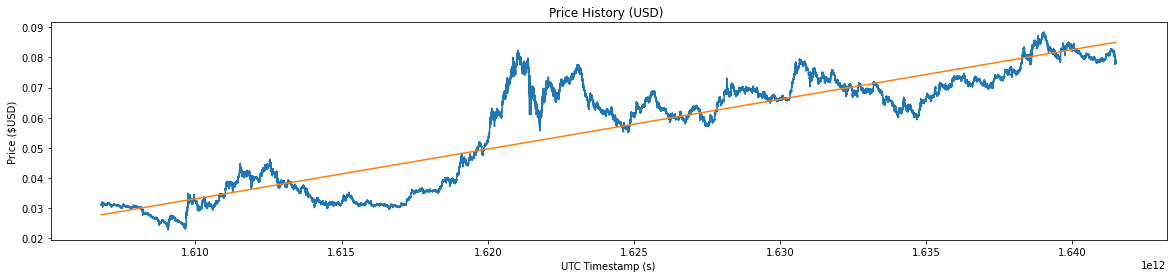

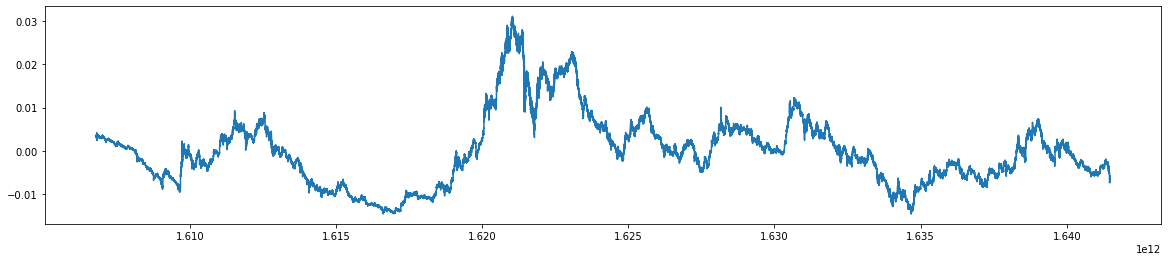

In [13]:

# Graph true price vs 1st order approximation
plt.figure(figsize=(20,4));
plt.plot(time_idx, price);
plt.plot(time_idx, order1_prediction);
plt.title('Price History (USD) ');
plt.xlabel('UTC Timestamp (s)');
plt.ylabel('Price ($USD)');

# Graph 1st order residual 
plt.figure(figsize=(20,4));
plt.plot(time_idx, order1_residual);
plt.title('');

In [14]:
# remove DC component of order 1 residual
order1_residual = order1_residual - np.mean(order1_residual)

# n = signal length
n = price.size

# T = spacing
timestep = 1/(24*60) # unit is days

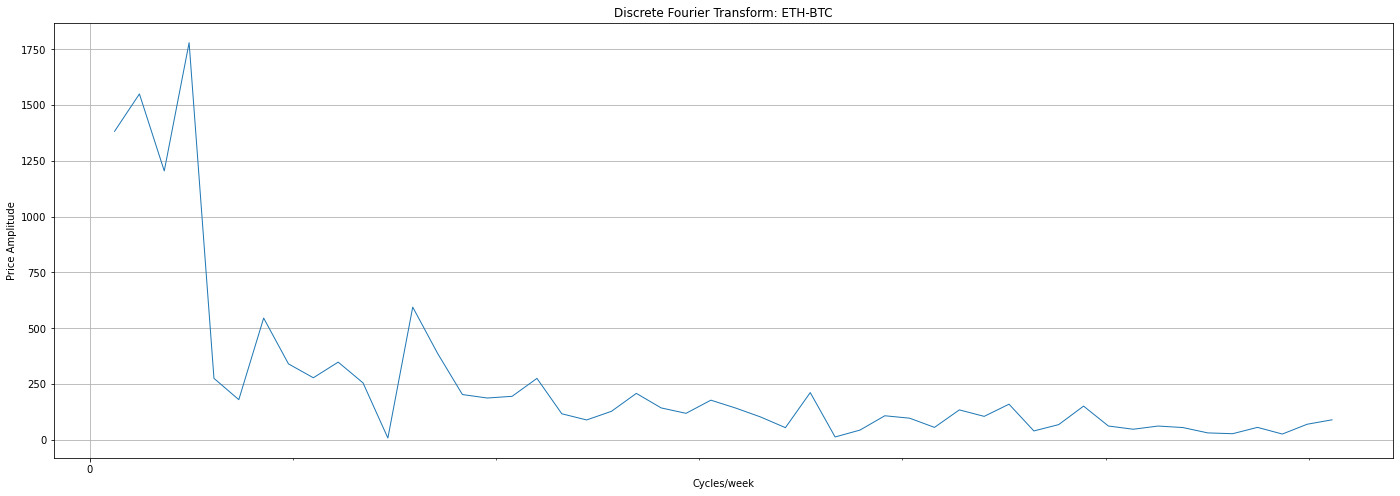

In [15]:
# Raw signal FFT
price_fft = fft.fft(order1_residual,norm=None)[1:n//2] # fft amplitude of pair price 
fft_freq = 7*fft.fftfreq(n, timestep)[1:n//2] # cycles per week
fft_period = 1/fft_freq # period in weeks

# Plot FFT by frequency
plt.figure(figsize=(24,8));
ax = plt.gca();
ax.plot(fft_freq[:50], (np.abs(price_fft[:50])),linewidth=1);
plt.grid();
plt.title('Discrete Fourier Transform: ' + base_asset + '-' + quote_asset);
plt.ylabel('Price Amplitude');
plt.xlabel('Cycles/week');
plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(1/7));
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1));

# # Plot FFT by wavelength
# plt.figure(figsize=(24,8))
# ax = plt.gca()
# ax.plot(fft_period, (np.abs(price_fft)),linewidth=1,marker='o')
# plt.grid()
# plt.title('Discrete Fourier Transform: ' + base_asset + '-' + quote_asset)
# plt.ylabel('Price Amplitude');
# plt.xlabel('Period (week)');

In [16]:
fft_data = df(data=[np.abs(price_fft[0:10]),fft_freq[0:10]],index=['Price Amplitude','Cycles per Week']).transpose()
fft_data['Cycle Period (Days)'] = 7/fft_data['Cycles per Week']
fft_data

Price Amplitude  Cycles per Week  Cycle Period (Days)
0       1382.55169          0.01747            400.65833
1       1549.97586          0.03494            200.32917
2       1205.05978          0.05241            133.55278
3       1779.62092          0.06988            100.16458
4        275.66889          0.08736             80.13167
5        180.16369          0.10483             66.77639
6        545.74066          0.12230             57.23690
7        340.42885          0.13977             50.08229
8        278.31866          0.15724             44.51759
9        348.44093          0.17471             40.06583

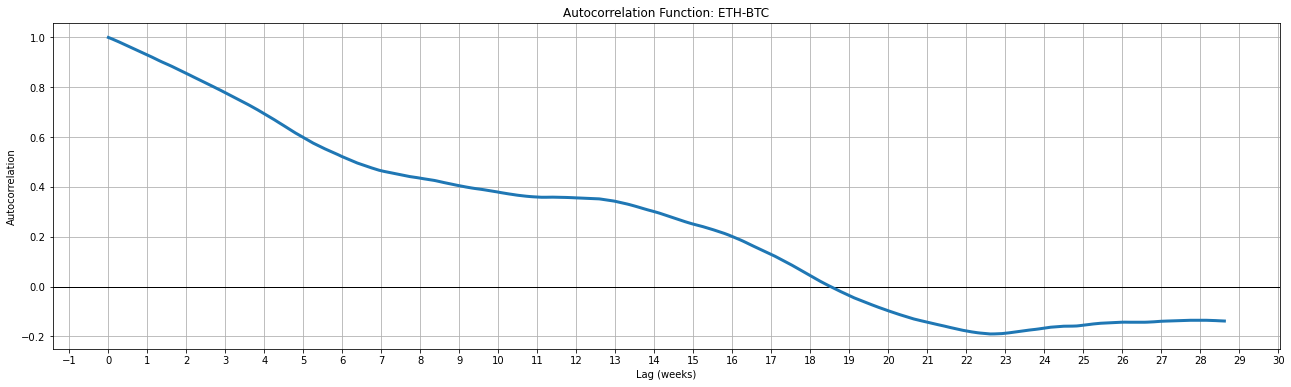

In [17]:
# Raw signal
order0_residual = price-np.mean(price) # remove DC component
ac_residual = np.correlate(order0_residual, order0_residual, 'same')[n//2+1:] # calucate autocorrelation
ac_residual /= ac_residual[0] # normalize by first value

lag = np.arange(len(ac_residual))*(1/(60*24))/7 # lag in weeks

# plot autocorrelation
plt.figure(figsize=(22,6));
ax = plt.gca();
plt.axhline(y=0, color='k',linewidth=1);
plt.plot(lag, ac_residual, linewidth=3);
plt.grid();
plt.title('Autocorrelation Function: ' + base_asset + '-' + quote_asset);
plt.ylabel('Autocorrelation');
plt.xlabel('Lag (weeks)');
ax.xaxis.set_major_locator(plt.MultipleLocator(1));

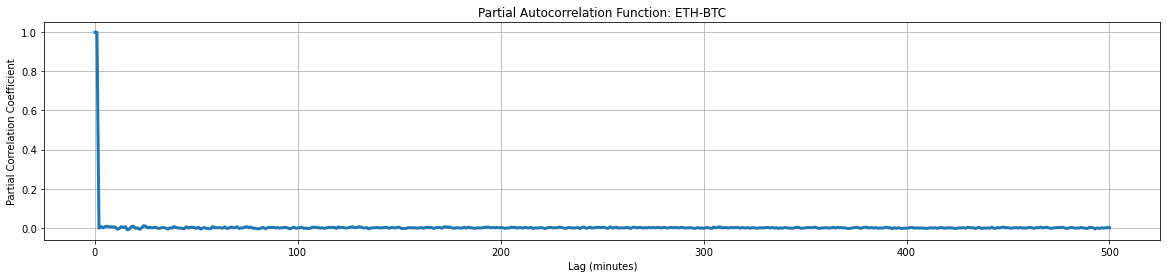

In [18]:
# Partial Autocorrelation
plt.figure(figsize=(20,4));
pac = sm.tsa.stattools.pacf(order0_residual, nlags=500, method='ld');
plt.plot(np.arange(len(pac)), pac, linewidth=3);
plt.grid();
plt.title('Partial Autocorrelation Function: ' + base_asset + '-' + quote_asset);
plt.ylabel('Partial Correlation Coefficient');
plt.xlabel('Lag (minutes)');



In [19]:
# Drop time columns as DF is indexed by UTC timestamp
complete_data = klines.drop(['Open Time UTC','Close Time UTC'],axis='columns')

# add lagged data to complete_data
lag1 = complete_data.shift(1).drop(labels=['Open ' + quote_asset, 'High ' + quote_asset, 'Low ' + quote_asset, 'Close ' + quote_asset],axis='columns').drop(labels=[x for x in klines.columns if 'DIFF ' in x], axis='columns').rename(columns={x: 'LAG 1 ' + x for x in klines.columns})
lag2 = complete_data.shift(2).drop(labels=['Open ' + quote_asset, 'High ' + quote_asset, 'Low ' + quote_asset, 'Close ' + quote_asset],axis='columns').drop(labels=[x for x in klines.columns if 'DIFF ' in x], axis='columns').rename(columns={x: 'LAG 2 ' + x for x in klines.columns})
lag3 = complete_data.shift(3).drop(labels=['Open ' + quote_asset, 'High ' + quote_asset, 'Low ' + quote_asset, 'Close ' + quote_asset],axis='columns').drop(labels=[x for x in klines.columns if 'DIFF ' in x], axis='columns').rename(columns={x: 'LAG 3 ' + x for x in klines.columns})

complete_data = complete_data.join(other=[lag1,lag2,lag3],how='inner').dropna()


In [20]:
# df(complete_data.columns)
complete_data.head()
print('Augmented Kline data shape: ')
complete_data.shape

Open BTC  High BTC  Low BTC  Close BTC  Volume ETH  Volume BTC  \
Open Time UTC                                                                   
1606781220000   0.03138   0.03138  0.03132    0.03132   242.86301     7.61350   
1606781280000   0.03132   0.03134  0.03132    0.03134   120.73700     3.78288   
1606781340000   0.03135   0.03136  0.03132    0.03132    85.66000     2.68420   
1606781400000   0.03132   0.03133  0.03128    0.03129   241.74100     7.56672   
1606781460000   0.03129   0.03129  0.03126    0.03128   322.33600    10.07831   

               Number of Trades  Taker Buy Volume ETH  Taker Buy Volume BTC  \
Open Time UTC                                                                 
1606781220000         177.00000              93.79800               2.94024   
1606781280000         106.00000              59.62500               1.86821   
1606781340000         107.00000              48.02700               1.50500   
1606781400000         134.00000              57.44500               1.79795   
1606781460000         172.00000              64.43000               2.01451   

               Difference BTC  Percent Change BTC  \
Open Time UTC                                       
1606781220000        -0.00006            -0.19118   
1606781280000         0.00002             0.06386   
1606781340000        -0.00003            -0.09252   
1606781400000        -0.00003            -0.10854   
1606781460000        -0.00002            -0.05113   

               Maker-Taker Volume BTC Ratio  Price-Volume BTC Ratio  \
Open Time UTC                                                         
1606781220000                       0.61381                 0.00412   
1606781280000                       0.50614                 0.00828   
1606781340000                       0.43931                 0.01168   
1606781400000                       0.76239                 0.00414   
1606781460000                       0.80011                 0.00310   

               Trade-Volume BTC Ratio  Price-Taker Buy Volume BTC Ratio  \
Open Time UTC                                                             
1606781220000                23.24816                           0.01067   
1606781280000                28.02096                           0.01677   
1606781340000                39.86286                           0.02083   
1606781400000                17.70913                           0.01742   
1606781460000                17.06636                           0.01553   

               Trade-Taker Buy Volume BTC Ratio  DIFF 1 Open BTC  \
Open Time UTC                                                      
1606781220000                          60.19922          0.00004   
1606781280000                          56.73886         -0.00002   
1606781340000                          71.09628         -0.00006   
1606781400000                          74.52953          0.00002   
1606781460000                          85.38051         -0.00002   

               DIFF 1 High BTC  DIFF 1 Low BTC  DIFF 1 Close BTC  \
Open Time UTC                                                      
1606781220000          0.00002         0.00001          -0.00002   
1606781280000         -0.00005        -0.00006          -0.00006   
1606781340000         -0.00004        -0.00000           0.00002   
1606781400000          0.00001        -0.00000          -0.00003   
1606781460000         -0.00002        -0.00003          -0.00003   

               DIFF 1 Volume ETH  DIFF 1 Volume BTC  DIFF 1 Number of Trades  \
Open Time UTC                                                                  
1606781220000          297.32901            9.35025                155.00000   
1606781280000         -427.18399          -13.43628               -203.00000   
1606781340000         -122.12601           -3.83062                -71.00000   
1606781400000          -35.07700           -1.09868                  1.00000   
1606781460000          156.08099            4.88252            

Augmented Kline data shape: 


(576945, 100)

In [21]:
# Plot correlation between pairs except for lag
pairplot = sb.pairplot(complete_data[[col for col in complete_data.columns if 'LAG' not in col]].sample(n=1600, axis='index'), diag_kind='kde', kind='scatter',height=2, corner=True,plot_kws=dict(marker='+',linewidth=1))

pairplot.savefig('pairplot_' + trade_pair + '.png',transparent=False)

In [22]:
# Collect pairwise correlation into dataframe
pairwise = pg.pairwise_corr(complete_data.sample(16000), method='spearman', # use spearman correlation to look for monotonically varying pairs
    alternative='two-sided',padjust='bonf').sort_values(by='r',ascending=False)
pairwise.head()

X          Y    method alternative      n       r       CI95%  \
197   Low BTC  Close BTC  spearman   two-sided  16000 0.99999  [1.0, 1.0]   
0    Open BTC   High BTC  spearman   two-sided  16000 0.99999  [1.0, 1.0]   
100  High BTC  Close BTC  spearman   two-sided  16000 0.99999  [1.0, 1.0]   
1    Open BTC    Low BTC  spearman   two-sided  16000 0.99999  [1.0, 1.0]   
2    Open BTC  Close BTC  spearman   two-sided  16000 0.99999  [1.0, 1.0]   

      p-unc  p-corr p-adjust   power  
197 0.00000 0.00000     bonf 1.00000  
0   0.00000 0.00000     bonf 1.00000  
100 0.00000 0.00000     bonf 1.00000  
1   0.00000 0.00000     bonf 1.00000  
2   0.00000 0.00000     bonf 1.00000

In [23]:
# Clean up pairwise data and copy to new DF 
corr_data = pairwise.sort_values(by='r',ascending=False).drop(columns=['method','alternative','n','power','p-unc'])
corr_data = corr_data[(~corr_data['X'].str.contains(base_asset)) ].set_index('X').drop(columns='p-adjust')

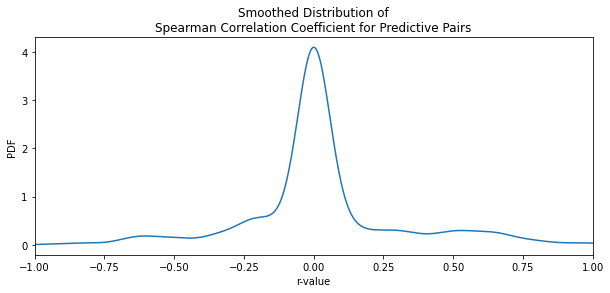

In [24]:
corr_data
plt.figure(figsize=(10,4))
ax = corr_data.r.plot.density(bw_method='scott')
ax.set_title('Smoothed Distribution of\nSpearman Correlation Coefficient for Predictive Pairs');
ax.set_xlabel('r-value');
ax.set_ylabel('PDF');
ax.set_xlim([-1,1]);


In [25]:
# Groupby each variable and sort/filter to find pairs with |r| > 0.1
corr_summary = corr_data.groupby(by='Y')
for x in corr_summary.groups:
    if ('Percent Change ' + quote_asset in corr_summary.get_group(x).index):
        corr_summary.get_group(x).sort_values(by='r',ascending=False)[np.abs(corr_summary.get_group(x)['r'])>0.10]

Y       r         CI95%  p-corr
X                                                              
DIFF 1 Low BTC   DIFF 1 Close BTC 0.54674  [0.54, 0.56] 0.00000
DIFF 1 High BTC  DIFF 1 Close BTC 0.53936  [0.53, 0.55] 0.00000

Y        r           CI95%  \
X                                                                             
DIFF 1 Close BTC             DIFF 1 Difference BTC  0.66582    [0.66, 0.67]   
DIFF 1 Taker Buy Volume BTC  DIFF 1 Difference BTC  0.20748    [0.19, 0.22]   
DIFF 1 Open BTC              DIFF 1 Difference BTC -0.64894  [-0.66, -0.64]   

                             p-corr  
X                                    
DIFF 1 Close BTC            0.00000  
DIFF 1 Taker Buy Volume BTC 0.00000  
DIFF 1 Open BTC             0.00000

Y       r        CI95%  p-corr
X                                                            
DIFF 1 Open BTC  DIFF 1 High BTC 0.51313  [0.5, 0.52] 0.00000

Y       r         CI95%  p-corr
X                                                            
DIFF 1 High BTC  DIFF 1 Low BTC 0.60248  [0.59, 0.61] 0.00000
DIFF 1 Open BTC  DIFF 1 Low BTC 0.50060  [0.49, 0.51] 0.00000

Y        r  \
X                                                                           
DIFF 1 Open BTC              DIFF 1 Maker-Taker Volume BTC Ratio  0.25144   
DIFF 1 Close BTC             DIFF 1 Maker-Taker Volume BTC Ratio -0.25795   
DIFF 1 Difference BTC        DIFF 1 Maker-Taker Volume BTC Ratio -0.36042   
DIFF 1 Percent Change BTC    DIFF 1 Maker-Taker Volume BTC Ratio -0.36156   
DIFF 1 Taker Buy Volume BTC  DIFF 1 Maker-Taker Volume BTC Ratio -0.50120   

                                      CI95%  p-corr  
X                                                    
DIFF 1 Open BTC                [0.24, 0.27] 0.00000  
DIFF 1 Close BTC             [-0.27, -0.24] 0.00000  
DIFF 1 Difference BTC        [-0.37, -0.35] 0.00000  
DIFF 1 Percent Change BTC    [-0.37, -0.35] 0.00000  
DIFF 1 Taker Buy Volume BTC  [-0.51, -0.49] 0.00000

Y        r          CI95%  p-corr
X                                                                         
DIFF 1 Volume BTC  DIFF 1 Number of Trades  0.73022   [0.72, 0.74] 0.00000
DIFF 1 High BTC    DIFF 1 Number of Trades  0.20281   [0.19, 0.22] 0.00000
DIFF 1 Low BTC     DIFF 1 Number of Trades -0.21917  [-0.23, -0.2] 0.00000

Empty DataFrame
Columns: [Y, r, CI95%, p-corr]
Index: []

Y        r  \
X                                                                 
DIFF 1 Difference BTC        DIFF 1 Percent Change BTC  0.98426   
DIFF 1 Close BTC             DIFF 1 Percent Change BTC  0.65860   
DIFF 1 Taker Buy Volume BTC  DIFF 1 Percent Change BTC  0.20882   
DIFF 1 Open BTC              DIFF 1 Percent Change BTC -0.64060   

                                      CI95%  p-corr  
X                                                    
DIFF 1 Difference BTC          [0.98, 0.98] 0.00000  
DIFF 1 Close BTC               [0.65, 0.67] 0.00000  
DIFF 1 Taker Buy Volume BTC    [0.19, 0.22] 0.00000  
DIFF 1 Open BTC              [-0.65, -0.63] 0.00000

Empty DataFrame
Columns: [Y, r, CI95%, p-corr]
Index: []

Y        r  \
X                                                                     
DIFF 1 Low BTC               DIFF 1 Price-Volume BTC Ratio  0.16198   
DIFF 1 High BTC              DIFF 1 Price-Volume BTC Ratio -0.14542   
DIFF 1 Number of Trades      DIFF 1 Price-Volume BTC Ratio -0.61529   
DIFF 1 Taker Buy Volume BTC  DIFF 1 Price-Volume BTC Ratio -0.61854   
DIFF 1 Volume BTC            DIFF 1 Price-Volume BTC Ratio -0.79046   

                                      CI95%  p-corr  
X                                                    
DIFF 1 Low BTC                 [0.15, 0.18] 0.00000  
DIFF 1 High BTC              [-0.16, -0.13] 0.00000  
DIFF 1 Number of Trades      [-0.62, -0.61] 0.00000  
DIFF 1 Taker Buy Volume BTC  [-0.63, -0.61] 0.00000  
DIFF 1 Volume BTC             [-0.8, -0.78] 0.00000

Y        r           CI95%  \
X                                                                               
DIFF 1 Volume BTC        DIFF 1 Taker Buy Volume BTC  0.75575    [0.75, 0.76]   
DIFF 1 Number of Trades  DIFF 1 Taker Buy Volume BTC  0.57458    [0.56, 0.58]   
DIFF 1 High BTC          DIFF 1 Taker Buy Volume BTC  0.16568    [0.15, 0.18]   
DIFF 1 Close BTC         DIFF 1 Taker Buy Volume BTC  0.13844    [0.12, 0.15]   
DIFF 1 Low BTC           DIFF 1 Taker Buy Volume BTC -0.11212   [-0.13, -0.1]   
DIFF 1 Open BTC          DIFF 1 Taker Buy Volume BTC -0.15267  [-0.17, -0.14]   

                         p-corr  
X                                
DIFF 1 Volume BTC       0.00000  
DIFF 1 Number of Trades 0.00000  
DIFF 1 High BTC         0.00000  
DIFF 1 Close BTC        0.00000  
DIFF 1 Low BTC          0.00000  
DIFF 1 Open BTC         0.00000

Y        r           CI95%  \
X                                                                               
DIFF 1 Volume BTC        DIFF 1 Taker Buy Volume ETH  0.74429    [0.74, 0.75]   
DIFF 1 Number of Trades  DIFF 1 Taker Buy Volume ETH  0.56479    [0.55, 0.58]   
DIFF 1 High BTC          DIFF 1 Taker Buy Volume ETH  0.15813    [0.14, 0.17]   
DIFF 1 Close BTC         DIFF 1 Taker Buy Volume ETH  0.13114    [0.12, 0.15]   
DIFF 1 Low BTC           DIFF 1 Taker Buy Volume ETH -0.11139   [-0.13, -0.1]   
DIFF 1 Open BTC          DIFF 1 Taker Buy Volume ETH -0.14894  [-0.16, -0.13]   

                         p-corr  
X                                
DIFF 1 Volume BTC       0.00000  
DIFF 1 Number of Trades 0.00000  
DIFF 1 High BTC         0.00000  
DIFF 1 Close BTC        0.00000  
DIFF 1 Low BTC          0.00000  
DIFF 1 Open BTC         0.00000

Empty DataFrame
Columns: [Y, r, CI95%, p-corr]
Index: []

Y        r  \
X                                                                       
DIFF 1 Price-Volume BTC Ratio  DIFF 1 Trade-Volume BTC Ratio  0.68872   
DIFF 1 Number of Trades        DIFF 1 Trade-Volume BTC Ratio -0.14223   
DIFF 1 Taker Buy Volume BTC    DIFF 1 Trade-Volume BTC Ratio -0.48862   
DIFF 1 Volume BTC              DIFF 1 Trade-Volume BTC Ratio -0.61744   

                                        CI95%  p-corr  
X                                                      
DIFF 1 Price-Volume BTC Ratio     [0.68, 0.7] 0.00000  
DIFF 1 Number of Trades        [-0.16, -0.13] 0.00000  
DIFF 1 Taker Buy Volume BTC     [-0.5, -0.48] 0.00000  
DIFF 1 Volume BTC              [-0.63, -0.61] 0.00000

Y        r          CI95%  p-corr
X                                                                 
DIFF 1 High BTC  DIFF 1 Volume BTC  0.16196   [0.15, 0.18] 0.00000
DIFF 1 Low BTC   DIFF 1 Volume BTC -0.18142  [-0.2, -0.17] 0.00000

Y        r           CI95%  p-corr
X                                                                  
DIFF 1 High BTC  DIFF 1 Volume ETH  0.15509    [0.14, 0.17] 0.00000
DIFF 1 Low BTC   DIFF 1 Volume ETH -0.17770  [-0.19, -0.16] 0.00000

Y       r         CI95%  p-corr
X                                                               
DIFF 2 Low BTC    DIFF 2 Close BTC 0.75709  [0.75, 0.76] 0.00000
DIFF 2 High BTC   DIFF 2 Close BTC 0.75534  [0.75, 0.76] 0.00000
DIFF 1 High BTC   DIFF 2 Close BTC 0.74961  [0.74, 0.76] 0.00000
DIFF 1 Low BTC    DIFF 2 Close BTC 0.73798  [0.73, 0.74] 0.00000
DIFF 1 Open BTC   DIFF 2 Close BTC 0.66807  [0.66, 0.68] 0.00000
DIFF 1 Close BTC  DIFF 2 Close BTC 0.65311  [0.64, 0.66] 0.00000
DIFF 2 Open BTC   DIFF 2 Close BTC 0.44966  [0.44, 0.46] 0.00000

Y        r  \
X                                                                     
DIFF 1 Close BTC                     DIFF 2 Difference BTC  0.66009   
DIFF 2 Close BTC                     DIFF 2 Difference BTC  0.46967   
DIFF 1 Difference BTC                DIFF 2 Difference BTC  0.45525   
DIFF 1 Percent Change BTC            DIFF 2 Difference BTC  0.45058   
DIFF 1 Low BTC                       DIFF 2 Difference BTC  0.37999   
DIFF 1 High BTC                      DIFF 2 Difference BTC  0.37129   
DIFF 2 Taker Buy Volume BTC          DIFF 2 Difference BTC  0.18372   
DIFF 1 Taker Buy Volume BTC          DIFF 2 Difference BTC  0.10221   
DIFF 1 Maker-Taker Volume BTC Ratio  DIFF 2 Difference BTC -0.19677   
DIFF 2 Open BTC                      DIFF 2 Difference BTC -0.45621   

                                              CI95%  p-corr  
X                                                            
DIFF 1 Close BTC                       [0.65, 0.67] 0.00000  
DIFF 2 Close BTC                       [0.46, 0.48] 0.00000  
DIFF 1 Difference BTC                  [0.44, 0.47] 0.00000  
DIFF 1 Percent Change BTC              [0.44, 0.46] 0.00000  
DIFF 1 Low BTC                         [0.37, 0.39] 0.00000  
DIFF 1 High BTC                        [0.36, 0.38] 0.00000  
DIFF 2 Taker Buy Volume BTC             [0.17, 0.2] 0.00000  
DIFF 1 Taker Buy Volume BTC            [0.09, 0.12] 0.00000  
DIFF 1 Maker-Taker Volume BTC Ratio  [-0.21, -0.18] 0.00000  
DIFF 2 Open BTC                      [-0.47, -0.44] 0.00000

Y        r          CI95%  p-corr
X                                                                         
DIFF 2 Open BTC            DIFF 2 High BTC  0.72693   [0.72, 0.73] 0.00000
DIFF 1 High BTC            DIFF 2 High BTC  0.71154    [0.7, 0.72] 0.00000
DIFF 1 Open BTC            DIFF 2 High BTC  0.69729   [0.69, 0.71] 0.00000
DIFF 1 Low BTC             DIFF 2 High BTC  0.56363   [0.55, 0.57] 0.00000
DIFF 1 Close BTC           DIFF 2 High BTC  0.34843   [0.33, 0.36] 0.00000
DIFF 1 Percent Change BTC  DIFF 2 High BTC -0.21601  [-0.23, -0.2] 0.00000
DIFF 1 Difference BTC      DIFF 2 High BTC -0.21826  [-0.23, -0.2] 0.00000

Y        r          CI95%  p-corr
X                                                                          
DIFF 2 High BTC              DIFF 2 Low BTC  0.75232   [0.75, 0.76] 0.00000
DIFF 2 Open BTC              DIFF 2 Low BTC  0.72135   [0.71, 0.73] 0.00000
DIFF 1 Low BTC               DIFF 2 Low BTC  0.70618    [0.7, 0.71] 0.00000
DIFF 1 Open BTC              DIFF 2 Low BTC  0.69582    [0.69, 0.7] 0.00000
DIFF 1 High BTC              DIFF 2 Low BTC  0.57318   [0.56, 0.58] 0.00000
DIFF 1 Close BTC             DIFF 2 Low BTC  0.34786   [0.33, 0.36] 0.00000
DIFF 1 Taker Buy Volume BTC  DIFF 2 Low BTC -0.11915  [-0.13, -0.1] 0.00000
DIFF 1 Percent Change BTC    DIFF 2 Low BTC -0.21393  [-0.23, -0.2] 0.00000
DIFF 1 Difference BTC        DIFF 2 Low BTC -0.21673  [-0.23, -0.2] 0.00000

Y  \
X                                                                          
DIFF 1 Maker-Taker Volume BTC Ratio  DIFF 2 Maker-Taker Volume BTC Ratio   
DIFF 2 Open BTC                      DIFF 2 Maker-Taker Volume BTC Ratio   
DIFF 1 Difference BTC                DIFF 2 Maker-Taker Volume BTC Ratio   
DIFF 1 Percent Change BTC            DIFF 2 Maker-Taker Volume BTC Ratio   
DIFF 1 High BTC                      DIFF 2 Maker-Taker Volume BTC Ratio   
DIFF 2 Close BTC                     DIFF 2 Maker-Taker Volume BTC Ratio   
DIFF 1 Low BTC                       DIFF 2 Maker-Taker Volume BTC Ratio   
DIFF 1 Taker Buy Volume BTC          DIFF 2 Maker-Taker Volume BTC Ratio   
DIFF 1 Close BTC                     DIFF 2 Maker-Taker Volume BTC Ratio   
DIFF 2 Difference BTC                DIFF 2 Maker-Taker Volume BTC Ratio   
DIFF 2 Percent Change BTC            DIFF 2 Maker-Taker Volume BTC Ratio   
DIFF 2 Taker Buy Volume BTC          DIFF 2 Maker-Taker Volume BTC Ratio   

                                           r           CI95%  p-corr  
X                                                                     
DIFF 1 Maker-Taker Volume BTC Ratio  0.48541     [0.47, 0.5] 0.00000  
DIFF 2 Open BTC                      0.17838    [0.16, 0.19] 0.00000  
DIFF 1 Difference BTC               -0.16834  [-0.18, -0.15] 0.00000  
DIFF 1 Percent Change BTC           -0.16952  [-0.18, -0.15] 0.00000  
DIFF 1 High BTC                     -0.17956  [-0.19, -0.16] 0.00000  
DIFF 2 Close BTC                    -0.18467   [-0.2, -0.17] 0.00000  
DIFF 1 Low BTC                      -0.19451  [-0.21, -0.18] 0.00000  
DIFF 1 Taker Buy Volume BTC         -0.24065  [-0.26, -0.23] 0.00000  
DIFF 1 Close BTC                    -0.24875  [-0.26, -0.23] 0.00000  
DIFF 2 Difference BTC               -0.35824  [-0.37, -0.34] 0.00000  
DIFF 2 Percent Change BTC           -0.36092  [-0.37, -0.35] 0.00000  
DIFF 2 Taker Buy Volume BTC         -0.47791  [-0.49, -0.47] 0.00000

Y        r  \
X                                                                 
DIFF 2 Volume BTC              DIFF 2 Number of Trades  0.75245   
DIFF 1 Number of Trades        DIFF 2 Number of Trades  0.49365   
DIFF 1 Volume BTC              DIFF 2 Number of Trades  0.38046   
DIFF 1 Taker Buy Volume BTC    DIFF 2 Number of Trades  0.30379   
DIFF 2 High BTC                DIFF 2 Number of Trades  0.15225   
DIFF 1 Low BTC                 DIFF 2 Number of Trades -0.12140   
DIFF 2 Low BTC                 DIFF 2 Number of Trades -0.18386   
DIFF 1 Price-Volume BTC Ratio  DIFF 2 Number of Trades -0.32497   

                                        CI95%  p-corr  
X                                                      
DIFF 2 Volume BTC                [0.75, 0.76] 0.00000  
DIFF 1 Number of Trades          [0.48, 0.51] 0.00000  
DIFF 1 Volume BTC                [0.37, 0.39] 0.00000  
DIFF 1 Taker Buy Volume BTC      [0.29, 0.32] 0.00000  
DIFF 2 High BTC                  [0.14, 0.17] 0.00000  
DIFF 1 Low BTC                 [-0.14, -0.11] 0.00000  
DIFF 2 Low BTC                  [-0.2, -0.17] 0.00000  
DIFF 1 Price-Volume BTC Ratio  [-0.34, -0.31] 0.00000

Y        r           CI95%  \
X                                                                               
DIFF 1 Open BTC                      DIFF 2 Open BTC  0.65040    [0.64, 0.66]   
DIFF 1 High BTC                      DIFF 2 Open BTC  0.34652    [0.33, 0.36]   
DIFF 1 Low BTC                       DIFF 2 Open BTC  0.33692    [0.32, 0.35]   
DIFF 1 Maker-Taker Volume BTC Ratio  DIFF 2 Open BTC  0.19393    [0.18, 0.21]   
DIFF 1 Taker Buy Volume BTC          DIFF 2 Open BTC -0.11574   [-0.13, -0.1]   
DIFF 1 Percent Change BTC            DIFF 2 Open BTC -0.44011  [-0.45, -0.43]   
DIFF 1 Difference BTC                DIFF 2 Open BTC -0.44616  [-0.46, -0.43]   

                                     p-corr  
X                                            
DIFF 1 Open BTC                     0.00000  
DIFF 1 High BTC                     0.00000  
DIFF 1 Low BTC                      0.00000  
DIFF 1 Maker-Taker Volume BTC Ratio 0.00000  
DIFF 1 Taker Buy Volume BTC         0.00000  
DIFF 1 Percent Change BTC           0.00000  
DIFF 1 Difference BTC               0.00000

Y        r  \
X                                                                         
DIFF 2 Difference BTC                DIFF 2 Percent Change BTC  0.98406   
DIFF 1 Close BTC                     DIFF 2 Percent Change BTC  0.65238   
DIFF 2 Close BTC                     DIFF 2 Percent Change BTC  0.46481   
DIFF 1 Percent Change BTC            DIFF 2 Percent Change BTC  0.45612   
DIFF 1 Difference BTC                DIFF 2 Percent Change BTC  0.44971   
DIFF 1 Low BTC                       DIFF 2 Percent Change BTC  0.37658   
DIFF 1 High BTC                      DIFF 2 Percent Change BTC  0.36784   
DIFF 2 Taker Buy Volume BTC          DIFF 2 Percent Change BTC  0.18665   
DIFF 1 Taker Buy Volume BTC          DIFF 2 Percent Change BTC  0.10073   
DIFF 1 Maker-Taker Volume BTC Ratio  DIFF 2 Percent Change BTC -0.19740   
DIFF 2 Open BTC                      DIFF 2 Percent Change BTC -0.45016   

                                              CI95%  p-corr  
X                                                            
DIFF 2 Difference BTC                  [0.98, 0.98] 0.00000  
DIFF 1 Close BTC                       [0.64, 0.66] 0.00000  
DIFF 2 Close BTC                       [0.45, 0.48] 0.00000  
DIFF 1 Percent Change BTC              [0.44, 0.47] 0.00000  
DIFF 1 Difference BTC                  [0.44, 0.46] 0.00000  
DIFF 1 Low BTC                         [0.36, 0.39] 0.00000  
DIFF 1 High BTC                        [0.35, 0.38] 0.00000  
DIFF 2 Taker Buy Volume BTC             [0.17, 0.2] 0.00000  
DIFF 1 Taker Buy Volume BTC            [0.09, 0.12] 0.00000  
DIFF 1 Maker-Taker Volume BTC Ratio  [-0.21, -0.18] 0.00000  
DIFF 2 Open BTC                      [-0.46, -0.44] 0.00000

Empty DataFrame
Columns: [Y, r, CI95%, p-corr]
Index: []

Y        r  \
X                                                                       
DIFF 1 Price-Volume BTC Ratio  DIFF 2 Price-Volume BTC Ratio  0.47557   
DIFF 1 Trade-Volume BTC Ratio  DIFF 2 Price-Volume BTC Ratio  0.34035   
DIFF 2 Low BTC                 DIFF 2 Price-Volume BTC Ratio  0.12518   
DIFF 2 High BTC                DIFF 2 Price-Volume BTC Ratio -0.11604   
DIFF 1 Taker Buy Volume BTC    DIFF 2 Price-Volume BTC Ratio -0.31944   
DIFF 1 Number of Trades        DIFF 2 Price-Volume BTC Ratio -0.33059   
DIFF 1 Volume BTC              DIFF 2 Price-Volume BTC Ratio -0.40026   
DIFF 2 Number of Trades        DIFF 2 Price-Volume BTC Ratio -0.62672   
DIFF 2 Taker Buy Volume BTC    DIFF 2 Price-Volume BTC Ratio -0.63677   
DIFF 2 Volume BTC              DIFF 2 Price-Volume BTC Ratio -0.79815   

                                        CI95%  p-corr  
X                                                      
DIFF 1 Price-Volume BTC Ratio    [0.46, 0.49] 0.00000  
DIFF 1 Trade-Volume BTC Ratio    [0.33, 0.35] 0.00000  
DIFF 2 Low BTC                   [0.11, 0.14] 0.00000  
DIFF 2 High BTC                 [-0.13, -0.1] 0.00000  
DIFF 1 Taker Buy Volume BTC    [-0.33, -0.31] 0.00000  
DIFF 1 Number of Trades        [-0.34, -0.32] 0.00000  
DIFF 1 Volume BTC              [-0.41, -0.39] 0.00000  
DIFF 2 Number of Trades        [-0.64, -0.62] 0.00000  
DIFF 2 Taker Buy Volume BTC    [-0.65, -0.63] 0.00000  
DIFF 2 Volume BTC               [-0.8, -0.79] 0.00000

Y        r  \
X                                                                           
DIFF 2 Volume BTC                    DIFF 2 Taker Buy Volume BTC  0.76533   
DIFF 2 Number of Trades              DIFF 2 Taker Buy Volume BTC  0.60562   
DIFF 1 Taker Buy Volume BTC          DIFF 2 Taker Buy Volume BTC  0.47369   
DIFF 1 Volume BTC                    DIFF 2 Taker Buy Volume BTC  0.39051   
DIFF 1 Number of Trades              DIFF 2 Taker Buy Volume BTC  0.32091   
DIFF 1 High BTC                      DIFF 2 Taker Buy Volume BTC  0.16380   
DIFF 2 High BTC                      DIFF 2 Taker Buy Volume BTC  0.12601   
DIFF 1 Close BTC                     DIFF 2 Taker Buy Volume BTC  0.12184   
DIFF 2 Low BTC                       DIFF 2 Taker Buy Volume BTC -0.10303   
DIFF 2 Open BTC                      DIFF 2 Taker Buy Volume BTC -0.10439   
DIFF 1 Maker-Taker Volume BTC Ratio  DIFF 2 Taker Buy Volume BTC -0.22702   
DIFF 1 Trade-Volume BTC Ratio        DIFF 2 Taker Buy Volume BTC -0.25562   
DIFF 1 Price-Volume BTC Ratio        DIFF 2 Taker Buy Volume BTC -0.33275   

                                              CI95%  p-corr  
X                                                            
DIFF 2 Volume BTC                      [0.76, 0.77] 0.00000  
DIFF 2 Number of Trades                 [0.6, 0.62] 0.00000  
DIFF 1 Taker Buy Volume BTC            [0.46, 0.49] 0.00000  
DIFF 1 Volume BTC                       [0.38, 0.4] 0.00000  
DIFF 1 Number of Trades                [0.31, 0.33] 0.00000  
DIFF 1 High BTC                        [0.15, 0.18] 0.00000  
DIFF 2 High BTC                        [0.11, 0.14] 0.00000  
DIFF 1 Close BTC                       [0.11, 0.14] 0.00000  
DIFF 2 Low BTC                       [-0.12, -0.09] 0.00000  
DIFF 2 Open BTC                      [-0.12, -0.09] 0.00000  
DIFF 1 Maker-Taker Volume BTC Ratio  [-0.24, -0.21] 0.00000  
DIFF 1 Trade-Volume BTC Ratio        [-0.27, -0.24] 0.00000  
DIFF 1 Price-Volume BTC Ratio        [-0.35, -0.32] 0.00000

Y        r  \
X                                                                           
DIFF 2 Volume BTC                    DIFF 2 Taker Buy Volume ETH  0.75187   
DIFF 2 Number of Trades              DIFF 2 Taker Buy Volume ETH  0.59343   
DIFF 1 Taker Buy Volume BTC          DIFF 2 Taker Buy Volume ETH  0.46832   
DIFF 1 Volume BTC                    DIFF 2 Taker Buy Volume ETH  0.38611   
DIFF 1 Number of Trades              DIFF 2 Taker Buy Volume ETH  0.31623   
DIFF 1 High BTC                      DIFF 2 Taker Buy Volume ETH  0.15904   
DIFF 2 High BTC                      DIFF 2 Taker Buy Volume ETH  0.12078   
DIFF 1 Close BTC                     DIFF 2 Taker Buy Volume ETH  0.11853   
DIFF 2 Low BTC                       DIFF 2 Taker Buy Volume ETH -0.10087   
DIFF 2 Open BTC                      DIFF 2 Taker Buy Volume ETH -0.10347   
DIFF 1 Maker-Taker Volume BTC Ratio  DIFF 2 Taker Buy Volume ETH -0.22317   
DIFF 1 Trade-Volume BTC Ratio        DIFF 2 Taker Buy Volume ETH -0.25156   
DIFF 1 Price-Volume BTC Ratio        DIFF 2 Taker Buy Volume ETH -0.31993   

                                              CI95%  p-corr  
X                                                            
DIFF 2 Volume BTC                      [0.75, 0.76] 0.00000  
DIFF 2 Number of Trades                 [0.58, 0.6] 0.00000  
DIFF 1 Taker Buy Volume BTC            [0.46, 0.48] 0.00000  
DIFF 1 Volume BTC                       [0.37, 0.4] 0.00000  
DIFF 1 Number of Trades                 [0.3, 0.33] 0.00000  
DIFF 1 High BTC                        [0.14, 0.17] 0.00000  
DIFF 2 High BTC                        [0.11, 0.14] 0.00000  
DIFF 1 Close BTC                        [0.1, 0.13] 0.00000  
DIFF 2 Low BTC                       [-0.12, -0.09] 0.00000  
DIFF 2 Open BTC                      [-0.12, -0.09] 0.00000  
DIFF 1 Maker-Taker Volume BTC Ratio  [-0.24, -0.21] 0.00000  
DIFF 1 Trade-Volume BTC Ratio        [-0.27, -0.24] 0.00000  
DIFF 1 Price-Volume BTC Ratio        [-0.33, -0.31] 0.00000

Empty DataFrame
Columns: [Y, r, CI95%, p-corr]
Index: []

Y        r  \
X                                                                       
DIFF 2 Price-Volume BTC Ratio  DIFF 2 Trade-Volume BTC Ratio  0.66311   
DIFF 1 Trade-Volume BTC Ratio  DIFF 2 Trade-Volume BTC Ratio  0.50017   
DIFF 1 Price-Volume BTC Ratio  DIFF 2 Trade-Volume BTC Ratio  0.34652   
DIFF 2 Number of Trades        DIFF 2 Trade-Volume BTC Ratio -0.12489   
DIFF 1 Taker Buy Volume BTC    DIFF 2 Trade-Volume BTC Ratio -0.24349   
DIFF 1 Volume BTC              DIFF 2 Trade-Volume BTC Ratio -0.31125   
DIFF 2 Taker Buy Volume BTC    DIFF 2 Trade-Volume BTC Ratio -0.47528   
DIFF 2 Volume BTC              DIFF 2 Trade-Volume BTC Ratio -0.59090   

                                        CI95%  p-corr  
X                                                      
DIFF 2 Price-Volume BTC Ratio    [0.65, 0.67] 0.00000  
DIFF 1 Trade-Volume BTC Ratio    [0.49, 0.51] 0.00000  
DIFF 1 Price-Volume BTC Ratio    [0.33, 0.36] 0.00000  
DIFF 2 Number of Trades        [-0.14, -0.11] 0.00000  
DIFF 1 Taker Buy Volume BTC    [-0.26, -0.23] 0.00000  
DIFF 1 Volume BTC               [-0.33, -0.3] 0.00000  
DIFF 2 Taker Buy Volume BTC    [-0.49, -0.46] 0.00000  
DIFF 2 Volume BTC               [-0.6, -0.58] 0.00000

Y        r           CI95%  \
X                                                                           
DIFF 1 Volume BTC              DIFF 2 Volume BTC  0.48624     [0.47, 0.5]   
DIFF 1 Number of Trades        DIFF 2 Volume BTC  0.38930     [0.38, 0.4]   
DIFF 1 Taker Buy Volume BTC    DIFF 2 Volume BTC  0.37991    [0.37, 0.39]   
DIFF 2 High BTC                DIFF 2 Volume BTC  0.12775    [0.11, 0.14]   
DIFF 1 Low BTC                 DIFF 2 Volume BTC -0.10801  [-0.12, -0.09]   
DIFF 2 Low BTC                 DIFF 2 Volume BTC -0.15136  [-0.17, -0.14]   
DIFF 1 Trade-Volume BTC Ratio  DIFF 2 Volume BTC -0.31382   [-0.33, -0.3]   
DIFF 1 Price-Volume BTC Ratio  DIFF 2 Volume BTC -0.40612  [-0.42, -0.39]   

                               p-corr  
X                                      
DIFF 1 Volume BTC             0.00000  
DIFF 1 Number of Trades       0.00000  
DIFF 1 Taker Buy Volume BTC   0.00000  
DIFF 2 High BTC               0.00000  
DIFF 1 Low BTC                0.00000  
DIFF 2 Low BTC                0.00000  
DIFF 1 Trade-Volume BTC Ratio 0.00000  
DIFF 1 Price-Volume BTC Ratio 0.00000

Y        r           CI95%  \
X                                                                           
DIFF 1 Volume BTC              DIFF 2 Volume ETH  0.48142    [0.47, 0.49]   
DIFF 1 Number of Trades        DIFF 2 Volume ETH  0.38450     [0.37, 0.4]   
DIFF 1 Taker Buy Volume BTC    DIFF 2 Volume ETH  0.37395    [0.36, 0.39]   
DIFF 2 High BTC                DIFF 2 Volume ETH  0.12351    [0.11, 0.14]   
DIFF 1 Low BTC                 DIFF 2 Volume ETH -0.10658  [-0.12, -0.09]   
DIFF 2 Low BTC                 DIFF 2 Volume ETH -0.14799  [-0.16, -0.13]   
DIFF 1 Trade-Volume BTC Ratio  DIFF 2 Volume ETH -0.31024   [-0.32, -0.3]   
DIFF 1 Price-Volume BTC Ratio  DIFF 2 Volume ETH -0.39160   [-0.4, -0.38]   

                               p-corr  
X                                      
DIFF 1 Volume BTC             0.00000  
DIFF 1 Number of Trades       0.00000  
DIFF 1 Taker Buy Volume BTC   0.00000  
DIFF 2 High BTC               0.00000  
DIFF 1 Low BTC                0.00000  
DIFF 2 Low BTC                0.00000  
DIFF 1 Trade-Volume BTC Ratio 0.00000  
DIFF 1 Price-Volume BTC Ratio 0.00000

Y       r         CI95%  p-corr
X                                                               
DIFF 3 High BTC   DIFF 3 Close BTC 0.82847  [0.82, 0.83] 0.00000
DIFF 3 Low BTC    DIFF 3 Close BTC 0.82643  [0.82, 0.83] 0.00000
DIFF 2 High BTC   DIFF 3 Close BTC 0.81221  [0.81, 0.82] 0.00000
DIFF 2 Low BTC    DIFF 3 Close BTC 0.80847   [0.8, 0.81] 0.00000
DIFF 2 Open BTC   DIFF 3 Close BTC 0.77615  [0.77, 0.78] 0.00000
DIFF 2 Close BTC  DIFF 3 Close BTC 0.76887  [0.76, 0.78] 0.00000
DIFF 3 Open BTC   DIFF 3 Close BTC 0.61725  [0.61, 0.63] 0.00000
DIFF 1 High BTC   DIFF 3 Close BTC 0.59393   [0.58, 0.6] 0.00000
DIFF 1 Low BTC    DIFF 3 Close BTC 0.58550   [0.58, 0.6] 0.00000
DIFF 1 Open BTC   DIFF 3 Close BTC 0.52439  [0.51, 0.54] 0.00000
DIFF 1 Close BTC  DIFF 3 Close BTC 0.52320  [0.51, 0.53] 0.00000

Y        r  \
X                                                                     
DIFF 1 Close BTC                     DIFF 3 Difference BTC  0.65652   
DIFF 2 Difference BTC                DIFF 3 Difference BTC  0.46198   
DIFF 1 Difference BTC                DIFF 3 Difference BTC  0.45825   
DIFF 2 Percent Change BTC            DIFF 3 Difference BTC  0.45588   
DIFF 1 Percent Change BTC            DIFF 3 Difference BTC  0.45426   
DIFF 2 Close BTC                     DIFF 3 Difference BTC  0.45281   
DIFF 3 Close BTC                     DIFF 3 Difference BTC  0.37886   
DIFF 1 Low BTC                       DIFF 3 Difference BTC  0.37345   
DIFF 1 High BTC                      DIFF 3 Difference BTC  0.36309   
DIFF 2 Low BTC                       DIFF 3 Difference BTC  0.24671   
DIFF 2 High BTC                      DIFF 3 Difference BTC  0.24283   
DIFF 3 Taker Buy Volume BTC          DIFF 3 Difference BTC  0.18080   
DIFF 1 Maker-Taker Volume BTC Ratio  DIFF 3 Difference BTC -0.17985   
DIFF 2 Maker-Taker Volume BTC Ratio  DIFF 3 Difference BTC -0.18857   
DIFF 3 Open BTC                      DIFF 3 Difference BTC -0.37127   

                                              CI95%  p-corr  
X                                                            
DIFF 1 Close BTC                       [0.65, 0.67] 0.00000  
DIFF 2 Difference BTC                  [0.45, 0.47] 0.00000  
DIFF 1 Difference BTC                  [0.45, 0.47] 0.00000  
DIFF 2 Percent Change BTC              [0.44, 0.47] 0.00000  
DIFF 1 Percent Change BTC              [0.44, 0.47] 0.00000  
DIFF 2 Close BTC                       [0.44, 0.47] 0.00000  
DIFF 3 Close BTC                       [0.37, 0.39] 0.00000  
DIFF 1 Low BTC                         [0.36, 0.39] 0.00000  
DIFF 1 High BTC                        [0.35, 0.38] 0.00000  
DIFF 2 Low BTC                         [0.23, 0.26] 0.00000  
DIFF 2 High BTC                        [0.23, 0.26] 0.00000  
DIFF 3 Taker Buy Volume BTC             [0.17, 0.2] 0.00000  
DIFF 1 Maker-Taker Volume BTC Ratio  [-0.19, -0.16] 0.00000  
DIFF 2 Maker-Taker Volume BTC Ratio   [-0.2, -0.17] 0.00000  
DIFF 3 Open BTC                      [-0.38, -0.36] 0.00000

Y        r           CI95%  p-corr
X                                                                          
DIFF 3 Open BTC            DIFF 3 High BTC  0.80713     [0.8, 0.81] 0.00000
DIFF 2 High BTC            DIFF 3 High BTC  0.80661     [0.8, 0.81] 0.00000
DIFF 2 Open BTC            DIFF 3 High BTC  0.79753     [0.79, 0.8] 0.00000
DIFF 2 Low BTC             DIFF 3 High BTC  0.69851    [0.69, 0.71] 0.00000
DIFF 2 Close BTC           DIFF 3 High BTC  0.58783     [0.58, 0.6] 0.00000
DIFF 1 High BTC            DIFF 3 High BTC  0.55586    [0.55, 0.57] 0.00000
DIFF 1 Open BTC            DIFF 3 High BTC  0.54190    [0.53, 0.55] 0.00000
DIFF 1 Low BTC             DIFF 3 High BTC  0.44639    [0.43, 0.46] 0.00000
DIFF 1 Close BTC           DIFF 3 High BTC  0.27560    [0.26, 0.29] 0.00000
DIFF 1 Percent Change BTC  DIFF 3 High BTC -0.16769  [-0.18, -0.15] 0.00000
DIFF 1 Difference BTC      DIFF 3 High BTC -0.16942  [-0.18, -0.15] 0.00000
DIFF 2 Percent Change BTC  DIFF 3 High BTC -0.17030  [-0.19, -0.16] 0.00000
DIFF 2 Difference BTC      DIFF 3 High BTC -0.17208  [-0.19, -0.16] 0.00000

Y        r           CI95%  p-corr
X                                                                           
DIFF 3 High BTC              DIFF 3 Low BTC  0.81425    [0.81, 0.82] 0.00000
DIFF 3 Open BTC              DIFF 3 Low BTC  0.80890     [0.8, 0.81] 0.00000
DIFF 2 Low BTC               DIFF 3 Low BTC  0.80036    [0.79, 0.81] 0.00000
DIFF 2 Open BTC              DIFF 3 Low BTC  0.79117     [0.79, 0.8] 0.00000
DIFF 2 High BTC              DIFF 3 Low BTC  0.69683     [0.69, 0.7] 0.00000
DIFF 2 Close BTC             DIFF 3 Low BTC  0.58637     [0.58, 0.6] 0.00000
DIFF 1 Low BTC               DIFF 3 Low BTC  0.54248    [0.53, 0.55] 0.00000
DIFF 1 Open BTC              DIFF 3 Low BTC  0.53288    [0.52, 0.54] 0.00000
DIFF 1 High BTC              DIFF 3 Low BTC  0.45363    [0.44, 0.47] 0.00000
DIFF 1 Close BTC             DIFF 3 Low BTC  0.27838    [0.26, 0.29] 0.00000
DIFF 2 Taker Buy Volume BTC  DIFF 3 Low BTC -0.10536  [-0.12, -0.09] 0.00000
DIFF 1 Percent Change BTC    DIFF 3 Low BTC -0.16032  [-0.18, -0.15] 0.00000
DIFF 1 Difference BTC        DIFF 3 Low BTC -0.16256  [-0.18, -0.15] 0.00000
DIFF 2 Percent Change BTC    DIFF 3 Low BTC -0.16523  [-0.18, -0.15] 0.00000
DIFF 2 Difference BTC        DIFF 3 Low BTC -0.16740  [-0.18, -0.15] 0.00000

Y  \
X                                                                          
DIFF 2 Maker-Taker Volume BTC Ratio  DIFF 3 Maker-Taker Volume BTC Ratio   
DIFF 1 Maker-Taker Volume BTC Ratio  DIFF 3 Maker-Taker Volume BTC Ratio   
DIFF 3 Open BTC                      DIFF 3 Maker-Taker Volume BTC Ratio   
DIFF 2 Low BTC                       DIFF 3 Maker-Taker Volume BTC Ratio   
DIFF 3 Close BTC                     DIFF 3 Maker-Taker Volume BTC Ratio   
DIFF 1 High BTC                      DIFF 3 Maker-Taker Volume BTC Ratio   
DIFF 2 Close BTC                     DIFF 3 Maker-Taker Volume BTC Ratio   
DIFF 1 Difference BTC                DIFF 3 Maker-Taker Volume BTC Ratio   
DIFF 1 Percent Change BTC            DIFF 3 Maker-Taker Volume BTC Ratio   
DIFF 1 Low BTC                       DIFF 3 Maker-Taker Volume BTC Ratio   
DIFF 2 Percent Change BTC            DIFF 3 Maker-Taker Volume BTC Ratio   
DIFF 2 Difference BTC                DIFF 3 Maker-Taker Volume BTC Ratio   
DIFF 1 Taker Buy Volume BTC          DIFF 3 Maker-Taker Volume BTC Ratio   
DIFF 1 Close BTC                     DIFF 3 Maker-Taker Volume BTC Ratio   
DIFF 2 Taker Buy Volume BTC          DIFF 3 Maker-Taker Volume BTC Ratio   
DIFF 3 Difference BTC                DIFF 3 Maker-Taker Volume BTC Ratio   
DIFF 3 Percent Change BTC            DIFF 3 Maker-Taker Volume BTC Ratio   
DIFF 3 Taker Buy Volume BTC          DIFF 3 Maker-Taker Volume BTC Ratio   

                                           r           CI95%  p-corr  
X                                                                     
DIFF 2 Maker-Taker Volume BTC Ratio  0.50675     [0.5, 0.52] 0.00000  
DIFF 1 Maker-Taker Volume BTC Ratio  0.46751    [0.46, 0.48] 0.00000  
DIFF 3 Open BTC                      0.15322    [0.14, 0.17] 0.00000  
DIFF 2 Low BTC                      -0.10153  [-0.12, -0.09] 0.00000  
DIFF 3 Close BTC                    -0.12468  [-0.14, -0.11] 0.00000  
DIFF 1 High BTC                     -0.16571  [-0.18, -0.15] 0.00000  
DIFF 2 Close BTC                    -0.16896  [-0.18, -0.15] 0.00000  
DIFF 1 Difference BTC               -0.16924  [-0.18, -0.15] 0.00000  
DIFF 1 Percent Change BTC           -0.16939  [-0.18, -0.15] 0.00000  
DIFF 1 Low BTC                      -0.17672  [-0.19, -0.16] 0.00000  
DIFF 2 Percent Change BTC           -0.18437   [-0.2, -0.17] 0.00000  
DIFF 2 Difference BTC               -0.18456   [-0.2, -0.17] 0.00000  
DIFF 1 Taker Buy Volume BTC         -0.23575  [-0.25, -0.22] 0.00000  
DIFF 1 Close BTC                    -0.23762  [-0.25, -0.22] 0.00000  
DIFF 2 Taker Buy Volume BTC         -0.25502  [-0.27, -0.24] 0.00000  
DIFF 3 Difference BTC               -0.33888  [-0.35, -0.33] 0.00000  
DIFF 3 Percent Change BTC           -0.34296  [-0.36, -0.33] 0.00000  
DIFF 3 Taker Buy Volume BTC         -0.47781  [-0.49, -0.47] 0.00000

Y        r  \
X                                                                 
DIFF 3 Volume BTC              DIFF 3 Number of Trades  0.75547   
DIFF 2 Number of Trades        DIFF 3 Number of Trades  0.57337   
DIFF 2 Volume BTC              DIFF 3 Number of Trades  0.45035   
DIFF 1 Number of Trades        DIFF 3 Number of Trades  0.41226   
DIFF 2 Taker Buy Volume BTC    DIFF 3 Number of Trades  0.37060   
DIFF 1 Volume BTC              DIFF 3 Number of Trades  0.32392   
DIFF 1 Taker Buy Volume BTC    DIFF 3 Number of Trades  0.26008   
DIFF 3 High BTC                DIFF 3 Number of Trades  0.13514   
DIFF 2 Low BTC                 DIFF 3 Number of Trades -0.10005   
DIFF 1 Low BTC                 DIFF 3 Number of Trades -0.10258   
DIFF 3 Low BTC                 DIFF 3 Number of Trades -0.15318   
DIFF 1 Price-Volume BTC Ratio  DIFF 3 Number of Trades -0.28406   
DIFF 2 Price-Volume BTC Ratio  DIFF 3 Number of Trades -0.37537   

                                        CI95%  p-corr  
X                                                      
DIFF 3 Volume BTC                [0.75, 0.76] 0.00000  
DIFF 2 Number of Trades          [0.56, 0.58] 0.00000  
DIFF 2 Volume BTC                [0.44, 0.46] 0.00000  
DIFF 1 Number of Trades           [0.4, 0.43] 0.00000  
DIFF 2 Taker Buy Volume BTC      [0.36, 0.38] 0.00000  
DIFF 1 Volume BTC                [0.31, 0.34] 0.00000  
DIFF 1 Taker Buy Volume BTC      [0.25, 0.27] 0.00000  
DIFF 3 High BTC                  [0.12, 0.15] 0.00000  
DIFF 2 Low BTC                 [-0.12, -0.08] 0.00000  
DIFF 1 Low BTC                 [-0.12, -0.09] 0.00000  
DIFF 3 Low BTC                 [-0.17, -0.14] 0.00000  
DIFF 1 Price-Volume BTC Ratio   [-0.3, -0.27] 0.00000  
DIFF 2 Price-Volume BTC Ratio  [-0.39, -0.36] 0.00000

Y        r           CI95%  \
X                                                                               
DIFF 2 Open BTC                      DIFF 3 Open BTC  0.76852    [0.76, 0.77]   
DIFF 2 High BTC                      DIFF 3 Open BTC  0.58078    [0.57, 0.59]   
DIFF 2 Low BTC                       DIFF 3 Open BTC  0.57689    [0.57, 0.59]   
DIFF 1 Open BTC                      DIFF 3 Open BTC  0.52010    [0.51, 0.53]   
DIFF 2 Close BTC                     DIFF 3 Open BTC  0.36713    [0.35, 0.38]   
DIFF 1 High BTC                      DIFF 3 Open BTC  0.28520     [0.27, 0.3]   
DIFF 1 Low BTC                       DIFF 3 Open BTC  0.27559    [0.26, 0.29]   
DIFF 2 Maker-Taker Volume BTC Ratio  DIFF 3 Open BTC  0.15719    [0.14, 0.17]   
DIFF 1 Maker-Taker Volume BTC Ratio  DIFF 3 Open BTC  0.15631    [0.14, 0.17]   
DIFF 1 Percent Change BTC            DIFF 3 Open BTC -0.35151  [-0.37, -0.34]   
DIFF 2 Percent Change BTC            DIFF 3 Open BTC -0.35204  [-0.37, -0.34]   
DIFF 1 Difference BTC                DIFF 3 Open BTC -0.35533  [-0.37, -0.34]   
DIFF 2 Difference BTC                DIFF 3 Open BTC -0.35691  [-0.37, -0.34]   

                                     p-corr  
X                                            
DIFF 2 Open BTC                     0.00000  
DIFF 2 High BTC                     0.00000  
DIFF 2 Low BTC                      0.00000  
DIFF 1 Open BTC                     0.00000  
DIFF 2 Close BTC                    0.00000  
DIFF 1 High BTC                     0.00000  
DIFF 1 Low BTC                      0.00000  
DIFF 2 Maker-Taker Volume BTC Ratio 0.00000  
DIFF 1 Maker-Taker Volume BTC Ratio 0.00000  
DIFF 1 Percent Change BTC           0.00000  
DIFF 2 Percent Change BTC           0.00000  
DIFF 1 Difference BTC               0.00000  
DIFF 2 Difference BTC               0.00000

Y        r  \
X                                                                         
DIFF 3 Difference BTC                DIFF 3 Percent Change BTC  0.98399   
DIFF 1 Close BTC                     DIFF 3 Percent Change BTC  0.64943   
DIFF 2 Percent Change BTC            DIFF 3 Percent Change BTC  0.46158   
DIFF 1 Percent Change BTC            DIFF 3 Percent Change BTC  0.46069   
DIFF 2 Difference BTC                DIFF 3 Percent Change BTC  0.45642   
DIFF 1 Difference BTC                DIFF 3 Percent Change BTC  0.45291   
DIFF 2 Close BTC                     DIFF 3 Percent Change BTC  0.44835   
DIFF 3 Close BTC                     DIFF 3 Percent Change BTC  0.37513   
DIFF 1 Low BTC                       DIFF 3 Percent Change BTC  0.37160   
DIFF 1 High BTC                      DIFF 3 Percent Change BTC  0.36154   
DIFF 2 Low BTC                       DIFF 3 Percent Change BTC  0.24516   
DIFF 2 High BTC                      DIFF 3 Percent Change BTC  0.24165   
DIFF 3 Taker Buy Volume BTC          DIFF 3 Percent Change BTC  0.18368   
DIFF 1 Maker-Taker Volume BTC Ratio  DIFF 3 Percent Change BTC -0.17957   
DIFF 2 Maker-Taker Volume BTC Ratio  DIFF 3 Percent Change BTC -0.19124   
DIFF 3 Open BTC                      DIFF 3 Percent Change BTC -0.36678   

                                              CI95%  p-corr  
X                                                            
DIFF 3 Difference BTC                  [0.98, 0.98] 0.00000  
DIFF 1 Close BTC                       [0.64, 0.66] 0.00000  
DIFF 2 Percent Change BTC              [0.45, 0.47] 0.00000  
DIFF 1 Percent Change BTC              [0.45, 0.47] 0.00000  
DIFF 2 Difference BTC                  [0.44, 0.47] 0.00000  
DIFF 1 Difference BTC                  [0.44, 0.47] 0.00000  
DIFF 2 Close BTC                       [0.44, 0.46] 0.00000  
DIFF 3 Close BTC                       [0.36, 0.39] 0.00000  
DIFF 1 Low BTC                         [0.36, 0.38] 0.00000  
DIFF 1 High BTC                        [0.35, 0.37] 0.00000  
DIFF 2 Low BTC                         [0.23, 0.26] 0.00000  
DIFF 2 High BTC                        [0.23, 0.26] 0.00000  
DIFF 3 Taker Buy Volume BTC             [0.17, 0.2] 0.00000  
DIFF 1 Maker-Taker Volume BTC Ratio  [-0.19, -0.16] 0.00000  
DIFF 2 Maker-Taker Volume BTC Ratio  [-0.21, -0.18] 0.00000  
DIFF 3 Open BTC                      [-0.38, -0.35] 0.00000

Empty DataFrame
Columns: [Y, r, CI95%, p-corr]
Index: []

Y        r  \
X                                                                       
DIFF 2 Price-Volume BTC Ratio  DIFF 3 Price-Volume BTC Ratio  0.50333   
DIFF 1 Price-Volume BTC Ratio  DIFF 3 Price-Volume BTC Ratio  0.41651   
DIFF 2 Trade-Volume BTC Ratio  DIFF 3 Price-Volume BTC Ratio  0.34504   
DIFF 1 Trade-Volume BTC Ratio  DIFF 3 Price-Volume BTC Ratio  0.30503   
DIFF 3 Low BTC                 DIFF 3 Price-Volume BTC Ratio  0.11667   
DIFF 1 Number of Trades        DIFF 3 Price-Volume BTC Ratio -0.28190   
DIFF 1 Taker Buy Volume BTC    DIFF 3 Price-Volume BTC Ratio -0.28399   
DIFF 1 Volume BTC              DIFF 3 Price-Volume BTC Ratio -0.35087   
DIFF 2 Taker Buy Volume BTC    DIFF 3 Price-Volume BTC Ratio -0.35861   
DIFF 2 Number of Trades        DIFF 3 Price-Volume BTC Ratio -0.36686   
DIFF 2 Volume BTC              DIFF 3 Price-Volume BTC Ratio -0.43458   
DIFF 3 Number of Trades        DIFF 3 Price-Volume BTC Ratio -0.63426   
DIFF 3 Taker Buy Volume BTC    DIFF 3 Price-Volume BTC Ratio -0.63932   
DIFF 3 Volume BTC              DIFF 3 Price-Volume BTC Ratio -0.79705   

                                        CI95%  p-corr  
X                                                      
DIFF 2 Price-Volume BTC Ratio    [0.49, 0.51] 0.00000  
DIFF 1 Price-Volume BTC Ratio     [0.4, 0.43] 0.00000  
DIFF 2 Trade-Volume BTC Ratio    [0.33, 0.36] 0.00000  
DIFF 1 Trade-Volume BTC Ratio    [0.29, 0.32] 0.00000  
DIFF 3 Low BTC                    [0.1, 0.13] 0.00000  
DIFF 1 Number of Trades         [-0.3, -0.27] 0.00000  
DIFF 1 Taker Buy Volume BTC     [-0.3, -0.27] 0.00000  
DIFF 1 Volume BTC              [-0.36, -0.34] 0.00000  
DIFF 2 Taker Buy Volume BTC    [-0.37, -0.35] 0.00000  
DIFF 2 Number of Trades        [-0.38, -0.35] 0.00000  
DIFF 2 Volume BTC              [-0.45, -0.42] 0.00000  
DIFF 3 Number of Trades        [-0.64, -0.62] 0.00000  
DIFF 3 Taker Buy Volume BTC    [-0.65, -0.63] 0.00000  
DIFF 3 Volume BTC               [-0.8, -0.79] 0.00000

Y        r  \
X                                                                           
DIFF 3 Volume BTC                    DIFF 3 Taker Buy Volume BTC  0.77680   
DIFF 3 Number of Trades              DIFF 3 Taker Buy Volume BTC  0.61262   
DIFF 2 Taker Buy Volume BTC          DIFF 3 Taker Buy Volume BTC  0.53213   
DIFF 2 Volume BTC                    DIFF 3 Taker Buy Volume BTC  0.43721   
DIFF 1 Taker Buy Volume BTC          DIFF 3 Taker Buy Volume BTC  0.43088   
DIFF 2 Number of Trades              DIFF 3 Taker Buy Volume BTC  0.36623   
DIFF 1 Volume BTC                    DIFF 3 Taker Buy Volume BTC  0.34335   
DIFF 1 Number of Trades              DIFF 3 Taker Buy Volume BTC  0.26848   
DIFF 1 High BTC                      DIFF 3 Taker Buy Volume BTC  0.15026   
DIFF 1 Close BTC                     DIFF 3 Taker Buy Volume BTC  0.12439   
DIFF 2 High BTC                      DIFF 3 Taker Buy Volume BTC  0.11494   
DIFF 3 High BTC                      DIFF 3 Taker Buy Volume BTC  0.10298   
DIFF 3 Low BTC                       DIFF 3 Taker Buy Volume BTC -0.10519   
DIFF 1 Maker-Taker Volume BTC Ratio  DIFF 3 Taker Buy Volume BTC -0.21984   
DIFF 1 Trade-Volume BTC Ratio        DIFF 3 Taker Buy Volume BTC -0.23766   
DIFF 2 Maker-Taker Volume BTC Ratio  DIFF 3 Taker Buy Volume BTC -0.25019   
DIFF 2 Trade-Volume BTC Ratio        DIFF 3 Taker Buy Volume BTC -0.26763   
DIFF 1 Price-Volume BTC Ratio        DIFF 3 Taker Buy Volume BTC -0.29335   
DIFF 2 Price-Volume BTC Ratio        DIFF 3 Taker Buy Volume BTC -0.36386   

                                              CI95%  p-corr  
X                                                            
DIFF 3 Volume BTC                      [0.77, 0.78] 0.00000  
DIFF 3 Number of Trades                 [0.6, 0.62] 0.00000  
DIFF 2 Taker Buy Volume BTC            [0.52, 0.54] 0.00000  
DIFF 2 Volume BTC                      [0.42, 0.45] 0.00000  
DIFF 1 Taker Buy Volume BTC            [0.42, 0.44] 0.00000  
DIFF 2 Number of Trades                [0.35, 0.38] 0.00000  
DIFF 1 Volume BTC                      [0.33, 0.36] 0.00000  
DIFF 1 Number of Trades                [0.25, 0.28] 0.00000  
DIFF 1 High BTC                        [0.14, 0.17] 0.00000  
DIFF 1 Close BTC                       [0.11, 0.14] 0.00000  
DIFF 2 High BTC                         [0.1, 0.13] 0.00000  
DIFF 3 High BTC                        [0.09, 0.12] 0.00000  
DIFF 3 Low BTC                       [-0.12, -0.09] 0.00000  
DIFF 1 Maker-Taker Volume BTC Ratio  [-0.23, -0.21] 0.00000  
DIFF 1 Trade-Volume BTC Ratio        [-0.25, -0.22] 0.00000  
DIFF 2 Maker-Taker Volume BTC Ratio  [-0.26, -0.24] 0.00000  
DIFF 2 Trade-Volume BTC Ratio        [-0.28, -0.25] 0.00000  
DIFF 1 Price-Volume BTC Ratio        [-0.31, -0.28] 0.00000  
DIFF 2 Price-Volume BTC Ratio        [-0.38, -0.35] 0.00000

Y        r  \
X                                                                           
DIFF 3 Volume BTC                    DIFF 3 Taker Buy Volume ETH  0.76431   
DIFF 3 Number of Trades              DIFF 3 Taker Buy Volume ETH  0.60095   
DIFF 2 Taker Buy Volume BTC          DIFF 3 Taker Buy Volume ETH  0.52584   
DIFF 2 Volume BTC                    DIFF 3 Taker Buy Volume ETH  0.43111   
DIFF 1 Taker Buy Volume BTC          DIFF 3 Taker Buy Volume ETH  0.42638   
DIFF 2 Number of Trades              DIFF 3 Taker Buy Volume ETH  0.36082   
DIFF 1 Volume BTC                    DIFF 3 Taker Buy Volume ETH  0.33974   
DIFF 1 Number of Trades              DIFF 3 Taker Buy Volume ETH  0.26477   
DIFF 1 High BTC                      DIFF 3 Taker Buy Volume ETH  0.14533   
DIFF 1 Close BTC                     DIFF 3 Taker Buy Volume ETH  0.12054   
DIFF 2 High BTC                      DIFF 3 Taker Buy Volume ETH  0.11036   
DIFF 3 Low BTC                       DIFF 3 Taker Buy Volume ETH -0.10351   
DIFF 1 Maker-Taker Volume BTC Ratio  DIFF 3 Taker Buy Volume ETH -0.21654   
DIFF 1 Trade-Volume BTC Ratio        DIFF 3 Taker Buy Volume ETH -0.23473   
DIFF 2 Maker-Taker Volume BTC Ratio  DIFF 3 Taker Buy Volume ETH -0.24770   
DIFF 2 Trade-Volume BTC Ratio        DIFF 3 Taker Buy Volume ETH -0.26221   
DIFF 1 Price-Volume BTC Ratio        DIFF 3 Taker Buy Volume ETH -0.28297   
DIFF 2 Price-Volume BTC Ratio        DIFF 3 Taker Buy Volume ETH -0.35005   

                                              CI95%  p-corr  
X                                                            
DIFF 3 Volume BTC                      [0.76, 0.77] 0.00000  
DIFF 3 Number of Trades                [0.59, 0.61] 0.00000  
DIFF 2 Taker Buy Volume BTC            [0.51, 0.54] 0.00000  
DIFF 2 Volume BTC                      [0.42, 0.44] 0.00000  
DIFF 1 Taker Buy Volume BTC            [0.41, 0.44] 0.00000  
DIFF 2 Number of Trades                [0.35, 0.37] 0.00000  
DIFF 1 Volume BTC                      [0.33, 0.35] 0.00000  
DIFF 1 Number of Trades                [0.25, 0.28] 0.00000  
DIFF 1 High BTC                        [0.13, 0.16] 0.00000  
DIFF 1 Close BTC                       [0.11, 0.14] 0.00000  
DIFF 2 High BTC                         [0.1, 0.13] 0.00000  
DIFF 3 Low BTC                       [-0.12, -0.09] 0.00000  
DIFF 1 Maker-Taker Volume BTC Ratio   [-0.23, -0.2] 0.00000  
DIFF 1 Trade-Volume BTC Ratio        [-0.25, -0.22] 0.00000  
DIFF 2 Maker-Taker Volume BTC Ratio  [-0.26, -0.23] 0.00000  
DIFF 2 Trade-Volume BTC Ratio        [-0.28, -0.25] 0.00000  
DIFF 1 Price-Volume BTC Ratio         [-0.3, -0.27] 0.00000  
DIFF 2 Price-Volume BTC Ratio        [-0.36, -0.34] 0.00000

Empty DataFrame
Columns: [Y, r, CI95%, p-corr]
Index: []

Y        r  \
X                                                                       
DIFF 3 Price-Volume BTC Ratio  DIFF 3 Trade-Volume BTC Ratio  0.66212   
DIFF 2 Trade-Volume BTC Ratio  DIFF 3 Trade-Volume BTC Ratio  0.52002   
DIFF 1 Trade-Volume BTC Ratio  DIFF 3 Trade-Volume BTC Ratio  0.45197   
DIFF 2 Price-Volume BTC Ratio  DIFF 3 Trade-Volume BTC Ratio  0.35232   
DIFF 1 Price-Volume BTC Ratio  DIFF 3 Trade-Volume BTC Ratio  0.31027   
DIFF 3 Number of Trades        DIFF 3 Trade-Volume BTC Ratio -0.14049   
DIFF 1 Taker Buy Volume BTC    DIFF 3 Trade-Volume BTC Ratio -0.23136   
DIFF 2 Taker Buy Volume BTC    DIFF 3 Trade-Volume BTC Ratio -0.26014   
DIFF 1 Volume BTC              DIFF 3 Trade-Volume BTC Ratio -0.29159   
DIFF 2 Volume BTC              DIFF 3 Trade-Volume BTC Ratio -0.32097   
DIFF 3 Taker Buy Volume BTC    DIFF 3 Trade-Volume BTC Ratio -0.47972   
DIFF 3 Volume BTC              DIFF 3 Trade-Volume BTC Ratio -0.59842   

                                        CI95%  p-corr  
X                                                      
DIFF 3 Price-Volume BTC Ratio    [0.65, 0.67] 0.00000  
DIFF 2 Trade-Volume BTC Ratio    [0.51, 0.53] 0.00000  
DIFF 1 Trade-Volume BTC Ratio    [0.44, 0.46] 0.00000  
DIFF 2 Price-Volume BTC Ratio    [0.34, 0.37] 0.00000  
DIFF 1 Price-Volume BTC Ratio     [0.3, 0.32] 0.00000  
DIFF 3 Number of Trades        [-0.16, -0.13] 0.00000  
DIFF 1 Taker Buy Volume BTC    [-0.25, -0.22] 0.00000  
DIFF 2 Taker Buy Volume BTC    [-0.27, -0.25] 0.00000  
DIFF 1 Volume BTC              [-0.31, -0.28] 0.00000  
DIFF 2 Volume BTC              [-0.33, -0.31] 0.00000  
DIFF 3 Taker Buy Volume BTC    [-0.49, -0.47] 0.00000  
DIFF 3 Volume BTC              [-0.61, -0.59] 0.00000

Y        r           CI95%  \
X                                                                           
DIFF 2 Volume BTC              DIFF 3 Volume BTC  0.54350    [0.53, 0.55]   
DIFF 2 Number of Trades        DIFF 3 Volume BTC  0.44595    [0.43, 0.46]   
DIFF 2 Taker Buy Volume BTC    DIFF 3 Volume BTC  0.43965    [0.43, 0.45]   
DIFF 1 Volume BTC              DIFF 3 Volume BTC  0.42998    [0.42, 0.44]   
DIFF 1 Taker Buy Volume BTC    DIFF 3 Volume BTC  0.34129    [0.33, 0.35]   
DIFF 1 Number of Trades        DIFF 3 Volume BTC  0.32956    [0.32, 0.34]   
DIFF 3 High BTC                DIFF 3 Volume BTC  0.10842    [0.09, 0.12]   
DIFF 3 Low BTC                 DIFF 3 Volume BTC -0.13452  [-0.15, -0.12]   
DIFF 1 Trade-Volume BTC Ratio  DIFF 3 Volume BTC -0.28829   [-0.3, -0.27]   
DIFF 2 Trade-Volume BTC Ratio  DIFF 3 Volume BTC -0.32666  [-0.34, -0.31]   
DIFF 1 Price-Volume BTC Ratio  DIFF 3 Volume BTC -0.36101  [-0.37, -0.35]   
DIFF 2 Price-Volume BTC Ratio  DIFF 3 Volume BTC -0.44364  [-0.46, -0.43]   

                               p-corr  
X                                      
DIFF 2 Volume BTC             0.00000  
DIFF 2 Number of Trades       0.00000  
DIFF 2 Taker Buy Volume BTC   0.00000  
DIFF 1 Volume BTC             0.00000  
DIFF 1 Taker Buy Volume BTC   0.00000  
DIFF 1 Number of Trades       0.00000  
DIFF 3 High BTC               0.00000  
DIFF 3 Low BTC                0.00000  
DIFF 1 Trade-Volume BTC Ratio 0.00000  
DIFF 2 Trade-Volume BTC Ratio 0.00000  
DIFF 1 Price-Volume BTC Ratio 0.00000  
DIFF 2 Price-Volume BTC Ratio 0.00000

Y        r           CI95%  \
X                                                                           
DIFF 2 Volume BTC              DIFF 3 Volume ETH  0.53818    [0.53, 0.55]   
DIFF 2 Number of Trades        DIFF 3 Volume ETH  0.44083    [0.43, 0.45]   
DIFF 2 Taker Buy Volume BTC    DIFF 3 Volume ETH  0.43348    [0.42, 0.45]   
DIFF 1 Volume BTC              DIFF 3 Volume ETH  0.42528    [0.41, 0.44]   
DIFF 1 Taker Buy Volume BTC    DIFF 3 Volume ETH  0.33643    [0.32, 0.35]   
DIFF 1 Number of Trades        DIFF 3 Volume ETH  0.32425    [0.31, 0.34]   
DIFF 3 High BTC                DIFF 3 Volume ETH  0.10303    [0.09, 0.12]   
DIFF 3 Low BTC                 DIFF 3 Volume ETH -0.13253  [-0.15, -0.12]   
DIFF 1 Trade-Volume BTC Ratio  DIFF 3 Volume ETH -0.28585   [-0.3, -0.27]   
DIFF 2 Trade-Volume BTC Ratio  DIFF 3 Volume ETH -0.32282  [-0.34, -0.31]   
DIFF 1 Price-Volume BTC Ratio  DIFF 3 Volume ETH -0.34853  [-0.36, -0.33]   
DIFF 2 Price-Volume BTC Ratio  DIFF 3 Volume ETH -0.42778  [-0.44, -0.42]   

                               p-corr  
X                                      
DIFF 2 Volume BTC             0.00000  
DIFF 2 Number of Trades       0.00000  
DIFF 2 Taker Buy Volume BTC   0.00000  
DIFF 1 Volume BTC             0.00000  
DIFF 1 Taker Buy Volume BTC   0.00000  
DIFF 1 Number of Trades       0.00000  
DIFF 3 High BTC               0.00000  
DIFF 3 Low BTC                0.00000  
DIFF 1 Trade-Volume BTC Ratio 0.00000  
DIFF 2 Trade-Volume BTC Ratio 0.00000  
DIFF 1 Price-Volume BTC Ratio 0.00000  
DIFF 2 Price-Volume BTC Ratio 0.00000

Y        r  \
X                                                                    
DIFF 1 Close BTC                     LAG 1 Difference BTC  0.98632   
DIFF 2 Difference BTC                LAG 1 Difference BTC  0.66756   
DIFF 1 Difference BTC                LAG 1 Difference BTC  0.66659   
DIFF 3 Difference BTC                LAG 1 Difference BTC  0.66448   
DIFF 2 Percent Change BTC            LAG 1 Difference BTC  0.65984   
DIFF 1 Percent Change BTC            LAG 1 Difference BTC  0.65926   
DIFF 3 Percent Change BTC            LAG 1 Difference BTC  0.65658   
DIFF 2 Close BTC                     LAG 1 Difference BTC  0.65161   
DIFF 1 Low BTC                       LAG 1 Difference BTC  0.53928   
DIFF 1 High BTC                      LAG 1 Difference BTC  0.53078   
DIFF 3 Close BTC                     LAG 1 Difference BTC  0.52252   
DIFF 2 Low BTC                       LAG 1 Difference BTC  0.34331   
DIFF 2 High BTC                      LAG 1 Difference BTC  0.34323   
DIFF 3 Low BTC                       LAG 1 Difference BTC  0.27503   
DIFF 3 High BTC                      LAG 1 Difference BTC  0.27113   
LAG 1 Taker Buy Volume BTC           LAG 1 Difference BTC  0.14041   
DIFF 1 Taker Buy Volume BTC          LAG 1 Difference BTC  0.13924   
DIFF 3 Taker Buy Volume BTC          LAG 1 Difference BTC  0.12324   
DIFF 2 Taker Buy Volume BTC          LAG 1 Difference BTC  0.12138   
DIFF 3 Maker-Taker Volume BTC Ratio  LAG 1 Difference BTC -0.24019   
DIFF 2 Maker-Taker Volume BTC Ratio  LAG 1 Difference BTC -0.25053   
DIFF 1 Maker-Taker Volume BTC Ratio  LAG 1 Difference BTC -0.26020   

                                              CI95%  p-corr  
X                                                            
DIFF 1 Close BTC                       [0.99, 0.99] 0.00000  
DIFF 2 Difference BTC                  [0.66, 0.68] 0.00000  
DIFF 1 Difference BTC                  [0.66, 0.68] 0.00000  
DIFF 3 Difference BTC                  [0.66, 0.67] 0.00000  
DIFF 2 Percent Change BTC              [0.65, 0.67] 0.00000  
DIFF 1 Percent Change BTC              [0.65, 0.67] 0.00000  
DIFF 3 Percent Change BTC              [0.65, 0.67] 0.00000  
DIFF 2 Close BTC                       [0.64, 0.66] 0.00000  
DIFF 1 Low BTC                         [0.53, 0.55] 0.00000  
DIFF 1 High BTC                        [0.52, 0.54] 0.00000  
DIFF 3 Close BTC                       [0.51, 0.53] 0.00000  
DIFF 2 Low BTC                         [0.33, 0.36] 0.00000  
DIFF 2 High BTC                        [0.33, 0.36] 0.00000  
DIFF 3 Low BTC                         [0.26, 0.29] 0.00000  
DIFF 3 High BTC                        [0.26, 0.29] 0.00000  
LAG 1 Taker Buy Volume BTC             [0.13, 0.16] 0.00000  
DIFF 1 Taker Buy Volume BTC            [0.12, 0.15] 0.00000  
DIFF 3 Taker Buy Volume BTC            [0.11, 0.14] 0.00000  
DIFF 2 Taker Buy Volume BTC            [0.11, 0.14] 0.00000  
DIFF 3 Maker-Taker Volume BTC Ratio  [-0.25, -0.23] 0.00000  
DIFF 2 Maker-Taker Volume BTC Ratio  [-0.26, -0.24] 0.00000  
DIFF 1 Maker-Taker Volume BTC Ratio  [-0.27, -0.25] 0.00000

Y  \
X                                                                         
DIFF 3 Maker-Taker Volume BTC Ratio  LAG 1 Maker-Taker Volume BTC Ratio   
DIFF 2 Maker-Taker Volume BTC Ratio  LAG 1 Maker-Taker Volume BTC Ratio   
DIFF 1 Maker-Taker Volume BTC Ratio  LAG 1 Maker-Taker Volume BTC Ratio   
Maker-Taker Volume BTC Ratio         LAG 1 Maker-Taker Volume BTC Ratio   
DIFF 3 High BTC                      LAG 1 Maker-Taker Volume BTC Ratio   
DIFF 3 Low BTC                       LAG 1 Maker-Taker Volume BTC Ratio   
DIFF 2 High BTC                      LAG 1 Maker-Taker Volume BTC Ratio   
DIFF 2 Low BTC                       LAG 1 Maker-Taker Volume BTC Ratio   
DIFF 3 Close BTC                     LAG 1 Maker-Taker Volume BTC Ratio   
DIFF 1 Difference BTC                LAG 1 Maker-Taker Volume BTC Ratio   
DIFF 1 Percent Change BTC            LAG 1 Maker-Taker Volume BTC Ratio   
DIFF 1 High BTC                      LAG 1 Maker-Taker Volume BTC Ratio   
DIFF 2 Close BTC                     LAG 1 Maker-Taker Volume BTC Ratio   
DIFF 3 Difference BTC                LAG 1 Maker-Taker Volume BTC Ratio   
DIFF 3 Percent Change BTC            LAG 1 Maker-Taker Volume BTC Ratio   
DIFF 2 Difference BTC                LAG 1 Maker-Taker Volume BTC Ratio   
DIFF 2 Percent Change BTC            LAG 1 Maker-Taker Volume BTC Ratio   
DIFF 1 Low BTC                       LAG 1 Maker-Taker Volume BTC Ratio   
DIFF 2 Taker Buy Volume BTC          LAG 1 Maker-Taker Volume BTC Ratio   
DIFF 1 Taker Buy Volume BTC          LAG 1 Maker-Taker Volume BTC Ratio   
DIFF 3 Taker Buy Volume BTC          LAG 1 Maker-Taker Volume BTC Ratio   
DIFF 1 Close BTC                     LAG 1 Maker-Taker Volume BTC Ratio   
LAG 1 Difference BTC                 LAG 1 Maker-Taker Volume BTC Ratio   
LAG 1 Percent Change BTC             LAG 1 Maker-Taker Volume BTC Ratio   
LAG 1 Taker Buy Volume BTC           LAG 1 Maker-Taker Volume BTC Ratio   

                                           r           CI95%  p-corr  
X                                                                     
DIFF 3 Maker-Taker Volume BTC Ratio  0.66714    [0.66, 0.68] 0.00000  
DIFF 2 Maker-Taker Volume BTC Ratio  0.65493    [0.65, 0.66] 0.00000  
DIFF 1 Maker-Taker Volume BTC Ratio  0.63290    [0.62, 0.64] 0.00000  
Maker-Taker Volume BTC Ratio         0.11266     [0.1, 0.13] 0.00000  
DIFF 3 High BTC                     -0.10756  [-0.12, -0.09] 0.00000  
DIFF 3 Low BTC                      -0.11419   [-0.13, -0.1] 0.00000  
DIFF 2 High BTC                     -0.14449  [-0.16, -0.13] 0.00000  
DIFF 2 Low BTC                      -0.15917  [-0.17, -0.14] 0.00000  
DIFF 3 Close BTC                    -0.19037  [-0.21, -0.18] 0.00000  
DIFF 1 Difference BTC               -0.23472  [-0.25, -0.22] 0.00000  
DIFF 1 Percent Change BTC           -0.23526  [-0.25, -0.22] 0.00000  
DIFF 1 High BTC                     -0.23955  [-0.25, -0.22] 0.00000  
DIFF 2 Close BTC                    -0.24485  [-0.26, -0.23] 0.00000  
DIFF 3 Difference BTC               -0.24602  [-0.26, -0.23] 0.00000  
DIFF 3 Percent Change BTC           -0.24691  [-0.26, -0.23] 0.00000  
DIFF 2 Difference BTC               -0.25138  [-0.27, -0.24] 0.00000  
DIFF 2 Percent Change BTC           -0.25221  [-0.27, -0.24] 0.00000  
DIFF 1 Low BTC                      -0.25430  [-0.27, -0.24] 0.00000  
DIFF 2 Taker Buy Volume BTC         -0.31431   [-0.33, -0.3] 0.00000  
DIFF 1 Taker Buy Volume BTC         -0.31993  [-0.33, -0.31] 0.00000  
DIFF 3 Taker Buy Volume BTC         -0.32189  [-0.34, -0.31] 0.00000  
DIFF 1 Close BTC                    -0.33838  [-0.35, -0.32] 0.00000  
LAG 1 Difference BTC                -0.34177  [-0.36, -0.33] 0.00000  
LAG 1 Percent Change BTC            -0.34448  [-0.36, -0.33] 0.00000  
LAG 1 Taker Buy Volume BTC          -0.35304  [-0.37, -0.34] 0.00000

Y        r  \
X                                                                   
LAG 1 Volume BTC                  LAG 1 Number of Trades  0.86455   
Number of Trades                  LAG 1 Number of Trades  0.77750   
Volume BTC                        LAG 1 Number of Trades  0.65053   
Taker Buy Volume BTC              LAG 1 Number of Trades  0.60037   
DIFF 3 Number of Trades           LAG 1 Number of Trades  0.30654   
DIFF 2 Number of Trades           LAG 1 Number of Trades  0.28284   
DIFF 3 Volume BTC                 LAG 1 Number of Trades  0.24650   
DIFF 1 Number of Trades           LAG 1 Number of Trades  0.24093   
DIFF 2 Volume BTC                 LAG 1 Number of Trades  0.23094   
DIFF 3 Taker Buy Volume BTC       LAG 1 Number of Trades  0.20260   
DIFF 2 Taker Buy Volume BTC       LAG 1 Number of Trades  0.19702   
DIFF 1 Volume BTC                 LAG 1 Number of Trades  0.19342   
DIFF 1 Taker Buy Volume BTC       LAG 1 Number of Trades  0.15667   
DIFF 1 Price-Volume BTC Ratio     LAG 1 Number of Trades -0.21641   
High BTC                          LAG 1 Number of Trades -0.22940   
Close BTC                         LAG 1 Number of Trades -0.23033   
Open BTC                          LAG 1 Number of Trades -0.23035   
Low BTC                           LAG 1 Number of Trades -0.23132   
DIFF 2 Price-Volume BTC Ratio     LAG 1 Number of Trades -0.25170   
DIFF 3 Price-Volume BTC Ratio     LAG 1 Number of Trades -0.25461   
Price-Taker Buy Volume BTC Ratio  LAG 1 Number of Trades -0.61995   
Price-Volume BTC Ratio            LAG 1 Number of Trades -0.65658   

                                           CI95%  p-corr  
X                                                         
LAG 1 Volume BTC                    [0.86, 0.87] 0.00000  
Number of Trades                    [0.77, 0.78] 0.00000  
Volume BTC                          [0.64, 0.66] 0.00000  
Taker Buy Volume BTC                [0.59, 0.61] 0.00000  
DIFF 3 Number of Trades             [0.29, 0.32] 0.00000  
DIFF 2 Number of Trades              [0.27, 0.3] 0.00000  
DIFF 3 Volume BTC                   [0.23, 0.26] 0.00000  
DIFF 1 Number of Trades             [0.23, 0.26] 0.00000  
DIFF 2 Volume BTC                   [0.22, 0.25] 0.00000  
DIFF 3 Taker Buy Volume BTC         [0.19, 0.22] 0.00000  
DIFF 2 Taker Buy Volume BTC         [0.18, 0.21] 0.00000  
DIFF 1 Volume BTC                   [0.18, 0.21] 0.00000  
DIFF 1 Taker Buy Volume BTC         [0.14, 0.17] 0.00000  
DIFF 1 Price-Volume BTC Ratio      [-0.23, -0.2] 0.00000  
High BTC                          [-0.24, -0.21] 0.00000  
Close BTC                         [-0.24, -0.22] 0.00000  
Open BTC                          [-0.24, -0.22] 0.00000  
Low BTC                           [-0.25, -0.22] 0.00000  
DIFF 2 Price-Volume BTC Ratio     [-0.27, -0.24] 0.00000  
DIFF 3 Price-Volume BTC Ratio     [-0.27, -0.24] 0.00000  
Price-Taker Buy Volume BTC Ratio  [-0.63, -0.61] 0.00000  
Price-Volume BTC Ratio            [-0.67, -0.65] 0.00000

Y        r  \
X                                                                        
LAG 1 Difference BTC                 LAG 1 Percent Change BTC  0.98510   
DIFF 1 Close BTC                     LAG 1 Percent Change BTC  0.97242   
DIFF 2 Percent Change BTC            LAG 1 Percent Change BTC  0.66881   
DIFF 1 Percent Change BTC            LAG 1 Percent Change BTC  0.66798   
DIFF 3 Percent Change BTC            LAG 1 Percent Change BTC  0.66593   
DIFF 2 Difference BTC                LAG 1 Percent Change BTC  0.65984   
DIFF 1 Difference BTC                LAG 1 Percent Change BTC  0.65858   
DIFF 3 Difference BTC                LAG 1 Percent Change BTC  0.65656   
DIFF 2 Close BTC                     LAG 1 Percent Change BTC  0.64426   
DIFF 1 Low BTC                       LAG 1 Percent Change BTC  0.53477   
DIFF 1 High BTC                      LAG 1 Percent Change BTC  0.52600   
DIFF 3 Close BTC                     LAG 1 Percent Change BTC  0.51706   
DIFF 2 Low BTC                       LAG 1 Percent Change BTC  0.34084   
DIFF 2 High BTC                      LAG 1 Percent Change BTC  0.33990   
DIFF 3 Low BTC                       LAG 1 Percent Change BTC  0.27358   
DIFF 3 High BTC                      LAG 1 Percent Change BTC  0.26824   
LAG 1 Taker Buy Volume BTC           LAG 1 Percent Change BTC  0.14177   
DIFF 1 Taker Buy Volume BTC          LAG 1 Percent Change BTC  0.13830   
DIFF 3 Taker Buy Volume BTC          LAG 1 Percent Change BTC  0.12543   
DIFF 2 Taker Buy Volume BTC          LAG 1 Percent Change BTC  0.12421   
DIFF 3 Maker-Taker Volume BTC Ratio  LAG 1 Percent Change BTC -0.24211   
DIFF 2 Maker-Taker Volume BTC Ratio  LAG 1 Percent Change BTC -0.25288   
DIFF 1 Maker-Taker Volume BTC Ratio  LAG 1 Percent Change BTC -0.25985   

                                              CI95%  p-corr  
X                                                            
LAG 1 Difference BTC                   [0.98, 0.99] 0.00000  
DIFF 1 Close BTC                       [0.97, 0.97] 0.00000  
DIFF 2 Percent Change BTC              [0.66, 0.68] 0.00000  
DIFF 1 Percent Change BTC              [0.66, 0.68] 0.00000  
DIFF 3 Percent Change BTC              [0.66, 0.67] 0.00000  
DIFF 2 Difference BTC                  [0.65, 0.67] 0.00000  
DIFF 1 Difference BTC                  [0.65, 0.67] 0.00000  
DIFF 3 Difference BTC                  [0.65, 0.67] 0.00000  
DIFF 2 Close BTC                       [0.64, 0.65] 0.00000  
DIFF 1 Low BTC                         [0.52, 0.55] 0.00000  
DIFF 1 High BTC                        [0.51, 0.54] 0.00000  
DIFF 3 Close BTC                       [0.51, 0.53] 0.00000  
DIFF 2 Low BTC                         [0.33, 0.35] 0.00000  
DIFF 2 High BTC                        [0.33, 0.35] 0.00000  
DIFF 3 Low BTC                         [0.26, 0.29] 0.00000  
DIFF 3 High BTC                        [0.25, 0.28] 0.00000  
LAG 1 Taker Buy Volume BTC             [0.13, 0.16] 0.00000  
DIFF 1 Taker Buy Volume BTC            [0.12, 0.15] 0.00000  
DIFF 3 Taker Buy Volume BTC            [0.11, 0.14] 0.00000  
DIFF 2 Taker Buy Volume BTC            [0.11, 0.14] 0.00000  
DIFF 3 Maker-Taker Volume BTC Ratio  [-0.26, -0.23] 0.00000  
DIFF 2 Maker-Taker Volume BTC Ratio  [-0.27, -0.24] 0.00000  
DIFF 1 Maker-Taker Volume BTC Ratio  [-0.27, -0.25] 0.00000

Y  \
X                                                                             
LAG 1 Price-Volume BTC Ratio         LAG 1 Price-Taker Buy Volume BTC Ratio   
Price-Volume BTC Ratio               LAG 1 Price-Taker Buy Volume BTC Ratio   
Price-Taker Buy Volume BTC Ratio     LAG 1 Price-Taker Buy Volume BTC Ratio   
Low BTC                              LAG 1 Price-Taker Buy Volume BTC Ratio   
Open BTC                             LAG 1 Price-Taker Buy Volume BTC Ratio   
Close BTC                            LAG 1 Price-Taker Buy Volume BTC Ratio   
High BTC                             LAG 1 Price-Taker Buy Volume BTC Ratio   
LAG 1 Trade-Volume BTC Ratio         LAG 1 Price-Taker Buy Volume BTC Ratio   
LAG 1 Maker-Taker Volume BTC Ratio   LAG 1 Price-Taker Buy Volume BTC Ratio   
DIFF 3 Price-Volume BTC Ratio        LAG 1 Price-Taker Buy Volume BTC Ratio   
DIFF 2 Price-Volume BTC Ratio        LAG 1 Price-Taker Buy Volume BTC Ratio   
DIFF 1 Price-Volume BTC Ratio        LAG 1 Price-Taker Buy Volume BTC Ratio   
DIFF 3 Maker-Taker Volume BTC Ratio  LAG 1 Price-Taker Buy Volume BTC Ratio   
DIFF 1 Maker-Taker Volume BTC Ratio  LAG 1 Price-Taker Buy Volume BTC Ratio   
DIFF 2 Maker-Taker Volume BTC Ratio  LAG 1 Price-Taker Buy Volume BTC Ratio   
DIFF 3 Trade-Volume BTC Ratio        LAG 1 Price-Taker Buy Volume BTC Ratio   
DIFF 1 Trade-Volume BTC Ratio        LAG 1 Price-Taker Buy Volume BTC Ratio   
DIFF 2 Trade-Volume BTC Ratio        LAG 1 Price-Taker Buy Volume BTC Ratio   
Trade-Volume BTC Ratio               LAG 1 Price-Taker Buy Volume BTC Ratio   
Trade-Taker Buy Volume BTC Ratio     LAG 1 Price-Taker Buy Volume BTC Ratio   
DIFF 1 High BTC                      LAG 1 Price-Taker Buy Volume BTC Ratio   
DIFF 1 Close BTC                     LAG 1 Price-Taker Buy Volume BTC Ratio   
LAG 1 Difference BTC                 LAG 1 Price-Taker Buy Volume BTC Ratio   
LAG 1 Percent Change BTC             LAG 1 Price-Taker Buy Volume BTC Ratio   
DIFF 1 Number of Trades              LAG 1 Price-Taker Buy Volume BTC Ratio   
DIFF 2 Number of Trades              LAG 1 Price-Taker Buy Volume BTC Ratio   
DIFF 3 Number of Trades              LAG 1 Price-Taker Buy Volume BTC Ratio   
DIFF 1 Volume BTC                    LAG 1 Price-Taker Buy Volume BTC Ratio   
DIFF 2 Volume BTC                    LAG 1 Price-Taker Buy Volume BTC Ratio   
DIFF 3 Volume BTC                    LAG 1 Price-Taker Buy Volume BTC Ratio   
DIFF 1 Taker Buy Volume BTC          LAG 1 Price-Taker Buy Volume BTC Ratio   
DIFF 2 Taker Buy Volume BTC          LAG 1 Price-Taker Buy Volume BTC Ratio   
DIFF 3 Taker Buy Volume BTC          LAG 1 Price-Taker Buy Volume BTC Ratio   
Taker Buy Volume BTC                 LAG 1 Price-Taker Buy Volume BTC Ratio   
Volume BTC                           LAG 1 Price-Taker Buy Volume BTC Ratio   
Number of Trades                     LAG 1 Price-Taker Buy Volume BTC Ratio   
LAG 1 Number of Trades               LAG 1 Price-Taker Buy Volume BTC Ratio   
LAG 1 Volume BTC                     LAG 1 Price-Taker Buy Volume BTC Ratio   
LAG 1 Taker Buy Volume BTC           LAG 1 Price-Taker Buy Volume BTC Ratio   

                                           r           CI95%  p-corr  
X                                                                     
LAG 1 Price-Volume BTC Ratio         0.92218    [0.92, 0.92] 0.00000  
Price-Volume BTC Ratio               0.69371     [0.69, 0.7] 0.00000  
Price-Taker Buy Volume BTC Ratio     0.67114    [0.66, 0.68] 0.00000  
Low BTC                              0.47336    [0.46, 0.49] 0.00000  
Open BTC                             0.47255    [0.46, 0.48] 0.00000  
Close BTC                            0.47253    [0.46, 0.48] 0.00000  
High BTC                             0.47175    [0.46, 0.48] 0.00000  
LAG 1 Trade-Volume BTC Ratio         0.40969     [0.4, 0.42] 0.00000  
LAG 1 Maker-Taker Volume BTC Ratio   0.30637    [0.29, 0.32] 0.00000  
DIFF 3 Price-Volume BTC Ratio        0.29224    [0.28

Y        r  \
X                                                                         
Price-Volume BTC Ratio            LAG 1 Price-Volume BTC Ratio  0.74509   
Price-Taker Buy Volume BTC Ratio  LAG 1 Price-Volume BTC Ratio  0.69625   
Low BTC                           LAG 1 Price-Volume BTC Ratio  0.50854   
Open BTC                          LAG 1 Price-Volume BTC Ratio  0.50770   
Close BTC                         LAG 1 Price-Volume BTC Ratio  0.50768   
High BTC                          LAG 1 Price-Volume BTC Ratio  0.50687   
DIFF 3 Price-Volume BTC Ratio     LAG 1 Price-Volume BTC Ratio  0.32285   
DIFF 2 Price-Volume BTC Ratio     LAG 1 Price-Volume BTC Ratio  0.32220   
DIFF 1 Price-Volume BTC Ratio     LAG 1 Price-Volume BTC Ratio  0.29867   
DIFF 3 Trade-Volume BTC Ratio     LAG 1 Price-Volume BTC Ratio  0.23667   
DIFF 2 Trade-Volume BTC Ratio     LAG 1 Price-Volume BTC Ratio  0.22885   
DIFF 1 Trade-Volume BTC Ratio     LAG 1 Price-Volume BTC Ratio  0.22666   
Trade-Volume BTC Ratio            LAG 1 Price-Volume BTC Ratio  0.20634   
Trade-Taker Buy Volume BTC Ratio  LAG 1 Price-Volume BTC Ratio  0.15649   
DIFF 1 Number of Trades           LAG 1 Price-Volume BTC Ratio -0.21101   
DIFF 1 Taker Buy Volume BTC       LAG 1 Price-Volume BTC Ratio -0.23247   
DIFF 2 Number of Trades           LAG 1 Price-Volume BTC Ratio -0.23831   
DIFF 2 Taker Buy Volume BTC       LAG 1 Price-Volume BTC Ratio -0.25758   
DIFF 3 Number of Trades           LAG 1 Price-Volume BTC Ratio -0.25797   
DIFF 3 Taker Buy Volume BTC       LAG 1 Price-Volume BTC Ratio -0.26533   
DIFF 1 Volume BTC                 LAG 1 Price-Volume BTC Ratio -0.28560   
DIFF 2 Volume BTC                 LAG 1 Price-Volume BTC Ratio -0.31025   
DIFF 3 Volume BTC                 LAG 1 Price-Volume BTC Ratio -0.32955   
Taker Buy Volume BTC              LAG 1 Price-Volume BTC Ratio -0.58272   
Volume BTC                        LAG 1 Price-Volume BTC Ratio -0.63588   
Number of Trades                  LAG 1 Price-Volume BTC Ratio -0.65363   
LAG 1 Taker Buy Volume BTC        LAG 1 Price-Volume BTC Ratio -0.83646   
LAG 1 Number of Trades            LAG 1 Price-Volume BTC Ratio -0.83789   
LAG 1 Volume BTC                  LAG 1 Price-Volume BTC Ratio -0.92919   

                                           CI95%  p-corr  
X                                                         
Price-Volume BTC Ratio              [0.74, 0.75] 0.00000  
Price-Taker Buy Volume BTC Ratio     [0.69, 0.7] 0.00000  
Low BTC                              [0.5, 0.52] 0.00000  
Open BTC                             [0.5, 0.52] 0.00000  
Close BTC                            [0.5, 0.52] 0.00000  
High BTC                             [0.5, 0.52] 0.00000  
DIFF 3 Price-Volume BTC Ratio       [0.31, 0.34] 0.00000  
DIFF 2 Price-Volume BTC Ratio       [0.31, 0.34] 0.00000  
DIFF 1 Price-Volume BTC Ratio       [0.28, 0.31] 0.00000  
DIFF 3 Trade-Volume BTC Ratio       [0.22, 0.25] 0.00000  
DIFF 2 Trade-Volume BTC Ratio       [0.21, 0.24] 0.00000  
DIFF 1 Trade-Volume BTC Ratio       [0.21, 0.24] 0.00000  
Trade-Volume BTC Ratio              [0.19, 0.22] 0.00000  
Trade-Taker Buy Volume BTC Ratio    [0.14, 0.17] 0.00000  
DIFF 1 Number of Trades            [-0.23, -0.2] 0.00000  
DIFF 1 Taker Buy Volume BTC       [-0.25, -0.22] 0.00000  
DIFF 2 Number of Trades           [-0.25, -0.22] 0.00000  
DIFF 2 Taker Buy Volume BTC       [-0.27, -0.24] 0.00000  
DIFF 3 Number of Trades           [-0.27, -0.24] 0.00000  
DIFF 3 Taker Buy Volume BTC       [-0.28, -0.25] 0.00000  
DIFF 1 Volume BTC                  [-0.3, -0.27] 0.00000  
DIFF 2 Volume BTC                  [-0.32, -0.3] 0.00000  
DIFF 3 Volume BTC                 [-0.34, -0.32] 0.00000  
Taker Buy Volume BTC              [-0.59, -0.57] 0.00000  
Volume BTC                        [-0.65, -0.63] 0.00000  
Number of Trades                  [-0.66, -0.64] 0.00000  
LAG 1 Taker Buy Volume BTC        [-0.84, -0.83] 0.00000  
LAG 1 Number of Trades  

Y        r  \
X                                                                          
LAG 1 Volume BTC                     LAG 1 Taker Buy Volume BTC  0.89762   
LAG 1 Number of Trades               LAG 1 Taker Buy Volume BTC  0.78662   
Number of Trades                     LAG 1 Taker Buy Volume BTC  0.59753   
Volume BTC                           LAG 1 Taker Buy Volume BTC  0.59578   
Taker Buy Volume BTC                 LAG 1 Taker Buy Volume BTC  0.57340   
DIFF 3 Taker Buy Volume BTC          LAG 1 Taker Buy Volume BTC  0.41971   
DIFF 2 Taker Buy Volume BTC          LAG 1 Taker Buy Volume BTC  0.40727   
DIFF 1 Taker Buy Volume BTC          LAG 1 Taker Buy Volume BTC  0.37687   
DIFF 3 Volume BTC                    LAG 1 Taker Buy Volume BTC  0.32997   
DIFF 2 Volume BTC                    LAG 1 Taker Buy Volume BTC  0.30741   
DIFF 1 Volume BTC                    LAG 1 Taker Buy Volume BTC  0.28408   
DIFF 3 Number of Trades              LAG 1 Taker Buy Volume BTC  0.26439   
DIFF 2 Number of Trades              LAG 1 Taker Buy Volume BTC  0.23667   
DIFF 1 Number of Trades              LAG 1 Taker Buy Volume BTC  0.21126   
DIFF 1 Close BTC                     LAG 1 Taker Buy Volume BTC  0.13869   
DIFF 1 High BTC                      LAG 1 Taker Buy Volume BTC  0.12451   
High BTC                             LAG 1 Taker Buy Volume BTC -0.17853   
Close BTC                            LAG 1 Taker Buy Volume BTC -0.17938   
Open BTC                             LAG 1 Taker Buy Volume BTC -0.17940   
Low BTC                              LAG 1 Taker Buy Volume BTC -0.18028   
Trade-Taker Buy Volume BTC Ratio     LAG 1 Taker Buy Volume BTC -0.20426   
Trade-Volume BTC Ratio               LAG 1 Taker Buy Volume BTC -0.21547   
DIFF 1 Maker-Taker Volume BTC Ratio  LAG 1 Taker Buy Volume BTC -0.23655   
DIFF 2 Trade-Volume BTC Ratio        LAG 1 Taker Buy Volume BTC -0.23812   
DIFF 1 Trade-Volume BTC Ratio        LAG 1 Taker Buy Volume BTC -0.23988   
DIFF 3 Trade-Volume BTC Ratio        LAG 1 Taker Buy Volume BTC -0.24274   
DIFF 2 Maker-Taker Volume BTC Ratio  LAG 1 Taker Buy Volume BTC -0.24628   
DIFF 3 Maker-Taker Volume BTC Ratio  LAG 1 Taker Buy Volume BTC -0.24803   
DIFF 1 Price-Volume BTC Ratio        LAG 1 Taker Buy Volume BTC -0.30702   
DIFF 2 Price-Volume BTC Ratio        LAG 1 Taker Buy Volume BTC -0.33174   
DIFF 3 Price-Volume BTC Ratio        LAG 1 Taker Buy Volume BTC -0.33767   
Price-Taker Buy Volume BTC Ratio     LAG 1 Taker Buy Volume BTC -0.56964   
Price-Volume BTC Ratio               LAG 1 Taker Buy Volume BTC -0.58150   

                                              CI95%  p-corr  
X                                                            
LAG 1 Volume BTC                        [0.89, 0.9] 0.00000  
LAG 1 Number of Trades                 [0.78, 0.79] 0.00000  
Number of Trades                       [0.59, 0.61] 0.00000  
Volume BTC                             [0.59, 0.61] 0.00000  
Taker Buy Volume BTC                   [0.56, 0.58] 0.00000  
DIFF 3 Taker Buy Volume BTC            [0.41, 0.43] 0.00000  
DIFF 2 Taker Buy Volume BTC            [0.39, 0.42] 0.00000  
DIFF 1 Taker Buy Volume BTC            [0.36, 0.39] 0.00000  
DIFF 3 Volume BTC                      [0.32, 0.34] 0.00000  
DIFF 2 Volume BTC                      [0.29, 0.32] 0.00000  
DIFF 1 Volume BTC                       [0.27, 0.3] 0.00000  
DIFF 3 Number of Trades                [0.25, 0.28] 0.00000  
DIFF 2 Number of Trades                [0.22, 0.25] 0.00000  
DIFF 1 Number of Trades                 [0.2, 0.23] 0.00000  
DIFF 1 Close BTC                       [0.12, 0.15] 0.00000  
DIFF 1 High BTC                        [0.11, 0.14] 0.00000  
High BTC                             [-0.19, -0.16] 0.00000  
Close BTC                            [-0.19, -0.16] 0.00000  
Open BTC                             [-0.19, -0.16] 0.00000  
Low BTC                               [-0.2, -0.17] 0.00000  
Trade-Taker Buy Volume BTC Ratio     

Y        r  \
X                                                                          
LAG 1 Volume BTC                     LAG 1 Taker Buy Volume ETH  0.85576   
LAG 1 Number of Trades               LAG 1 Taker Buy Volume ETH  0.78099   
Number of Trades                     LAG 1 Taker Buy Volume ETH  0.61426   
Volume BTC                           LAG 1 Taker Buy Volume ETH  0.59188   
Taker Buy Volume BTC                 LAG 1 Taker Buy Volume ETH  0.56777   
DIFF 3 Taker Buy Volume BTC          LAG 1 Taker Buy Volume ETH  0.36914   
DIFF 2 Taker Buy Volume BTC          LAG 1 Taker Buy Volume ETH  0.35828   
DIFF 1 Taker Buy Volume BTC          LAG 1 Taker Buy Volume ETH  0.33464   
DIFF 3 Volume BTC                    LAG 1 Taker Buy Volume ETH  0.29300   
DIFF 2 Volume BTC                    LAG 1 Taker Buy Volume ETH  0.27200   
DIFF 1 Volume BTC                    LAG 1 Taker Buy Volume ETH  0.25177   
DIFF 3 Number of Trades              LAG 1 Taker Buy Volume ETH  0.23544   
DIFF 2 Number of Trades              LAG 1 Taker Buy Volume ETH  0.21243   
DIFF 1 Number of Trades              LAG 1 Taker Buy Volume ETH  0.18820   
DIFF 1 Close BTC                     LAG 1 Taker Buy Volume ETH  0.12086   
DIFF 1 High BTC                      LAG 1 Taker Buy Volume ETH  0.10635   
Trade-Taker Buy Volume BTC Ratio     LAG 1 Taker Buy Volume ETH -0.17613   
Trade-Volume BTC Ratio               LAG 1 Taker Buy Volume ETH -0.18373   
DIFF 2 Trade-Volume BTC Ratio        LAG 1 Taker Buy Volume ETH -0.20136   
DIFF 1 Trade-Volume BTC Ratio        LAG 1 Taker Buy Volume ETH -0.20400   
DIFF 3 Trade-Volume BTC Ratio        LAG 1 Taker Buy Volume ETH -0.20666   
DIFF 2 Maker-Taker Volume BTC Ratio  LAG 1 Taker Buy Volume ETH -0.21021   
DIFF 1 Maker-Taker Volume BTC Ratio  LAG 1 Taker Buy Volume ETH -0.21089   
DIFF 3 Maker-Taker Volume BTC Ratio  LAG 1 Taker Buy Volume ETH -0.21546   
DIFF 1 Price-Volume BTC Ratio        LAG 1 Taker Buy Volume ETH -0.26893   
DIFF 2 Price-Volume BTC Ratio        LAG 1 Taker Buy Volume ETH -0.28991   
DIFF 3 Price-Volume BTC Ratio        LAG 1 Taker Buy Volume ETH -0.29226   
High BTC                             LAG 1 Taker Buy Volume ETH -0.47176   
Close BTC                            LAG 1 Taker Buy Volume ETH -0.47254   
Open BTC                             LAG 1 Taker Buy Volume ETH -0.47256   
Low BTC                              LAG 1 Taker Buy Volume ETH -0.47337   
Price-Taker Buy Volume BTC Ratio     LAG 1 Taker Buy Volume ETH -0.67117   
Price-Volume BTC Ratio               LAG 1 Taker Buy Volume ETH -0.69373   

                                              CI95%  p-corr  
X                                                            
LAG 1 Volume BTC                       [0.85, 0.86] 0.00000  
LAG 1 Number of Trades                 [0.77, 0.79] 0.00000  
Number of Trades                        [0.6, 0.62] 0.00000  
Volume BTC                              [0.58, 0.6] 0.00000  
Taker Buy Volume BTC                   [0.56, 0.58] 0.00000  
DIFF 3 Taker Buy Volume BTC            [0.36, 0.38] 0.00000  
DIFF 2 Taker Buy Volume BTC            [0.34, 0.37] 0.00000  
DIFF 1 Taker Buy Volume BTC            [0.32, 0.35] 0.00000  
DIFF 3 Volume BTC                      [0.28, 0.31] 0.00000  
DIFF 2 Volume BTC                      [0.26, 0.29] 0.00000  
DIFF 1 Volume BTC                      [0.24, 0.27] 0.00000  
DIFF 3 Number of Trades                [0.22, 0.25] 0.00000  
DIFF 2 Number of Trades                 [0.2, 0.23] 0.00000  
DIFF 1 Number of Trades                 [0.17, 0.2] 0.00000  
DIFF 1 Close BTC                       [0.11, 0.14] 0.00000  
DIFF 1 High BTC                        [0.09, 0.12] 0.00000  
Trade-Taker Buy Volume BTC Ratio     [-0.19, -0.16] 0.00000  
Trade-Volume BTC Ratio                [-0.2, -0.17] 0.00000  
DIFF 2 Trade-Volume BTC Ratio        [-0.22, -0.19] 0.00000  
DIFF 1 Trade-Volume BTC Ratio        [-0.22, -0.19] 0.00000  
DIFF 3 Trade-Volume BTC Ratio        

Y  \
X                                                                                
LAG 1 Trade-Volume BTC Ratio            LAG 1 Trade-Taker Buy Volume BTC Ratio   
LAG 1 Maker-Taker Volume BTC Ratio      LAG 1 Trade-Taker Buy Volume BTC Ratio   
LAG 1 Price-Taker Buy Volume BTC Ratio  LAG 1 Trade-Taker Buy Volume BTC Ratio   
DIFF 3 Maker-Taker Volume BTC Ratio     LAG 1 Trade-Taker Buy Volume BTC Ratio   
DIFF 2 Maker-Taker Volume BTC Ratio     LAG 1 Trade-Taker Buy Volume BTC Ratio   
DIFF 1 Maker-Taker Volume BTC Ratio     LAG 1 Trade-Taker Buy Volume BTC Ratio   
DIFF 3 Trade-Volume BTC Ratio           LAG 1 Trade-Taker Buy Volume BTC Ratio   
DIFF 1 Trade-Volume BTC Ratio           LAG 1 Trade-Taker Buy Volume BTC Ratio   
DIFF 2 Trade-Volume BTC Ratio           LAG 1 Trade-Taker Buy Volume BTC Ratio   
LAG 1 Price-Volume BTC Ratio            LAG 1 Trade-Taker Buy Volume BTC Ratio   
Trade-Volume BTC Ratio                  LAG 1 Trade-Taker Buy Volume BTC Ratio   
Trade-Taker Buy Volume BTC Ratio        LAG 1 Trade-Taker Buy Volume BTC Ratio   
DIFF 3 Price-Volume BTC Ratio           LAG 1 Trade-Taker Buy Volume BTC Ratio   
DIFF 1 Price-Volume BTC Ratio           LAG 1 Trade-Taker Buy Volume BTC Ratio   
DIFF 2 Price-Volume BTC Ratio           LAG 1 Trade-Taker Buy Volume BTC Ratio   
Price-Taker Buy Volume BTC Ratio        LAG 1 Trade-Taker Buy Volume BTC Ratio   
Price-Volume BTC Ratio                  LAG 1 Trade-Taker Buy Volume BTC Ratio   
DIFF 2 High BTC                         LAG 1 Trade-Taker Buy Volume BTC Ratio   
DIFF 3 Close BTC                        LAG 1 Trade-Taker Buy Volume BTC Ratio   
DIFF 1 Percent Change BTC               LAG 1 Trade-Taker Buy Volume BTC Ratio   
DIFF 1 Difference BTC                   LAG 1 Trade-Taker Buy Volume BTC Ratio   
DIFF 3 Difference BTC                   LAG 1 Trade-Taker Buy Volume BTC Ratio   
DIFF 3 Percent Change BTC               LAG 1 Trade-Taker Buy Volume BTC Ratio   
DIFF 1 Low BTC                          LAG 1 Trade-Taker Buy Volume BTC Ratio   
DIFF 2 Close BTC                        LAG 1 Trade-Taker Buy Volume BTC Ratio   
Volume BTC                              LAG 1 Trade-Taker Buy Volume BTC Ratio   
DIFF 2 Percent Change BTC               LAG 1 Trade-Taker Buy Volume BTC Ratio   
DIFF 2 Difference BTC                   LAG 1 Trade-Taker Buy Volume BTC Ratio   
DIFF 1 High BTC                         LAG 1 Trade-Taker Buy Volume BTC Ratio   
Taker Buy Volume BTC                    LAG 1 Trade-Taker Buy Volume BTC Ratio   
DIFF 2 Volume BTC                       LAG 1 Trade-Taker Buy Volume BTC Ratio   
DIFF 1 Volume BTC                       LAG 1 Trade-Taker Buy Volume BTC Ratio   
DIFF 3 Volume BTC                       LAG 1 Trade-Taker Buy Volume BTC Ratio   
DIFF 1 Close BTC                        LAG 1 Trade-Taker Buy Volume BTC Ratio   
LAG 1 Difference BTC                    LAG 1 Trade-Taker Buy Volume BTC Ratio   
LAG 1 Percent Change BTC                LAG 1 Trade-Taker Buy Volume BTC Ratio   
LAG 1 Volume BTC                        LAG 1 Trade-Taker Buy Volume BTC Ratio   
DIFF 2 Taker Buy Volume BTC             LAG 1 Trade-Taker Buy Volume BTC Ratio   
DIFF 1 Taker Buy Volume BTC             LAG 1 Trade-Taker Buy Volume BTC Ratio   
DIFF 3 Taker Buy Volume BTC             LAG 1 Trade-Taker Buy Volume BTC Ratio   
LAG 1 Taker Buy Volume BTC              LAG 1 Trade-Taker Buy Volume BTC Ratio   

                                              r           CI95%  p-corr  
X                                                                        
LAG 1 Trade-Volume BTC Ratio            0.69398     [0.69, 0.7] 0.00000  
LAG 1 Maker-Taker Volume BTC Ratio      0.65316    [0.64, 0.66] 0.00000  
LAG 1 Price-Taker Buy Volume BTC Ratio  0.53399    [0.52, 0.54] 0.00000  
DIFF 3 Maker-Taker Volume BTC Ratio     0.44364    [0.43, 0.46] 0.00000  
DIFF 2 Maker-Taker Volume BTC Ratio     0.43226    [0.42, 0.44] 0.00000  
DIFF 1 Maker-Taker Volume BTC Ra

Y        r  \
X                                                                         
DIFF 3 Trade-Volume BTC Ratio     LAG 1 Trade-Volume BTC Ratio  0.51140   
DIFF 2 Trade-Volume BTC Ratio     LAG 1 Trade-Volume BTC Ratio  0.50130   
DIFF 1 Trade-Volume BTC Ratio     LAG 1 Trade-Volume BTC Ratio  0.49127   
LAG 1 Price-Volume BTC Ratio      LAG 1 Trade-Volume BTC Ratio  0.45729   
Trade-Volume BTC Ratio            LAG 1 Trade-Volume BTC Ratio  0.44457   
DIFF 3 Price-Volume BTC Ratio     LAG 1 Trade-Volume BTC Ratio  0.34808   
DIFF 1 Price-Volume BTC Ratio     LAG 1 Trade-Volume BTC Ratio  0.34320   
DIFF 2 Price-Volume BTC Ratio     LAG 1 Trade-Volume BTC Ratio  0.34285   
Trade-Taker Buy Volume BTC Ratio  LAG 1 Trade-Volume BTC Ratio  0.31061   
Price-Volume BTC Ratio            LAG 1 Trade-Volume BTC Ratio  0.19704   
Price-Taker Buy Volume BTC Ratio  LAG 1 Trade-Volume BTC Ratio  0.17506   
Taker Buy Volume BTC              LAG 1 Trade-Volume BTC Ratio -0.20575   
Volume BTC                        LAG 1 Trade-Volume BTC Ratio -0.23595   
DIFF 2 Taker Buy Volume BTC       LAG 1 Trade-Volume BTC Ratio -0.25402   
DIFF 1 Taker Buy Volume BTC       LAG 1 Trade-Volume BTC Ratio -0.25657   
DIFF 3 Taker Buy Volume BTC       LAG 1 Trade-Volume BTC Ratio -0.26387   
DIFF 2 Volume BTC                 LAG 1 Trade-Volume BTC Ratio -0.31527   
DIFF 1 Volume BTC                 LAG 1 Trade-Volume BTC Ratio -0.31984   
DIFF 3 Volume BTC                 LAG 1 Trade-Volume BTC Ratio -0.33134   
LAG 1 Taker Buy Volume BTC        LAG 1 Trade-Volume BTC Ratio -0.47680   
LAG 1 Volume BTC                  LAG 1 Trade-Volume BTC Ratio -0.54254   

                                           CI95%  p-corr  
X                                                         
DIFF 3 Trade-Volume BTC Ratio        [0.5, 0.52] 0.00000  
DIFF 2 Trade-Volume BTC Ratio       [0.49, 0.51] 0.00000  
DIFF 1 Trade-Volume BTC Ratio        [0.48, 0.5] 0.00000  
LAG 1 Price-Volume BTC Ratio        [0.44, 0.47] 0.00000  
Trade-Volume BTC Ratio              [0.43, 0.46] 0.00000  
DIFF 3 Price-Volume BTC Ratio       [0.33, 0.36] 0.00000  
DIFF 1 Price-Volume BTC Ratio       [0.33, 0.36] 0.00000  
DIFF 2 Price-Volume BTC Ratio       [0.33, 0.36] 0.00000  
Trade-Taker Buy Volume BTC Ratio     [0.3, 0.32] 0.00000  
Price-Volume BTC Ratio              [0.18, 0.21] 0.00000  
Price-Taker Buy Volume BTC Ratio    [0.16, 0.19] 0.00000  
Taker Buy Volume BTC              [-0.22, -0.19] 0.00000  
Volume BTC                        [-0.25, -0.22] 0.00000  
DIFF 2 Taker Buy Volume BTC       [-0.27, -0.24] 0.00000  
DIFF 1 Taker Buy Volume BTC       [-0.27, -0.24] 0.00000  
DIFF 3 Taker Buy Volume BTC       [-0.28, -0.25] 0.00000  
DIFF 2 Volume BTC                  [-0.33, -0.3] 0.00000  
DIFF 1 Volume BTC                 [-0.33, -0.31] 0.00000  
DIFF 3 Volume BTC                 [-0.35, -0.32] 0.00000  
LAG 1 Taker Buy Volume BTC        [-0.49, -0.46] 0.00000  
LAG 1 Volume BTC                  [-0.55, -0.53] 0.00000

Y        r           CI95%  \
X                                                                             
Volume BTC                        LAG 1 Volume BTC  0.65459    [0.65, 0.66]   
Number of Trades                  LAG 1 Volume BTC  0.65028    [0.64, 0.66]   
Taker Buy Volume BTC              LAG 1 Volume BTC  0.59802    [0.59, 0.61]   
DIFF 3 Volume BTC                 LAG 1 Volume BTC  0.37980    [0.37, 0.39]   
DIFF 2 Volume BTC                 LAG 1 Volume BTC  0.35836    [0.34, 0.37]   
DIFF 1 Volume BTC                 LAG 1 Volume BTC  0.32912    [0.32, 0.34]   
DIFF 3 Taker Buy Volume BTC       LAG 1 Volume BTC  0.30736    [0.29, 0.32]   
DIFF 2 Taker Buy Volume BTC       LAG 1 Volume BTC  0.29777    [0.28, 0.31]   
DIFF 3 Number of Trades           LAG 1 Volume BTC  0.29596    [0.28, 0.31]   
DIFF 2 Number of Trades           LAG 1 Volume BTC  0.27082    [0.26, 0.29]   
DIFF 1 Taker Buy Volume BTC       LAG 1 Volume BTC  0.26585    [0.25, 0.28]   
DIFF 1 Number of Trades           LAG 1 Volume BTC  0.24142    [0.23, 0.26]   
Trade-Taker Buy Volume BTC Ratio  LAG 1 Volume BTC -0.18515   [-0.2, -0.17]   
High BTC                          LAG 1 Volume BTC -0.19621  [-0.21, -0.18]   
Close BTC                         LAG 1 Volume BTC -0.19710  [-0.21, -0.18]   
Open BTC                          LAG 1 Volume BTC -0.19712  [-0.21, -0.18]   
Low BTC                           LAG 1 Volume BTC -0.19804  [-0.21, -0.18]   
Trade-Volume BTC Ratio            LAG 1 Volume BTC -0.24547  [-0.26, -0.23]   
DIFF 1 Trade-Volume BTC Ratio     LAG 1 Volume BTC -0.27186  [-0.29, -0.26]   
DIFF 2 Trade-Volume BTC Ratio     LAG 1 Volume BTC -0.27591  [-0.29, -0.26]   
DIFF 3 Trade-Volume BTC Ratio     LAG 1 Volume BTC -0.28336   [-0.3, -0.27]   
DIFF 1 Price-Volume BTC Ratio     LAG 1 Volume BTC -0.34894  [-0.36, -0.34]   
DIFF 2 Price-Volume BTC Ratio     LAG 1 Volume BTC -0.37755  [-0.39, -0.36]   
DIFF 3 Price-Volume BTC Ratio     LAG 1 Volume BTC -0.38187   [-0.4, -0.37]   
Price-Taker Buy Volume BTC Ratio  LAG 1 Volume BTC -0.59720  [-0.61, -0.59]   
Price-Volume BTC Ratio            LAG 1 Volume BTC -0.63830  [-0.65, -0.63]   

                                  p-corr  
X                                         
Volume BTC                       0.00000  
Number of Trades                 0.00000  
Taker Buy Volume BTC             0.00000  
DIFF 3 Volume BTC                0.00000  
DIFF 2 Volume BTC                0.00000  
DIFF 1 Volume BTC                0.00000  
DIFF 3 Taker Buy Volume BTC      0.00000  
DIFF 2 Taker Buy Volume BTC      0.00000  
DIFF 3 Number of Trades          0.00000  
DIFF 2 Number of Trades          0.00000  
DIFF 1 Taker Buy Volume BTC      0.00000  
DIFF 1 Number of Trades          0.00000  
Trade-Taker Buy Volume BTC Ratio 0.00000  
High BTC                         0.00000  
Close BTC                        0.00000  
Open BTC                         0.00000  
Low BTC                          0.00000  
Trade-Volume BTC Ratio           0.00000  
DIFF 1 Trade-Volume BTC Ratio    0.00000  
DIFF 2 Trade-Volume BTC Ratio    0.00000  
DIFF 3 Trade-Volume BTC Ratio    0.00000  
DIFF 1 Price-Volume BTC Ratio    0.00000  
DIFF 2 Price-Volume BTC Ratio    0.00000  
DIFF 3 Price-Volume BTC Ratio    0.00000  
Price-Taker Buy Volume BTC Ratio 0.00000  
Price-Volume BTC Ratio           0.00000

Y        r           CI95%  \
X                                                                             
Number of Trades                  LAG 1 Volume ETH  0.65363    [0.64, 0.66]   
Volume BTC                        LAG 1 Volume ETH  0.63588    [0.63, 0.65]   
Taker Buy Volume BTC              LAG 1 Volume ETH  0.58272    [0.57, 0.59]   
DIFF 3 Volume BTC                 LAG 1 Volume ETH  0.32956    [0.32, 0.34]   
DIFF 2 Volume BTC                 LAG 1 Volume ETH  0.31026     [0.3, 0.32]   
DIFF 1 Volume BTC                 LAG 1 Volume ETH  0.28560     [0.27, 0.3]   
DIFF 3 Taker Buy Volume BTC       LAG 1 Volume ETH  0.26528    [0.25, 0.28]   
DIFF 3 Number of Trades           LAG 1 Volume ETH  0.25798    [0.24, 0.27]   
DIFF 2 Taker Buy Volume BTC       LAG 1 Volume ETH  0.25752    [0.24, 0.27]   
DIFF 2 Number of Trades           LAG 1 Volume ETH  0.23832    [0.22, 0.25]   
DIFF 1 Taker Buy Volume BTC       LAG 1 Volume ETH  0.23242    [0.22, 0.25]   
DIFF 1 Number of Trades           LAG 1 Volume ETH  0.21102     [0.2, 0.23]   
Trade-Taker Buy Volume BTC Ratio  LAG 1 Volume ETH -0.15650  [-0.17, -0.14]   
Trade-Volume BTC Ratio            LAG 1 Volume ETH -0.20635  [-0.22, -0.19]   
DIFF 1 Trade-Volume BTC Ratio     LAG 1 Volume ETH -0.22666  [-0.24, -0.21]   
DIFF 2 Trade-Volume BTC Ratio     LAG 1 Volume ETH -0.22884  [-0.24, -0.21]   
DIFF 3 Trade-Volume BTC Ratio     LAG 1 Volume ETH -0.23667  [-0.25, -0.22]   
DIFF 1 Price-Volume BTC Ratio     LAG 1 Volume ETH -0.29867  [-0.31, -0.28]   
DIFF 2 Price-Volume BTC Ratio     LAG 1 Volume ETH -0.32220  [-0.34, -0.31]   
DIFF 3 Price-Volume BTC Ratio     LAG 1 Volume ETH -0.32286  [-0.34, -0.31]   
High BTC                          LAG 1 Volume ETH -0.50687   [-0.52, -0.5]   
Close BTC                         LAG 1 Volume ETH -0.50768   [-0.52, -0.5]   
Open BTC                          LAG 1 Volume ETH -0.50770   [-0.52, -0.5]   
Low BTC                           LAG 1 Volume ETH -0.50854   [-0.52, -0.5]   
Price-Taker Buy Volume BTC Ratio  LAG 1 Volume ETH -0.69625   [-0.7, -0.69]   
Price-Volume BTC Ratio            LAG 1 Volume ETH -0.74509  [-0.75, -0.74]   

                                  p-corr  
X                                         
Number of Trades                 0.00000  
Volume BTC                       0.00000  
Taker Buy Volume BTC             0.00000  
DIFF 3 Volume BTC                0.00000  
DIFF 2 Volume BTC                0.00000  
DIFF 1 Volume BTC                0.00000  
DIFF 3 Taker Buy Volume BTC      0.00000  
DIFF 3 Number of Trades          0.00000  
DIFF 2 Taker Buy Volume BTC      0.00000  
DIFF 2 Number of Trades          0.00000  
DIFF 1 Taker Buy Volume BTC      0.00000  
DIFF 1 Number of Trades          0.00000  
Trade-Taker Buy Volume BTC Ratio 0.00000  
Trade-Volume BTC Ratio           0.00000  
DIFF 1 Trade-Volume BTC Ratio    0.00000  
DIFF 2 Trade-Volume BTC Ratio    0.00000  
DIFF 3 Trade-Volume BTC Ratio    0.00000  
DIFF 1 Price-Volume BTC Ratio    0.00000  
DIFF 2 Price-Volume BTC Ratio    0.00000  
DIFF 3 Price-Volume BTC Ratio    0.00000  
High BTC                         0.00000  
Close BTC                        0.00000  
Open BTC                         0.00000  
Low BTC                          0.00000  
Price-Taker Buy Volume BTC Ratio 0.00000  
Price-Volume BTC Ratio           0.00000

Y        r  \
X                                                                    
DIFF 1 Open BTC                      LAG 2 Difference BTC  0.98599   
DIFF 2 High BTC                      LAG 2 Difference BTC  0.69035   
DIFF 2 Low BTC                       LAG 2 Difference BTC  0.68920   
DIFF 2 Close BTC                     LAG 2 Difference BTC  0.66106   
DIFF 2 Open BTC                      LAG 2 Difference BTC  0.64390   
DIFF 3 High BTC                      LAG 2 Difference BTC  0.53707   
DIFF 3 Low BTC                       LAG 2 Difference BTC  0.52856   
DIFF 3 Close BTC                     LAG 2 Difference BTC  0.51992   
DIFF 3 Open BTC                      LAG 2 Difference BTC  0.51594   
DIFF 1 High BTC                      LAG 2 Difference BTC  0.49986   
DIFF 1 Low BTC                       LAG 2 Difference BTC  0.48732   
DIFF 1 Maker-Taker Volume BTC Ratio  LAG 2 Difference BTC  0.25436   
LAG 2 Taker Buy Volume BTC           LAG 2 Difference BTC  0.12534   
DIFF 1 Taker Buy Volume BTC          LAG 2 Difference BTC -0.15339   
DIFF 1 Percent Change BTC            LAG 2 Difference BTC -0.64742   
DIFF 1 Difference BTC                LAG 2 Difference BTC -0.65589   

                                              CI95%  p-corr  
X                                                            
DIFF 1 Open BTC                        [0.99, 0.99] 0.00000  
DIFF 2 High BTC                         [0.68, 0.7] 0.00000  
DIFF 2 Low BTC                          [0.68, 0.7] 0.00000  
DIFF 2 Close BTC                       [0.65, 0.67] 0.00000  
DIFF 2 Open BTC                        [0.63, 0.65] 0.00000  
DIFF 3 High BTC                        [0.53, 0.55] 0.00000  
DIFF 3 Low BTC                         [0.52, 0.54] 0.00000  
DIFF 3 Close BTC                       [0.51, 0.53] 0.00000  
DIFF 3 Open BTC                         [0.5, 0.53] 0.00000  
DIFF 1 High BTC                        [0.49, 0.51] 0.00000  
DIFF 1 Low BTC                          [0.48, 0.5] 0.00000  
DIFF 1 Maker-Taker Volume BTC Ratio    [0.24, 0.27] 0.00000  
LAG 2 Taker Buy Volume BTC             [0.11, 0.14] 0.00000  
DIFF 1 Taker Buy Volume BTC          [-0.17, -0.14] 0.00000  
DIFF 1 Percent Change BTC            [-0.66, -0.64] 0.00000  
DIFF 1 Difference BTC                [-0.66, -0.65] 0.00000

Y  \
X                                                                         
DIFF 1 Taker Buy Volume BTC          LAG 2 Maker-Taker Volume BTC Ratio   
DIFF 1 Percent Change BTC            LAG 2 Maker-Taker Volume BTC Ratio   
DIFF 1 Difference BTC                LAG 2 Maker-Taker Volume BTC Ratio   
LAG 1 Maker-Taker Volume BTC Ratio   LAG 2 Maker-Taker Volume BTC Ratio   
DIFF 1 Low BTC                       LAG 2 Maker-Taker Volume BTC Ratio   
DIFF 1 High BTC                      LAG 2 Maker-Taker Volume BTC Ratio   
DIFF 3 Open BTC                      LAG 2 Maker-Taker Volume BTC Ratio   
DIFF 3 Low BTC                       LAG 2 Maker-Taker Volume BTC Ratio   
DIFF 3 Close BTC                     LAG 2 Maker-Taker Volume BTC Ratio   
DIFF 3 High BTC                      LAG 2 Maker-Taker Volume BTC Ratio   
DIFF 2 Close BTC                     LAG 2 Maker-Taker Volume BTC Ratio   
DIFF 2 Open BTC                      LAG 2 Maker-Taker Volume BTC Ratio   
DIFF 2 Low BTC                       LAG 2 Maker-Taker Volume BTC Ratio   
DIFF 2 High BTC                      LAG 2 Maker-Taker Volume BTC Ratio   
DIFF 1 Open BTC                      LAG 2 Maker-Taker Volume BTC Ratio   
LAG 2 Difference BTC                 LAG 2 Maker-Taker Volume BTC Ratio   
LAG 2 Percent Change BTC             LAG 2 Maker-Taker Volume BTC Ratio   
LAG 2 Taker Buy Volume BTC           LAG 2 Maker-Taker Volume BTC Ratio   
DIFF 1 Maker-Taker Volume BTC Ratio  LAG 2 Maker-Taker Volume BTC Ratio   

                                           r           CI95%  p-corr  
X                                                                     
DIFF 1 Taker Buy Volume BTC          0.33075    [0.32, 0.34] 0.00000  
DIFF 1 Percent Change BTC            0.24323    [0.23, 0.26] 0.00000  
DIFF 1 Difference BTC                0.24183    [0.23, 0.26] 0.00000  
LAG 1 Maker-Taker Volume BTC Ratio   0.12170    [0.11, 0.14] 0.00000  
DIFF 1 Low BTC                      -0.14743  [-0.16, -0.13] 0.00000  
DIFF 1 High BTC                     -0.15137  [-0.17, -0.14] 0.00000  
DIFF 3 Open BTC                     -0.18837   [-0.2, -0.17] 0.00000  
DIFF 3 Low BTC                      -0.19434  [-0.21, -0.18] 0.00000  
DIFF 3 Close BTC                    -0.19590  [-0.21, -0.18] 0.00000  
DIFF 3 High BTC                     -0.20074  [-0.22, -0.19] 0.00000  
DIFF 2 Close BTC                    -0.23509  [-0.25, -0.22] 0.00000  
DIFF 2 Open BTC                     -0.24305  [-0.26, -0.23] 0.00000  
DIFF 2 Low BTC                      -0.25611  [-0.27, -0.24] 0.00000  
DIFF 2 High BTC                     -0.26389  [-0.28, -0.25] 0.00000  
DIFF 1 Open BTC                     -0.33703  [-0.35, -0.32] 0.00000  
LAG 2 Difference BTC                -0.33948  [-0.35, -0.33] 0.00000  
LAG 2 Percent Change BTC            -0.34438  [-0.36, -0.33] 0.00000  
LAG 2 Taker Buy Volume BTC          -0.36616  [-0.38, -0.35] 0.00000  
DIFF 1 Maker-Taker Volume BTC Ratio -0.65266  [-0.66, -0.64] 0.00000

Y        r  \
X                                                                         
LAG 2 Volume BTC                        LAG 2 Number of Trades  0.86708   
LAG 1 Number of Trades                  LAG 2 Number of Trades  0.78777   
Number of Trades                        LAG 2 Number of Trades  0.72601   
LAG 1 Volume BTC                        LAG 2 Number of Trades  0.65938   
LAG 1 Taker Buy Volume BTC              LAG 2 Number of Trades  0.60909   
Volume BTC                              LAG 2 Number of Trades  0.60726   
Taker Buy Volume BTC                    LAG 2 Number of Trades  0.56142   
DIFF 1 Price-Volume BTC Ratio           LAG 2 Number of Trades  0.22174   
DIFF 1 Taker Buy Volume BTC             LAG 2 Number of Trades -0.18761   
High BTC                                LAG 2 Number of Trades -0.22363   
Close BTC                               LAG 2 Number of Trades -0.22452   
Open BTC                                LAG 2 Number of Trades -0.22452   
Low BTC                                 LAG 2 Number of Trades -0.22543   
DIFF 1 Volume BTC                       LAG 2 Number of Trades -0.23962   
DIFF 1 Number of Trades                 LAG 2 Number of Trades -0.30853   
Price-Taker Buy Volume BTC Ratio        LAG 2 Number of Trades -0.58263   
Price-Volume BTC Ratio                  LAG 2 Number of Trades -0.61607   
LAG 1 Price-Taker Buy Volume BTC Ratio  LAG 2 Number of Trades -0.62286   
LAG 1 Price-Volume BTC Ratio            LAG 2 Number of Trades -0.65960   

                                                 CI95%  p-corr  
X                                                               
LAG 2 Volume BTC                          [0.86, 0.87] 0.00000  
LAG 1 Number of Trades                    [0.78, 0.79] 0.00000  
Number of Trades                          [0.72, 0.73] 0.00000  
LAG 1 Volume BTC                          [0.65, 0.67] 0.00000  
LAG 1 Taker Buy Volume BTC                 [0.6, 0.62] 0.00000  
Volume BTC                                 [0.6, 0.62] 0.00000  
Taker Buy Volume BTC                      [0.55, 0.57] 0.00000  
DIFF 1 Price-Volume BTC Ratio             [0.21, 0.24] 0.00000  
DIFF 1 Taker Buy Volume BTC              [-0.2, -0.17] 0.00000  
High BTC                                [-0.24, -0.21] 0.00000  
Close BTC                               [-0.24, -0.21] 0.00000  
Open BTC                                [-0.24, -0.21] 0.00000  
Low BTC                                 [-0.24, -0.21] 0.00000  
DIFF 1 Volume BTC                       [-0.25, -0.22] 0.00000  
DIFF 1 Number of Trades                 [-0.32, -0.29] 0.00000  
Price-Taker Buy Volume BTC Ratio        [-0.59, -0.57] 0.00000  
Price-Volume BTC Ratio                  [-0.63, -0.61] 0.00000  
LAG 1 Price-Taker Buy Volume BTC Ratio  [-0.63, -0.61] 0.00000  
LAG 1 Price-Volume BTC Ratio            [-0.67, -0.65] 0.00000

Y        r  \
X                                                                        
LAG 2 Difference BTC                 LAG 2 Percent Change BTC  0.98502   
DIFF 1 Open BTC                      LAG 2 Percent Change BTC  0.97174   
DIFF 2 High BTC                      LAG 2 Percent Change BTC  0.68320   
DIFF 2 Low BTC                       LAG 2 Percent Change BTC  0.68248   
DIFF 2 Close BTC                     LAG 2 Percent Change BTC  0.65435   
DIFF 2 Open BTC                      LAG 2 Percent Change BTC  0.63587   
DIFF 3 High BTC                      LAG 2 Percent Change BTC  0.53128   
DIFF 3 Low BTC                       LAG 2 Percent Change BTC  0.52267   
DIFF 3 Close BTC                     LAG 2 Percent Change BTC  0.51495   
DIFF 3 Open BTC                      LAG 2 Percent Change BTC  0.50936   
DIFF 1 High BTC                      LAG 2 Percent Change BTC  0.49626   
DIFF 1 Low BTC                       LAG 2 Percent Change BTC  0.48355   
DIFF 1 Maker-Taker Volume BTC Ratio  LAG 2 Percent Change BTC  0.25588   
LAG 2 Taker Buy Volume BTC           LAG 2 Percent Change BTC  0.12810   
DIFF 1 Taker Buy Volume BTC          LAG 2 Percent Change BTC -0.15676   
DIFF 1 Difference BTC                LAG 2 Percent Change BTC -0.64756   
DIFF 1 Percent Change BTC            LAG 2 Percent Change BTC -0.65600   

                                              CI95%  p-corr  
X                                                            
LAG 2 Difference BTC                   [0.98, 0.99] 0.00000  
DIFF 1 Open BTC                        [0.97, 0.97] 0.00000  
DIFF 2 High BTC                        [0.67, 0.69] 0.00000  
DIFF 2 Low BTC                         [0.67, 0.69] 0.00000  
DIFF 2 Close BTC                       [0.65, 0.66] 0.00000  
DIFF 2 Open BTC                        [0.63, 0.65] 0.00000  
DIFF 3 High BTC                        [0.52, 0.54] 0.00000  
DIFF 3 Low BTC                         [0.51, 0.53] 0.00000  
DIFF 3 Close BTC                        [0.5, 0.53] 0.00000  
DIFF 3 Open BTC                         [0.5, 0.52] 0.00000  
DIFF 1 High BTC                        [0.48, 0.51] 0.00000  
DIFF 1 Low BTC                          [0.47, 0.5] 0.00000  
DIFF 1 Maker-Taker Volume BTC Ratio    [0.24, 0.27] 0.00000  
LAG 2 Taker Buy Volume BTC             [0.11, 0.14] 0.00000  
DIFF 1 Taker Buy Volume BTC          [-0.17, -0.14] 0.00000  
DIFF 1 Difference BTC                [-0.66, -0.64] 0.00000  
DIFF 1 Percent Change BTC            [-0.66, -0.65] 0.00000

Y  \
X                                                                                
LAG 2 Price-Volume BTC Ratio            LAG 2 Price-Taker Buy Volume BTC Ratio   
LAG 1 Price-Volume BTC Ratio            LAG 2 Price-Taker Buy Volume BTC Ratio   
LAG 1 Price-Taker Buy Volume BTC Ratio  LAG 2 Price-Taker Buy Volume BTC Ratio   
Price-Volume BTC Ratio                  LAG 2 Price-Taker Buy Volume BTC Ratio   
Price-Taker Buy Volume BTC Ratio        LAG 2 Price-Taker Buy Volume BTC Ratio   
Low BTC                                 LAG 2 Price-Taker Buy Volume BTC Ratio   
Close BTC                               LAG 2 Price-Taker Buy Volume BTC Ratio   
Open BTC                                LAG 2 Price-Taker Buy Volume BTC Ratio   
High BTC                                LAG 2 Price-Taker Buy Volume BTC Ratio   
LAG 2 Trade-Volume BTC Ratio            LAG 2 Price-Taker Buy Volume BTC Ratio   
DIFF 1 Taker Buy Volume BTC             LAG 2 Price-Taker Buy Volume BTC Ratio   
LAG 2 Maker-Taker Volume BTC Ratio      LAG 2 Price-Taker Buy Volume BTC Ratio   
DIFF 1 Volume BTC                       LAG 2 Price-Taker Buy Volume BTC Ratio   
DIFF 1 Number of Trades                 LAG 2 Price-Taker Buy Volume BTC Ratio   
LAG 1 Trade-Volume BTC Ratio            LAG 2 Price-Taker Buy Volume BTC Ratio   
LAG 1 Trade-Taker Buy Volume BTC Ratio  LAG 2 Price-Taker Buy Volume BTC Ratio   
Trade-Volume BTC Ratio                  LAG 2 Price-Taker Buy Volume BTC Ratio   
Trade-Taker Buy Volume BTC Ratio        LAG 2 Price-Taker Buy Volume BTC Ratio   
DIFF 2 Low BTC                          LAG 2 Price-Taker Buy Volume BTC Ratio   
DIFF 1 Open BTC                         LAG 2 Price-Taker Buy Volume BTC Ratio   
LAG 2 Difference BTC                    LAG 2 Price-Taker Buy Volume BTC Ratio   
LAG 2 Percent Change BTC                LAG 2 Price-Taker Buy Volume BTC Ratio   
DIFF 1 Low BTC                          LAG 2 Price-Taker Buy Volume BTC Ratio   
DIFF 1 Trade-Volume BTC Ratio           LAG 2 Price-Taker Buy Volume BTC Ratio   
DIFF 1 Maker-Taker Volume BTC Ratio     LAG 2 Price-Taker Buy Volume BTC Ratio   
DIFF 1 Price-Volume BTC Ratio           LAG 2 Price-Taker Buy Volume BTC Ratio   
Taker Buy Volume BTC                    LAG 2 Price-Taker Buy Volume BTC Ratio   
Volume BTC                              LAG 2 Price-Taker Buy Volume BTC Ratio   
LAG 1 Taker Buy Volume BTC              LAG 2 Price-Taker Buy Volume BTC Ratio   
Number of Trades                        LAG 2 Price-Taker Buy Volume BTC Ratio   
LAG 1 Volume BTC                        LAG 2 Price-Taker Buy Volume BTC Ratio   
LAG 1 Number of Trades                  LAG 2 Price-Taker Buy Volume BTC Ratio   
LAG 2 Number of Trades                  LAG 2 Price-Taker Buy Volume BTC Ratio   
LAG 2 Volume BTC                        LAG 2 Price-Taker Buy Volume BTC Ratio   
LAG 2 Taker Buy Volume BTC              LAG 2 Price-Taker Buy Volume BTC Ratio   

                                              r           CI95%  p-corr  
X                                                                        
LAG 2 Price-Volume BTC Ratio            0.92054    [0.92, 0.92] 0.00000  
LAG 1 Price-Volume BTC Ratio            0.70098    [0.69, 0.71] 0.00000  
LAG 1 Price-Taker Buy Volume BTC Ratio  0.67931    [0.67, 0.69] 0.00000  
Price-Volume BTC Ratio                  0.66322    [0.65, 0.67] 0.00000  
Price-Taker Buy Volume BTC Ratio        0.63317    [0.62, 0.64] 0.00000  
Low BTC                                 0.46633    [0.45, 0.48] 0.00000  
Close BTC                               0.46558    [0.45, 0.48] 0.00000  
Open BTC                                0.46556    [0.45, 0.48] 0.00000  
High BTC                                0.46484    [0.45, 0.48] 0.00000  
LAG 2 Trade-Volume BTC Ratio            0.41701     [0.4, 0.43] 0.00000  
DIFF 1 Taker Buy Volume BTC             0.35728    [0.34, 0.37] 0.00000  
LAG 2 Maker-Taker Volume BTC Ratio      0.31494     [0.3, 0.33] 0.00000  
DIFF 1

Y        r  \
X                                                                               
LAG 1 Price-Volume BTC Ratio            LAG 2 Price-Volume BTC Ratio  0.75209   
Price-Volume BTC Ratio                  LAG 2 Price-Volume BTC Ratio  0.70873   
LAG 1 Price-Taker Buy Volume BTC Ratio  LAG 2 Price-Volume BTC Ratio  0.70411   
Price-Taker Buy Volume BTC Ratio        LAG 2 Price-Volume BTC Ratio  0.66298   
Low BTC                                 LAG 2 Price-Volume BTC Ratio  0.50874   
Open BTC                                LAG 2 Price-Volume BTC Ratio  0.50796   
Close BTC                               LAG 2 Price-Volume BTC Ratio  0.50794   
High BTC                                LAG 2 Price-Volume BTC Ratio  0.50719   
DIFF 1 Volume BTC                       LAG 2 Price-Volume BTC Ratio  0.32315   
DIFF 1 Number of Trades                 LAG 2 Price-Volume BTC Ratio  0.26536   
DIFF 1 Taker Buy Volume BTC             LAG 2 Price-Volume BTC Ratio  0.25211   
LAG 1 Trade-Volume BTC Ratio            LAG 2 Price-Volume BTC Ratio  0.20361   
Trade-Volume BTC Ratio                  LAG 2 Price-Volume BTC Ratio  0.18176   
LAG 1 Trade-Taker Buy Volume BTC Ratio  LAG 2 Price-Volume BTC Ratio  0.14390   
Trade-Taker Buy Volume BTC Ratio        LAG 2 Price-Volume BTC Ratio  0.14020   
DIFF 1 Trade-Volume BTC Ratio           LAG 2 Price-Volume BTC Ratio -0.23256   
DIFF 1 Price-Volume BTC Ratio           LAG 2 Price-Volume BTC Ratio -0.29535   
Taker Buy Volume BTC                    LAG 2 Price-Volume BTC Ratio -0.54641   
LAG 1 Taker Buy Volume BTC              LAG 2 Price-Volume BTC Ratio -0.59238   
Volume BTC                              LAG 2 Price-Volume BTC Ratio -0.59477   
Number of Trades                        LAG 2 Price-Volume BTC Ratio -0.61641   
LAG 1 Volume BTC                        LAG 2 Price-Volume BTC Ratio -0.64575   
LAG 1 Number of Trades                  LAG 2 Price-Volume BTC Ratio -0.66580   
LAG 2 Taker Buy Volume BTC              LAG 2 Price-Volume BTC Ratio -0.83282   
LAG 2 Number of Trades                  LAG 2 Price-Volume BTC Ratio -0.83734   
LAG 2 Volume BTC                        LAG 2 Price-Volume BTC Ratio -0.92999   

                                                 CI95%  p-corr  
X                                                               
LAG 1 Price-Volume BTC Ratio              [0.75, 0.76] 0.00000  
Price-Volume BTC Ratio                     [0.7, 0.72] 0.00000  
LAG 1 Price-Taker Buy Volume BTC Ratio     [0.7, 0.71] 0.00000  
Price-Taker Buy Volume BTC Ratio          [0.65, 0.67] 0.00000  
Low BTC                                    [0.5, 0.52] 0.00000  
Open BTC                                   [0.5, 0.52] 0.00000  
Close BTC                                  [0.5, 0.52] 0.00000  
High BTC                                   [0.5, 0.52] 0.00000  
DIFF 1 Volume BTC                         [0.31, 0.34] 0.00000  
DIFF 1 Number of Trades                   [0.25, 0.28] 0.00000  
DIFF 1 Taker Buy Volume BTC               [0.24, 0.27] 0.00000  
LAG 1 Trade-Volume BTC Ratio              [0.19, 0.22] 0.00000  
Trade-Volume BTC Ratio                     [0.17, 0.2] 0.00000  
LAG 1 Trade-Taker Buy Volume BTC Ratio    [0.13, 0.16] 0.00000  
Trade-Taker Buy Volume BTC Ratio          [0.12, 0.16] 0.00000  
DIFF 1 Trade-Volume BTC Ratio           [-0.25, -0.22] 0.00000  
DIFF 1 Price-Volume BTC Ratio           [-0.31, -0.28] 0.00000  
Taker Buy Volume BTC                    [-0.56, -0.54] 0.00000  
LAG 1 Taker Buy Volume BTC               [-0.6, -0.58] 0.00000  
Volume BTC                               [-0.6, -0.58] 0.00000  
Number of Trades                        [-0.63, -0.61] 0.00000  
LAG 1 Volume BTC                        [-0.65, -0.64] 0.00000  
LAG 1 Number of Trades                  [-0.67, -0.66] 0.00000  
LAG 2 Taker Buy Volume BTC              [-0.84, -0.83] 0.00000  
LAG 2 Number of Trades                  [-0.84, -0.83] 0.00000  
LAG 2 Volume BTC                        [-0

Y        r  \
X                                                                             
LAG 2 Volume BTC                        LAG 2 Taker Buy Volume BTC  0.89467   
LAG 2 Number of Trades                  LAG 2 Taker Buy Volume BTC  0.78759   
LAG 1 Number of Trades                  LAG 2 Taker Buy Volume BTC  0.60990   
LAG 1 Volume BTC                        LAG 2 Taker Buy Volume BTC  0.60855   
LAG 1 Taker Buy Volume BTC              LAG 2 Taker Buy Volume BTC  0.58855   
Number of Trades                        LAG 2 Taker Buy Volume BTC  0.56252   
Volume BTC                              LAG 2 Taker Buy Volume BTC  0.56028   
Taker Buy Volume BTC                    LAG 2 Taker Buy Volume BTC  0.53028   
DIFF 1 Price-Volume BTC Ratio           LAG 2 Taker Buy Volume BTC  0.30656   
DIFF 1 Maker-Taker Volume BTC Ratio     LAG 2 Taker Buy Volume BTC  0.25121   
DIFF 1 Trade-Volume BTC Ratio           LAG 2 Taker Buy Volume BTC  0.23096   
DIFF 1 Low BTC                          LAG 2 Taker Buy Volume BTC  0.14471   
DIFF 1 Open BTC                         LAG 2 Taker Buy Volume BTC  0.12467   
DIFF 2 Low BTC                          LAG 2 Taker Buy Volume BTC  0.11535   
High BTC                                LAG 2 Taker Buy Volume BTC -0.17421   
Trade-Taker Buy Volume BTC Ratio        LAG 2 Taker Buy Volume BTC -0.17480   
Open BTC                                LAG 2 Taker Buy Volume BTC -0.17499   
Close BTC                               LAG 2 Taker Buy Volume BTC -0.17501   
Low BTC                                 LAG 2 Taker Buy Volume BTC -0.17582   
Trade-Volume BTC Ratio                  LAG 2 Taker Buy Volume BTC -0.19662   
LAG 1 Trade-Taker Buy Volume BTC Ratio  LAG 2 Taker Buy Volume BTC -0.19961   
LAG 1 Trade-Volume BTC Ratio            LAG 2 Taker Buy Volume BTC -0.21643   
DIFF 1 Number of Trades                 LAG 2 Taker Buy Volume BTC -0.27258   
DIFF 1 Volume BTC                       LAG 2 Taker Buy Volume BTC -0.32181   
DIFF 1 Taker Buy Volume BTC             LAG 2 Taker Buy Volume BTC -0.40222   
Price-Taker Buy Volume BTC Ratio        LAG 2 Taker Buy Volume BTC -0.52904   
Price-Volume BTC Ratio                  LAG 2 Taker Buy Volume BTC -0.54877   
LAG 1 Price-Taker Buy Volume BTC Ratio  LAG 2 Taker Buy Volume BTC -0.57873   
LAG 1 Price-Volume BTC Ratio            LAG 2 Taker Buy Volume BTC -0.58898   

                                                 CI95%  p-corr  
X                                                               
LAG 2 Volume BTC                           [0.89, 0.9] 0.00000  
LAG 2 Number of Trades                    [0.78, 0.79] 0.00000  
LAG 1 Number of Trades                     [0.6, 0.62] 0.00000  
LAG 1 Volume BTC                           [0.6, 0.62] 0.00000  
LAG 1 Taker Buy Volume BTC                 [0.58, 0.6] 0.00000  
Number of Trades                          [0.55, 0.57] 0.00000  
Volume BTC                                [0.55, 0.57] 0.00000  
Taker Buy Volume BTC                      [0.52, 0.54] 0.00000  
DIFF 1 Price-Volume BTC Ratio             [0.29, 0.32] 0.00000  
DIFF 1 Maker-Taker Volume BTC Ratio       [0.24, 0.27] 0.00000  
DIFF 1 Trade-Volume BTC Ratio             [0.22, 0.25] 0.00000  
DIFF 1 Low BTC                            [0.13, 0.16] 0.00000  
DIFF 1 Open BTC                           [0.11, 0.14] 0.00000  
DIFF 2 Low BTC                             [0.1, 0.13] 0.00000  
High BTC                                [-0.19, -0.16] 0.00000  
Trade-Taker Buy Volume BTC Ratio        [-0.19, -0.16] 0.00000  
Open BTC                                [-0.19, -0.16] 0.00000  
Close BTC                               [-0.19, -0.16] 0.00000  
Low BTC                                 [-0.19, -0.16] 0.00000  
Trade-Volume BTC Ratio                  [-0.21, -0.18] 0.00000  
LAG 1 Trade-Taker Buy Volume BTC Ratio  [-0.21, -0.18] 0.00000  
LAG 1 Trade-Volume BTC Ratio             [-0.23, -0.2] 0.00000  
DIFF 1 Number of Trades                 [-0.29, -0.26] 

Y        r  \
X                                                                             
LAG 2 Volume BTC                        LAG 2 Taker Buy Volume ETH  0.85738   
LAG 2 Number of Trades                  LAG 2 Taker Buy Volume ETH  0.78242   
LAG 1 Number of Trades                  LAG 2 Taker Buy Volume ETH  0.62741   
LAG 1 Volume BTC                        LAG 2 Taker Buy Volume ETH  0.60547   
Number of Trades                        LAG 2 Taker Buy Volume ETH  0.58359   
LAG 1 Taker Buy Volume BTC              LAG 2 Taker Buy Volume ETH  0.58148   
Volume BTC                              LAG 2 Taker Buy Volume ETH  0.56119   
Taker Buy Volume BTC                    LAG 2 Taker Buy Volume ETH  0.52976   
DIFF 1 Price-Volume BTC Ratio           LAG 2 Taker Buy Volume ETH  0.26743   
DIFF 1 Maker-Taker Volume BTC Ratio     LAG 2 Taker Buy Volume ETH  0.21872   
DIFF 1 Trade-Volume BTC Ratio           LAG 2 Taker Buy Volume ETH  0.20568   
DIFF 1 Low BTC                          LAG 2 Taker Buy Volume ETH  0.12498   
DIFF 1 Open BTC                         LAG 2 Taker Buy Volume ETH  0.10583   
DIFF 2 Low BTC                          LAG 2 Taker Buy Volume ETH  0.10014   
Trade-Taker Buy Volume BTC Ratio        LAG 2 Taker Buy Volume ETH -0.14986   
Trade-Volume BTC Ratio                  LAG 2 Taker Buy Volume ETH -0.16720   
LAG 1 Trade-Taker Buy Volume BTC Ratio  LAG 2 Taker Buy Volume ETH -0.16828   
LAG 1 Trade-Volume BTC Ratio            LAG 2 Taker Buy Volume ETH -0.18447   
DIFF 1 Number of Trades                 LAG 2 Taker Buy Volume ETH -0.24373   
DIFF 1 Volume BTC                       LAG 2 Taker Buy Volume ETH -0.28882   
DIFF 1 Taker Buy Volume BTC             LAG 2 Taker Buy Volume ETH -0.35724   
High BTC                                LAG 2 Taker Buy Volume ETH -0.46486   
Open BTC                                LAG 2 Taker Buy Volume ETH -0.46558   
Close BTC                               LAG 2 Taker Buy Volume ETH -0.46560   
Low BTC                                 LAG 2 Taker Buy Volume ETH -0.46635   
Price-Taker Buy Volume BTC Ratio        LAG 2 Taker Buy Volume ETH -0.63320   
Price-Volume BTC Ratio                  LAG 2 Taker Buy Volume ETH -0.66325   
LAG 1 Price-Taker Buy Volume BTC Ratio  LAG 2 Taker Buy Volume ETH -0.67934   
LAG 1 Price-Volume BTC Ratio            LAG 2 Taker Buy Volume ETH -0.70101   

                                                 CI95%  p-corr  
X                                                               
LAG 2 Volume BTC                          [0.85, 0.86] 0.00000  
LAG 2 Number of Trades                    [0.78, 0.79] 0.00000  
LAG 1 Number of Trades                    [0.62, 0.64] 0.00000  
LAG 1 Volume BTC                           [0.6, 0.62] 0.00000  
Number of Trades                          [0.57, 0.59] 0.00000  
LAG 1 Taker Buy Volume BTC                [0.57, 0.59] 0.00000  
Volume BTC                                [0.55, 0.57] 0.00000  
Taker Buy Volume BTC                      [0.52, 0.54] 0.00000  
DIFF 1 Price-Volume BTC Ratio             [0.25, 0.28] 0.00000  
DIFF 1 Maker-Taker Volume BTC Ratio        [0.2, 0.23] 0.00000  
DIFF 1 Trade-Volume BTC Ratio             [0.19, 0.22] 0.00000  
DIFF 1 Low BTC                            [0.11, 0.14] 0.00000  
DIFF 1 Open BTC                           [0.09, 0.12] 0.00000  
DIFF 2 Low BTC                            [0.08, 0.12] 0.00000  
Trade-Taker Buy Volume BTC Ratio        [-0.16, -0.13] 0.00000  
Trade-Volume BTC Ratio                  [-0.18, -0.15] 0.00000  
LAG 1 Trade-Taker Buy Volume BTC Ratio  [-0.18, -0.15] 0.00000  
LAG 1 Trade-Volume BTC Ratio             [-0.2, -0.17] 0.00000  
DIFF 1 Number of Trades                 [-0.26, -0.23] 0.00000  
DIFF 1 Volume BTC                        [-0.3, -0.27] 0.00000  
DIFF 1 Taker Buy Volume BTC             [-0.37, -0.34] 0.00000  
High BTC                                [-0.48, -0.45] 0.00000  
Open BTC                                [-0.48, -0.45] 

Y  \
X                                                                                
LAG 2 Trade-Volume BTC Ratio            LAG 2 Trade-Taker Buy Volume BTC Ratio   
LAG 2 Maker-Taker Volume BTC Ratio      LAG 2 Trade-Taker Buy Volume BTC Ratio   
LAG 2 Price-Taker Buy Volume BTC Ratio  LAG 2 Trade-Taker Buy Volume BTC Ratio   
DIFF 1 Taker Buy Volume BTC             LAG 2 Trade-Taker Buy Volume BTC Ratio   
LAG 2 Price-Volume BTC Ratio            LAG 2 Trade-Taker Buy Volume BTC Ratio   
LAG 1 Trade-Volume BTC Ratio            LAG 2 Trade-Taker Buy Volume BTC Ratio   
LAG 1 Trade-Taker Buy Volume BTC Ratio  LAG 2 Trade-Taker Buy Volume BTC Ratio   
Trade-Volume BTC Ratio                  LAG 2 Trade-Taker Buy Volume BTC Ratio   
Trade-Taker Buy Volume BTC Ratio        LAG 2 Trade-Taker Buy Volume BTC Ratio   
DIFF 1 Volume BTC                       LAG 2 Trade-Taker Buy Volume BTC Ratio   
LAG 1 Price-Taker Buy Volume BTC Ratio  LAG 2 Trade-Taker Buy Volume BTC Ratio   
DIFF 1 Difference BTC                   LAG 2 Trade-Taker Buy Volume BTC Ratio   
DIFF 1 Percent Change BTC               LAG 2 Trade-Taker Buy Volume BTC Ratio   
LAG 1 Price-Volume BTC Ratio            LAG 2 Trade-Taker Buy Volume BTC Ratio   
Price-Taker Buy Volume BTC Ratio        LAG 2 Trade-Taker Buy Volume BTC Ratio   
Price-Volume BTC Ratio                  LAG 2 Trade-Taker Buy Volume BTC Ratio   
DIFF 3 Open BTC                         LAG 2 Trade-Taker Buy Volume BTC Ratio   
DIFF 3 Close BTC                        LAG 2 Trade-Taker Buy Volume BTC Ratio   
DIFF 1 Low BTC                          LAG 2 Trade-Taker Buy Volume BTC Ratio   
DIFF 3 Low BTC                          LAG 2 Trade-Taker Buy Volume BTC Ratio   
DIFF 3 High BTC                         LAG 2 Trade-Taker Buy Volume BTC Ratio   
DIFF 2 Close BTC                        LAG 2 Trade-Taker Buy Volume BTC Ratio   
DIFF 2 Open BTC                         LAG 2 Trade-Taker Buy Volume BTC Ratio   
Volume BTC                              LAG 2 Trade-Taker Buy Volume BTC Ratio   
DIFF 2 High BTC                         LAG 2 Trade-Taker Buy Volume BTC Ratio   
Taker Buy Volume BTC                    LAG 2 Trade-Taker Buy Volume BTC Ratio   
DIFF 2 Low BTC                          LAG 2 Trade-Taker Buy Volume BTC Ratio   
LAG 1 Volume BTC                        LAG 2 Trade-Taker Buy Volume BTC Ratio   
LAG 1 Taker Buy Volume BTC              LAG 2 Trade-Taker Buy Volume BTC Ratio   
DIFF 1 Open BTC                         LAG 2 Trade-Taker Buy Volume BTC Ratio   
LAG 2 Difference BTC                    LAG 2 Trade-Taker Buy Volume BTC Ratio   
LAG 2 Percent Change BTC                LAG 2 Trade-Taker Buy Volume BTC Ratio   
DIFF 1 Price-Volume BTC Ratio           LAG 2 Trade-Taker Buy Volume BTC Ratio   
DIFF 1 Trade-Volume BTC Ratio           LAG 2 Trade-Taker Buy Volume BTC Ratio   
LAG 2 Volume BTC                        LAG 2 Trade-Taker Buy Volume BTC Ratio   
DIFF 1 Maker-Taker Volume BTC Ratio     LAG 2 Trade-Taker Buy Volume BTC Ratio   
LAG 2 Taker Buy Volume BTC              LAG 2 Trade-Taker Buy Volume BTC Ratio   

                                              r           CI95%  p-corr  
X                                                                        
LAG 2 Trade-Volume BTC Ratio            0.68182    [0.67, 0.69] 0.00000  
LAG 2 Maker-Taker Volume BTC Ratio      0.66132    [0.65, 0.67] 0.00000  
LAG 2 Price-Taker Buy Volume BTC Ratio  0.54690    [0.54, 0.56] 0.00000  
DIFF 1 Taker Buy Volume BTC             0.42497    [0.41, 0.44] 0.00000  
LAG 2 Price-Volume BTC Ratio            0.32081    [0.31, 0.33] 0.00000  
LAG 1 Trade-Volume BTC Ratio            0.31348     [0.3, 0.33] 0.00000  
LAG 1 Trade-Taker Buy Volume BTC Ratio  0.29069     [0.28, 0.3] 0.00000  
Trade-Volume BTC Ratio                  0.28733     [0.27, 0.3] 0.00000  
Trade-Taker Buy Volume BTC Ratio        0.24039    [0.23, 0.25] 0.00000  
DIFF 1 Volume BTC                       0.22561    [0.21, 0.24] 

Y        r  \
X                                                                               
LAG 2 Price-Volume BTC Ratio            LAG 2 Trade-Volume BTC Ratio  0.46906   
LAG 1 Trade-Volume BTC Ratio            LAG 2 Trade-Volume BTC Ratio  0.44152   
Trade-Volume BTC Ratio                  LAG 2 Trade-Volume BTC Ratio  0.39632   
DIFF 1 Volume BTC                       LAG 2 Trade-Volume BTC Ratio  0.34178   
LAG 1 Trade-Taker Buy Volume BTC Ratio  LAG 2 Trade-Volume BTC Ratio  0.31035   
Trade-Taker Buy Volume BTC Ratio        LAG 2 Trade-Volume BTC Ratio  0.27774   
DIFF 1 Taker Buy Volume BTC             LAG 2 Trade-Volume BTC Ratio  0.26823   
LAG 1 Price-Volume BTC Ratio            LAG 2 Trade-Volume BTC Ratio  0.21243   
LAG 1 Price-Taker Buy Volume BTC Ratio  LAG 2 Trade-Volume BTC Ratio  0.19099   
Price-Volume BTC Ratio                  LAG 2 Trade-Volume BTC Ratio  0.19037   
Price-Taker Buy Volume BTC Ratio        LAG 2 Trade-Volume BTC Ratio  0.17026   
LAG 2 Number of Trades                  LAG 2 Trade-Volume BTC Ratio -0.10540   
Taker Buy Volume BTC                    LAG 2 Trade-Volume BTC Ratio -0.19280   
LAG 1 Taker Buy Volume BTC              LAG 2 Trade-Volume BTC Ratio -0.21718   
Volume BTC                              LAG 2 Trade-Volume BTC Ratio -0.21834   
LAG 1 Volume BTC                        LAG 2 Trade-Volume BTC Ratio -0.24574   
DIFF 1 Price-Volume BTC Ratio           LAG 2 Trade-Volume BTC Ratio -0.34527   
LAG 2 Taker Buy Volume BTC              LAG 2 Trade-Volume BTC Ratio -0.47630   
DIFF 1 Trade-Volume BTC Ratio           LAG 2 Trade-Volume BTC Ratio -0.47888   
LAG 2 Volume BTC                        LAG 2 Trade-Volume BTC Ratio -0.54796   

                                                 CI95%  p-corr  
X                                                               
LAG 2 Price-Volume BTC Ratio              [0.46, 0.48] 0.00000  
LAG 1 Trade-Volume BTC Ratio              [0.43, 0.45] 0.00000  
Trade-Volume BTC Ratio                    [0.38, 0.41] 0.00000  
DIFF 1 Volume BTC                         [0.33, 0.36] 0.00000  
LAG 1 Trade-Taker Buy Volume BTC Ratio     [0.3, 0.32] 0.00000  
Trade-Taker Buy Volume BTC Ratio          [0.26, 0.29] 0.00000  
DIFF 1 Taker Buy Volume BTC               [0.25, 0.28] 0.00000  
LAG 1 Price-Volume BTC Ratio               [0.2, 0.23] 0.00000  
LAG 1 Price-Taker Buy Volume BTC Ratio    [0.18, 0.21] 0.00000  
Price-Volume BTC Ratio                    [0.18, 0.21] 0.00000  
Price-Taker Buy Volume BTC Ratio          [0.16, 0.19] 0.00000  
LAG 2 Number of Trades                  [-0.12, -0.09] 0.00000  
Taker Buy Volume BTC                    [-0.21, -0.18] 0.00000  
LAG 1 Taker Buy Volume BTC               [-0.23, -0.2] 0.00000  
Volume BTC                               [-0.23, -0.2] 0.00000  
LAG 1 Volume BTC                        [-0.26, -0.23] 0.00000  
DIFF 1 Price-Volume BTC Ratio           [-0.36, -0.33] 0.00000  
LAG 2 Taker Buy Volume BTC              [-0.49, -0.46] 0.00000  
DIFF 1 Trade-Volume BTC Ratio           [-0.49, -0.47] 0.00000  
LAG 2 Volume BTC                        [-0.56, -0.54] 0.00000

Y        r  \
X                                                                   
LAG 1 Volume BTC                        LAG 2 Volume BTC  0.66524   
LAG 1 Number of Trades                  LAG 2 Volume BTC  0.66380   
LAG 1 Taker Buy Volume BTC              LAG 2 Volume BTC  0.61016   
Number of Trades                        LAG 2 Volume BTC  0.60905   
Volume BTC                              LAG 2 Volume BTC  0.60801   
Taker Buy Volume BTC                    LAG 2 Volume BTC  0.55750   
DIFF 1 Price-Volume BTC Ratio           LAG 2 Volume BTC  0.34797   
DIFF 1 Trade-Volume BTC Ratio           LAG 2 Volume BTC  0.26788   
Trade-Taker Buy Volume BTC Ratio        LAG 2 Volume BTC -0.16621   
LAG 1 Trade-Taker Buy Volume BTC Ratio  LAG 2 Volume BTC -0.17480   
High BTC                                LAG 2 Volume BTC -0.19880   
Close BTC                               LAG 2 Volume BTC -0.19963   
Open BTC                                LAG 2 Volume BTC -0.19964   
Low BTC                                 LAG 2 Volume BTC -0.20050   
Trade-Volume BTC Ratio                  LAG 2 Volume BTC -0.21617   
LAG 1 Trade-Volume BTC Ratio            LAG 2 Volume BTC -0.24267   
DIFF 1 Taker Buy Volume BTC             LAG 2 Volume BTC -0.28838   
DIFF 1 Number of Trades                 LAG 2 Volume BTC -0.30467   
DIFF 1 Volume BTC                       LAG 2 Volume BTC -0.36970   
Price-Taker Buy Volume BTC Ratio        LAG 2 Volume BTC -0.56187   
Price-Volume BTC Ratio                  LAG 2 Volume BTC -0.59919   
LAG 1 Price-Taker Buy Volume BTC Ratio  LAG 2 Volume BTC -0.60638   
LAG 1 Price-Volume BTC Ratio            LAG 2 Volume BTC -0.64653   

                                                 CI95%  p-corr  
X                                                               
LAG 1 Volume BTC                          [0.66, 0.67] 0.00000  
LAG 1 Number of Trades                    [0.66, 0.67] 0.00000  
LAG 1 Taker Buy Volume BTC                 [0.6, 0.62] 0.00000  
Number of Trades                           [0.6, 0.62] 0.00000  
Volume BTC                                 [0.6, 0.62] 0.00000  
Taker Buy Volume BTC                      [0.55, 0.57] 0.00000  
DIFF 1 Price-Volume BTC Ratio             [0.33, 0.36] 0.00000  
DIFF 1 Trade-Volume BTC Ratio             [0.25, 0.28] 0.00000  
Trade-Taker Buy Volume BTC Ratio        [-0.18, -0.15] 0.00000  
LAG 1 Trade-Taker Buy Volume BTC Ratio  [-0.19, -0.16] 0.00000  
High BTC                                [-0.21, -0.18] 0.00000  
Close BTC                               [-0.21, -0.18] 0.00000  
Open BTC                                [-0.21, -0.18] 0.00000  
Low BTC                                 [-0.22, -0.19] 0.00000  
Trade-Volume BTC Ratio                   [-0.23, -0.2] 0.00000  
LAG 1 Trade-Volume BTC Ratio            [-0.26, -0.23] 0.00000  
DIFF 1 Taker Buy Volume BTC              [-0.3, -0.27] 0.00000  
DIFF 1 Number of Trades                 [-0.32, -0.29] 0.00000  
DIFF 1 Volume BTC                       [-0.38, -0.36] 0.00000  
Price-Taker Buy Volume BTC Ratio        [-0.57, -0.55] 0.00000  
Price-Volume BTC Ratio                  [-0.61, -0.59] 0.00000  
LAG 1 Price-Taker Buy Volume BTC Ratio   [-0.62, -0.6] 0.00000  
LAG 1 Price-Volume BTC Ratio            [-0.66, -0.64] 0.00000

Y        r  \
X                                                                   
LAG 1 Number of Trades                  LAG 2 Volume ETH  0.66580   
LAG 1 Volume BTC                        LAG 2 Volume ETH  0.64576   
Number of Trades                        LAG 2 Volume ETH  0.61642   
Volume BTC                              LAG 2 Volume ETH  0.59477   
LAG 1 Taker Buy Volume BTC              LAG 2 Volume ETH  0.59238   
Taker Buy Volume BTC                    LAG 2 Volume ETH  0.54642   
DIFF 1 Price-Volume BTC Ratio           LAG 2 Volume ETH  0.29535   
DIFF 1 Trade-Volume BTC Ratio           LAG 2 Volume ETH  0.23256   
Trade-Taker Buy Volume BTC Ratio        LAG 2 Volume ETH -0.14021   
LAG 1 Trade-Taker Buy Volume BTC Ratio  LAG 2 Volume ETH -0.14390   
Trade-Volume BTC Ratio                  LAG 2 Volume ETH -0.18175   
LAG 1 Trade-Volume BTC Ratio            LAG 2 Volume ETH -0.20361   
DIFF 1 Taker Buy Volume BTC             LAG 2 Volume ETH -0.25204   
DIFF 1 Number of Trades                 LAG 2 Volume ETH -0.26536   
DIFF 1 Volume BTC                       LAG 2 Volume ETH -0.32314   
High BTC                                LAG 2 Volume ETH -0.50719   
Close BTC                               LAG 2 Volume ETH -0.50795   
Open BTC                                LAG 2 Volume ETH -0.50796   
Low BTC                                 LAG 2 Volume ETH -0.50874   
Price-Taker Buy Volume BTC Ratio        LAG 2 Volume ETH -0.66298   
LAG 1 Price-Taker Buy Volume BTC Ratio  LAG 2 Volume ETH -0.70411   
Price-Volume BTC Ratio                  LAG 2 Volume ETH -0.70873   
LAG 1 Price-Volume BTC Ratio            LAG 2 Volume ETH -0.75209   

                                                 CI95%  p-corr  
X                                                               
LAG 1 Number of Trades                    [0.66, 0.67] 0.00000  
LAG 1 Volume BTC                          [0.64, 0.65] 0.00000  
Number of Trades                          [0.61, 0.63] 0.00000  
Volume BTC                                 [0.58, 0.6] 0.00000  
LAG 1 Taker Buy Volume BTC                 [0.58, 0.6] 0.00000  
Taker Buy Volume BTC                      [0.54, 0.56] 0.00000  
DIFF 1 Price-Volume BTC Ratio             [0.28, 0.31] 0.00000  
DIFF 1 Trade-Volume BTC Ratio             [0.22, 0.25] 0.00000  
Trade-Taker Buy Volume BTC Ratio        [-0.16, -0.12] 0.00000  
LAG 1 Trade-Taker Buy Volume BTC Ratio  [-0.16, -0.13] 0.00000  
Trade-Volume BTC Ratio                   [-0.2, -0.17] 0.00000  
LAG 1 Trade-Volume BTC Ratio            [-0.22, -0.19] 0.00000  
DIFF 1 Taker Buy Volume BTC             [-0.27, -0.24] 0.00000  
DIFF 1 Number of Trades                 [-0.28, -0.25] 0.00000  
DIFF 1 Volume BTC                       [-0.34, -0.31] 0.00000  
High BTC                                 [-0.52, -0.5] 0.00000  
Close BTC                                [-0.52, -0.5] 0.00000  
Open BTC                                 [-0.52, -0.5] 0.00000  
Low BTC                                  [-0.52, -0.5] 0.00000  
Price-Taker Buy Volume BTC Ratio        [-0.67, -0.65] 0.00000  
LAG 1 Price-Taker Buy Volume BTC Ratio   [-0.71, -0.7] 0.00000  
Price-Volume BTC Ratio                   [-0.72, -0.7] 0.00000  
LAG 1 Price-Volume BTC Ratio            [-0.76, -0.75] 0.00000

Y        r  \
X                                                                    
DIFF 2 Open BTC                      LAG 3 Difference BTC  0.65808   
DIFF 3 High BTC                      LAG 3 Difference BTC  0.53219   
DIFF 3 Low BTC                       LAG 3 Difference BTC  0.53086   
DIFF 3 Close BTC                     LAG 3 Difference BTC  0.51992   
DIFF 3 Open BTC                      LAG 3 Difference BTC  0.51751   
DIFF 2 High BTC                      LAG 3 Difference BTC  0.30156   
DIFF 2 Low BTC                       LAG 3 Difference BTC  0.29807   
DIFF 2 Maker-Taker Volume BTC Ratio  LAG 3 Difference BTC  0.26629   
LAG 3 Taker Buy Volume BTC           LAG 3 Difference BTC  0.12975   
DIFF 2 Taker Buy Volume BTC          LAG 3 Difference BTC -0.14050   
DIFF 2 Percent Change BTC            LAG 3 Difference BTC -0.65741   
DIFF 2 Difference BTC                LAG 3 Difference BTC -0.66574   

                                              CI95%  p-corr  
X                                                            
DIFF 2 Open BTC                        [0.65, 0.67] 0.00000  
DIFF 3 High BTC                        [0.52, 0.54] 0.00000  
DIFF 3 Low BTC                         [0.52, 0.54] 0.00000  
DIFF 3 Close BTC                       [0.51, 0.53] 0.00000  
DIFF 3 Open BTC                        [0.51, 0.53] 0.00000  
DIFF 2 High BTC                        [0.29, 0.32] 0.00000  
DIFF 2 Low BTC                         [0.28, 0.31] 0.00000  
DIFF 2 Maker-Taker Volume BTC Ratio    [0.25, 0.28] 0.00000  
LAG 3 Taker Buy Volume BTC             [0.11, 0.14] 0.00000  
DIFF 2 Taker Buy Volume BTC          [-0.16, -0.13] 0.00000  
DIFF 2 Percent Change BTC            [-0.67, -0.65] 0.00000  
DIFF 2 Difference BTC                [-0.67, -0.66] 0.00000

Y  \
X                                                                         
DIFF 2 Taker Buy Volume BTC          LAG 3 Maker-Taker Volume BTC Ratio   
DIFF 2 Percent Change BTC            LAG 3 Maker-Taker Volume BTC Ratio   
DIFF 2 Difference BTC                LAG 3 Maker-Taker Volume BTC Ratio   
LAG 2 Maker-Taker Volume BTC Ratio   LAG 3 Maker-Taker Volume BTC Ratio   
DIFF 3 Close BTC                     LAG 3 Maker-Taker Volume BTC Ratio   
DIFF 3 Open BTC                      LAG 3 Maker-Taker Volume BTC Ratio   
DIFF 3 Low BTC                       LAG 3 Maker-Taker Volume BTC Ratio   
DIFF 3 High BTC                      LAG 3 Maker-Taker Volume BTC Ratio   
DIFF 2 Open BTC                      LAG 3 Maker-Taker Volume BTC Ratio   
LAG 3 Difference BTC                 LAG 3 Maker-Taker Volume BTC Ratio   
LAG 3 Percent Change BTC             LAG 3 Maker-Taker Volume BTC Ratio   
LAG 3 Taker Buy Volume BTC           LAG 3 Maker-Taker Volume BTC Ratio   
DIFF 2 Maker-Taker Volume BTC Ratio  LAG 3 Maker-Taker Volume BTC Ratio   

                                           r           CI95%  p-corr  
X                                                                     
DIFF 2 Taker Buy Volume BTC          0.32491    [0.31, 0.34] 0.00000  
DIFF 2 Percent Change BTC            0.23840    [0.22, 0.25] 0.00000  
DIFF 2 Difference BTC                0.23575    [0.22, 0.25] 0.00000  
LAG 2 Maker-Taker Volume BTC Ratio   0.12014     [0.1, 0.14] 0.00000  
DIFF 3 Close BTC                    -0.19314  [-0.21, -0.18] 0.00000  
DIFF 3 Open BTC                     -0.20268  [-0.22, -0.19] 0.00000  
DIFF 3 Low BTC                      -0.20739  [-0.22, -0.19] 0.00000  
DIFF 3 High BTC                     -0.20926  [-0.22, -0.19] 0.00000  
DIFF 2 Open BTC                     -0.23345  [-0.25, -0.22] 0.00000  
LAG 3 Difference BTC                -0.34201  [-0.36, -0.33] 0.00000  
LAG 3 Percent Change BTC            -0.34763  [-0.36, -0.33] 0.00000  
LAG 3 Taker Buy Volume BTC          -0.35250  [-0.37, -0.34] 0.00000  
DIFF 2 Maker-Taker Volume BTC Ratio -0.66470  [-0.67, -0.66] 0.00000

Y        r  \
X                                                                         
LAG 3 Volume BTC                        LAG 3 Number of Trades  0.86637   
LAG 2 Number of Trades                  LAG 3 Number of Trades  0.78368   
LAG 1 Number of Trades                  LAG 3 Number of Trades  0.72875   
Number of Trades                        LAG 3 Number of Trades  0.69815   
LAG 2 Volume BTC                        LAG 3 Number of Trades  0.66490   
LAG 2 Taker Buy Volume BTC              LAG 3 Number of Trades  0.61077   
LAG 1 Volume BTC                        LAG 3 Number of Trades  0.61013   
Volume BTC                              LAG 3 Number of Trades  0.58533   
LAG 1 Taker Buy Volume BTC              LAG 3 Number of Trades  0.56608   
Taker Buy Volume BTC                    LAG 3 Number of Trades  0.54357   
DIFF 2 Price-Volume BTC Ratio           LAG 3 Number of Trades  0.25355   
DIFF 2 Taker Buy Volume BTC             LAG 3 Number of Trades -0.21517   
High BTC                                LAG 3 Number of Trades -0.22492   
Close BTC                               LAG 3 Number of Trades -0.22574   
Open BTC                                LAG 3 Number of Trades -0.22576   
Low BTC                                 LAG 3 Number of Trades -0.22661   
DIFF 2 Volume BTC                       LAG 3 Number of Trades -0.27538   
DIFF 2 Number of Trades                 LAG 3 Number of Trades -0.34466   
Price-Taker Buy Volume BTC Ratio        LAG 3 Number of Trades -0.56585   
LAG 1 Price-Taker Buy Volume BTC Ratio  LAG 3 Number of Trades -0.58469   
Price-Volume BTC Ratio                  LAG 3 Number of Trades -0.59620   
LAG 1 Price-Volume BTC Ratio            LAG 3 Number of Trades -0.61717   
LAG 2 Price-Taker Buy Volume BTC Ratio  LAG 3 Number of Trades -0.62552   
LAG 2 Price-Volume BTC Ratio            LAG 3 Number of Trades -0.66382   

                                                 CI95%  p-corr  
X                                                               
LAG 3 Volume BTC                          [0.86, 0.87] 0.00000  
LAG 2 Number of Trades                    [0.78, 0.79] 0.00000  
LAG 1 Number of Trades                    [0.72, 0.74] 0.00000  
Number of Trades                          [0.69, 0.71] 0.00000  
LAG 2 Volume BTC                          [0.66, 0.67] 0.00000  
LAG 2 Taker Buy Volume BTC                 [0.6, 0.62] 0.00000  
LAG 1 Volume BTC                           [0.6, 0.62] 0.00000  
Volume BTC                                 [0.58, 0.6] 0.00000  
LAG 1 Taker Buy Volume BTC                [0.56, 0.58] 0.00000  
Taker Buy Volume BTC                      [0.53, 0.55] 0.00000  
DIFF 2 Price-Volume BTC Ratio             [0.24, 0.27] 0.00000  
DIFF 2 Taker Buy Volume BTC              [-0.23, -0.2] 0.00000  
High BTC                                [-0.24, -0.21] 0.00000  
Close BTC                               [-0.24, -0.21] 0.00000  
Open BTC                                [-0.24, -0.21] 0.00000  
Low BTC                                 [-0.24, -0.21] 0.00000  
DIFF 2 Volume BTC                       [-0.29, -0.26] 0.00000  
DIFF 2 Number of Trades                 [-0.36, -0.33] 0.00000  
Price-Taker Buy Volume BTC Ratio        [-0.58, -0.56] 0.00000  
LAG 1 Price-Taker Buy Volume BTC Ratio  [-0.59, -0.57] 0.00000  
Price-Volume BTC Ratio                  [-0.61, -0.59] 0.00000  
LAG 1 Price-Volume BTC Ratio            [-0.63, -0.61] 0.00000  
LAG 2 Price-Taker Buy Volume BTC Ratio  [-0.63, -0.62] 0.00000  
LAG 2 Price-Volume BTC Ratio            [-0.67, -0.66] 0.00000

Y        r  \
X                                                                        
LAG 3 Difference BTC                 LAG 3 Percent Change BTC  0.98474   
DIFF 2 Open BTC                      LAG 3 Percent Change BTC  0.65087   
DIFF 3 High BTC                      LAG 3 Percent Change BTC  0.52766   
DIFF 3 Low BTC                       LAG 3 Percent Change BTC  0.52562   
DIFF 3 Close BTC                     LAG 3 Percent Change BTC  0.51521   
DIFF 3 Open BTC                      LAG 3 Percent Change BTC  0.51197   
DIFF 2 High BTC                      LAG 3 Percent Change BTC  0.29964   
DIFF 2 Low BTC                       LAG 3 Percent Change BTC  0.29519   
DIFF 2 Maker-Taker Volume BTC Ratio  LAG 3 Percent Change BTC  0.26906   
LAG 3 Taker Buy Volume BTC           LAG 3 Percent Change BTC  0.13426   
DIFF 2 Taker Buy Volume BTC          LAG 3 Percent Change BTC -0.14351   
DIFF 2 Difference BTC                LAG 3 Percent Change BTC -0.65765   
DIFF 2 Percent Change BTC            LAG 3 Percent Change BTC -0.66670   

                                              CI95%  p-corr  
X                                                            
LAG 3 Difference BTC                   [0.98, 0.99] 0.00000  
DIFF 2 Open BTC                        [0.64, 0.66] 0.00000  
DIFF 3 High BTC                        [0.52, 0.54] 0.00000  
DIFF 3 Low BTC                         [0.51, 0.54] 0.00000  
DIFF 3 Close BTC                        [0.5, 0.53] 0.00000  
DIFF 3 Open BTC                         [0.5, 0.52] 0.00000  
DIFF 2 High BTC                        [0.29, 0.31] 0.00000  
DIFF 2 Low BTC                         [0.28, 0.31] 0.00000  
DIFF 2 Maker-Taker Volume BTC Ratio    [0.25, 0.28] 0.00000  
LAG 3 Taker Buy Volume BTC             [0.12, 0.15] 0.00000  
DIFF 2 Taker Buy Volume BTC          [-0.16, -0.13] 0.00000  
DIFF 2 Difference BTC                [-0.67, -0.65] 0.00000  
DIFF 2 Percent Change BTC            [-0.68, -0.66] 0.00000

Y  \
X                                                                                
LAG 3 Price-Volume BTC Ratio            LAG 3 Price-Taker Buy Volume BTC Ratio   
LAG 2 Price-Volume BTC Ratio            LAG 3 Price-Taker Buy Volume BTC Ratio   
LAG 2 Price-Taker Buy Volume BTC Ratio  LAG 3 Price-Taker Buy Volume BTC Ratio   
LAG 1 Price-Volume BTC Ratio            LAG 3 Price-Taker Buy Volume BTC Ratio   
Price-Volume BTC Ratio                  LAG 3 Price-Taker Buy Volume BTC Ratio   
LAG 1 Price-Taker Buy Volume BTC Ratio  LAG 3 Price-Taker Buy Volume BTC Ratio   
Price-Taker Buy Volume BTC Ratio        LAG 3 Price-Taker Buy Volume BTC Ratio   
Low BTC                                 LAG 3 Price-Taker Buy Volume BTC Ratio   
Close BTC                               LAG 3 Price-Taker Buy Volume BTC Ratio   
Open BTC                                LAG 3 Price-Taker Buy Volume BTC Ratio   
High BTC                                LAG 3 Price-Taker Buy Volume BTC Ratio   
LAG 3 Trade-Volume BTC Ratio            LAG 3 Price-Taker Buy Volume BTC Ratio   
DIFF 2 Taker Buy Volume BTC             LAG 3 Price-Taker Buy Volume BTC Ratio   
DIFF 2 Volume BTC                       LAG 3 Price-Taker Buy Volume BTC Ratio   
LAG 3 Maker-Taker Volume BTC Ratio      LAG 3 Price-Taker Buy Volume BTC Ratio   
DIFF 2 Number of Trades                 LAG 3 Price-Taker Buy Volume BTC Ratio   
LAG 2 Trade-Volume BTC Ratio            LAG 3 Price-Taker Buy Volume BTC Ratio   
LAG 2 Trade-Taker Buy Volume BTC Ratio  LAG 3 Price-Taker Buy Volume BTC Ratio   
LAG 1 Trade-Volume BTC Ratio            LAG 3 Price-Taker Buy Volume BTC Ratio   
Trade-Volume BTC Ratio                  LAG 3 Price-Taker Buy Volume BTC Ratio   
LAG 1 Trade-Taker Buy Volume BTC Ratio  LAG 3 Price-Taker Buy Volume BTC Ratio   
Trade-Taker Buy Volume BTC Ratio        LAG 3 Price-Taker Buy Volume BTC Ratio   
LAG 3 Difference BTC                    LAG 3 Price-Taker Buy Volume BTC Ratio   
LAG 3 Percent Change BTC                LAG 3 Price-Taker Buy Volume BTC Ratio   
DIFF 2 Trade-Volume BTC Ratio           LAG 3 Price-Taker Buy Volume BTC Ratio   
DIFF 2 Maker-Taker Volume BTC Ratio     LAG 3 Price-Taker Buy Volume BTC Ratio   
DIFF 2 Price-Volume BTC Ratio           LAG 3 Price-Taker Buy Volume BTC Ratio   
Taker Buy Volume BTC                    LAG 3 Price-Taker Buy Volume BTC Ratio   
LAG 1 Taker Buy Volume BTC              LAG 3 Price-Taker Buy Volume BTC Ratio   
Volume BTC                              LAG 3 Price-Taker Buy Volume BTC Ratio   
Number of Trades                        LAG 3 Price-Taker Buy Volume BTC Ratio   
LAG 1 Volume BTC                        LAG 3 Price-Taker Buy Volume BTC Ratio   
LAG 2 Taker Buy Volume BTC              LAG 3 Price-Taker Buy Volume BTC Ratio   
LAG 1 Number of Trades                  LAG 3 Price-Taker Buy Volume BTC Ratio   
LAG 2 Volume BTC                        LAG 3 Price-Taker Buy Volume BTC Ratio   
LAG 2 Number of Trades                  LAG 3 Price-Taker Buy Volume BTC Ratio   
LAG 3 Number of Trades                  LAG 3 Price-Taker Buy Volume BTC Ratio   
LAG 3 Volume BTC                        LAG 3 Price-Taker Buy Volume BTC Ratio   
LAG 3 Taker Buy Volume BTC              LAG 3 Price-Taker Buy Volume BTC Ratio   

                                              r           CI95%  p-corr  
X                                                                        
LAG 3 Price-Volume BTC Ratio            0.92348    [0.92, 0.93] 0.00000  
LAG 2 Price-Volume BTC Ratio            0.71088     [0.7, 0.72] 0.00000  
LAG 2 Price-Taker Buy Volume BTC Ratio  0.68101    [0.67, 0.69] 0.00000  
LAG 1 Price-Volume BTC Ratio            0.67004    [0.66, 0.68] 0.00000  
Price-Volume BTC Ratio                  0.64694    [0.64, 0.66] 0.00000  
LAG 1 Price-Taker Buy Volume BTC Ratio  0.64421    [0.64, 0.65] 0.00000  
Price-Taker Buy Volume BTC Ratio        0.61652    [0.61, 0.63] 0.00000  
Low BTC                                 0.47859 

Y        r  \
X                                                                               
LAG 2 Price-Volume BTC Ratio            LAG 3 Price-Volume BTC Ratio  0.75694   
LAG 1 Price-Volume BTC Ratio            LAG 3 Price-Volume BTC Ratio  0.71047   
LAG 2 Price-Taker Buy Volume BTC Ratio  LAG 3 Price-Volume BTC Ratio  0.70175   
Price-Volume BTC Ratio                  LAG 3 Price-Volume BTC Ratio  0.68601   
LAG 1 Price-Taker Buy Volume BTC Ratio  LAG 3 Price-Volume BTC Ratio  0.66834   
Price-Taker Buy Volume BTC Ratio        LAG 3 Price-Volume BTC Ratio  0.64445   
Low BTC                                 LAG 3 Price-Volume BTC Ratio  0.50813   
Open BTC                                LAG 3 Price-Volume BTC Ratio  0.50742   
Close BTC                               LAG 3 Price-Volume BTC Ratio  0.50741   
High BTC                                LAG 3 Price-Volume BTC Ratio  0.50672   
DIFF 2 Volume BTC                       LAG 3 Price-Volume BTC Ratio  0.35306   
DIFF 2 Number of Trades                 LAG 3 Price-Volume BTC Ratio  0.29030   
DIFF 2 Taker Buy Volume BTC             LAG 3 Price-Volume BTC Ratio  0.27948   
LAG 2 Trade-Volume BTC Ratio            LAG 3 Price-Volume BTC Ratio  0.23173   
LAG 1 Trade-Volume BTC Ratio            LAG 3 Price-Volume BTC Ratio  0.18550   
Trade-Volume BTC Ratio                  LAG 3 Price-Volume BTC Ratio  0.17992   
LAG 2 Trade-Taker Buy Volume BTC Ratio  LAG 3 Price-Volume BTC Ratio  0.15774   
Trade-Taker Buy Volume BTC Ratio        LAG 3 Price-Volume BTC Ratio  0.14313   
LAG 1 Trade-Taker Buy Volume BTC Ratio  LAG 3 Price-Volume BTC Ratio  0.13752   
DIFF 2 Trade-Volume BTC Ratio           LAG 3 Price-Volume BTC Ratio -0.24945   
DIFF 2 Price-Volume BTC Ratio           LAG 3 Price-Volume BTC Ratio -0.32292   
Taker Buy Volume BTC                    LAG 3 Price-Volume BTC Ratio -0.52835   
LAG 1 Taker Buy Volume BTC              LAG 3 Price-Volume BTC Ratio -0.55364   
Volume BTC                              LAG 3 Price-Volume BTC Ratio -0.57153   
LAG 2 Taker Buy Volume BTC              LAG 3 Price-Volume BTC Ratio -0.59106   
Number of Trades                        LAG 3 Price-Volume BTC Ratio -0.59119   
LAG 1 Volume BTC                        LAG 3 Price-Volume BTC Ratio -0.59926   
LAG 1 Number of Trades                  LAG 3 Price-Volume BTC Ratio -0.61948   
LAG 2 Volume BTC                        LAG 3 Price-Volume BTC Ratio -0.65323   
LAG 2 Number of Trades                  LAG 3 Price-Volume BTC Ratio -0.65824   
LAG 3 Number of Trades                  LAG 3 Price-Volume BTC Ratio -0.83725   
LAG 3 Taker Buy Volume BTC              LAG 3 Price-Volume BTC Ratio -0.84073   
LAG 3 Volume BTC                        LAG 3 Price-Volume BTC Ratio -0.93122   

                                                 CI95%  p-corr  
X                                                               
LAG 2 Price-Volume BTC Ratio              [0.75, 0.76] 0.00000  
LAG 1 Price-Volume BTC Ratio               [0.7, 0.72] 0.00000  
LAG 2 Price-Taker Buy Volume BTC Ratio    [0.69, 0.71] 0.00000  
Price-Volume BTC Ratio                    [0.68, 0.69] 0.00000  
LAG 1 Price-Taker Buy Volume BTC Ratio    [0.66, 0.68] 0.00000  
Price-Taker Buy Volume BTC Ratio          [0.64, 0.65] 0.00000  
Low BTC                                    [0.5, 0.52] 0.00000  
Open BTC                                   [0.5, 0.52] 0.00000  
Close BTC                                  [0.5, 0.52] 0.00000  
High BTC                                   [0.5, 0.52] 0.00000  
DIFF 2 Volume BTC                         [0.34, 0.37] 0.00000  
DIFF 2 Number of Trades                    [0.28, 0.3] 0.00000  
DIFF 2 Taker Buy Volume BTC               [0.27, 0.29] 0.00000  
LAG 2 Trade-Volume BTC Ratio              [0.22, 0.25] 0.00000  
LAG 1 Trade-Volume BTC Ratio               [0.17, 0.2] 0.00000  
Trade-Volume BTC Ratio                    [0.16, 0.19] 0.00000  
LAG 2 Trade-Taker Buy Volume BTC Ratio    [0.14, 0.17] 0.0000

Y        r  \
X                                                                             
LAG 3 Volume BTC                        LAG 3 Taker Buy Volume BTC  0.89827   
LAG 3 Number of Trades                  LAG 3 Taker Buy Volume BTC  0.78861   
LAG 2 Volume BTC                        LAG 3 Taker Buy Volume BTC  0.61867   
LAG 2 Number of Trades                  LAG 3 Taker Buy Volume BTC  0.60800   
LAG 2 Taker Buy Volume BTC              LAG 3 Taker Buy Volume BTC  0.58863   
LAG 1 Number of Trades                  LAG 3 Taker Buy Volume BTC  0.56501   
LAG 1 Volume BTC                        LAG 3 Taker Buy Volume BTC  0.56479   
LAG 1 Taker Buy Volume BTC              LAG 3 Taker Buy Volume BTC  0.53979   
Volume BTC                              LAG 3 Taker Buy Volume BTC  0.53718   
Number of Trades                        LAG 3 Taker Buy Volume BTC  0.53679   
Taker Buy Volume BTC                    LAG 3 Taker Buy Volume BTC  0.50730   
DIFF 2 Price-Volume BTC Ratio           LAG 3 Taker Buy Volume BTC  0.33441   
DIFF 2 Trade-Volume BTC Ratio           LAG 3 Taker Buy Volume BTC  0.24940   
DIFF 2 Maker-Taker Volume BTC Ratio     LAG 3 Taker Buy Volume BTC  0.24804   
DIFF 2 Low BTC                          LAG 3 Taker Buy Volume BTC  0.11021   
DIFF 3 Low BTC                          LAG 3 Taker Buy Volume BTC  0.10518   
Trade-Taker Buy Volume BTC Ratio        LAG 3 Taker Buy Volume BTC -0.17222   
LAG 1 Trade-Taker Buy Volume BTC Ratio  LAG 3 Taker Buy Volume BTC -0.17672   
High BTC                                LAG 3 Taker Buy Volume BTC -0.18761   
Close BTC                               LAG 3 Taker Buy Volume BTC -0.18834   
Open BTC                                LAG 3 Taker Buy Volume BTC -0.18834   
Low BTC                                 LAG 3 Taker Buy Volume BTC -0.18910   
Trade-Volume BTC Ratio                  LAG 3 Taker Buy Volume BTC -0.19573   
LAG 1 Trade-Volume BTC Ratio            LAG 3 Taker Buy Volume BTC -0.20171   
LAG 2 Trade-Taker Buy Volume BTC Ratio  LAG 3 Taker Buy Volume BTC -0.20904   
LAG 2 Trade-Volume BTC Ratio            LAG 3 Taker Buy Volume BTC -0.23768   
DIFF 2 Number of Trades                 LAG 3 Taker Buy Volume BTC -0.29728   
DIFF 2 Volume BTC                       LAG 3 Taker Buy Volume BTC -0.34931   
DIFF 2 Taker Buy Volume BTC             LAG 3 Taker Buy Volume BTC -0.42625   
Price-Taker Buy Volume BTC Ratio        LAG 3 Taker Buy Volume BTC -0.51281   
Price-Volume BTC Ratio                  LAG 3 Taker Buy Volume BTC -0.53325   
LAG 1 Price-Taker Buy Volume BTC Ratio  LAG 3 Taker Buy Volume BTC -0.54049   
LAG 1 Price-Volume BTC Ratio            LAG 3 Taker Buy Volume BTC -0.55629   
LAG 2 Price-Taker Buy Volume BTC Ratio  LAG 3 Taker Buy Volume BTC -0.58448   
LAG 2 Price-Volume BTC Ratio            LAG 3 Taker Buy Volume BTC -0.60169   

                                                 CI95%  p-corr  
X                                                               
LAG 3 Volume BTC                            [0.9, 0.9] 0.00000  
LAG 3 Number of Trades                    [0.78, 0.79] 0.00000  
LAG 2 Volume BTC                          [0.61, 0.63] 0.00000  
LAG 2 Number of Trades                     [0.6, 0.62] 0.00000  
LAG 2 Taker Buy Volume BTC                 [0.58, 0.6] 0.00000  
LAG 1 Number of Trades                    [0.55, 0.58] 0.00000  
LAG 1 Volume BTC                          [0.55, 0.58] 0.00000  
LAG 1 Taker Buy Volume BTC                [0.53, 0.55] 0.00000  
Volume BTC                                [0.53, 0.55] 0.00000  
Number of Trades                          [0.53, 0.55] 0.00000  
Taker Buy Volume BTC                       [0.5, 0.52] 0.00000  
DIFF 2 Price-Volume BTC Ratio             [0.32, 0.35] 0.00000  
DIFF 2 Trade-Volume BTC Ratio             [0.23, 0.26] 0.00000  
DIFF 2 Maker-Taker Volume BTC Ratio       [0.23, 0.26] 0.00000  
DIFF 2 Low BTC                            [0.09, 0.13] 0.00000  
DIFF 3 Low BTC                      

Y        r  \
X                                                                             
LAG 3 Volume BTC                        LAG 3 Taker Buy Volume ETH  0.85646   
LAG 3 Number of Trades                  LAG 3 Taker Buy Volume ETH  0.77934   
LAG 2 Number of Trades                  LAG 3 Taker Buy Volume ETH  0.62119   
LAG 2 Volume BTC                        LAG 3 Taker Buy Volume ETH  0.61324   
LAG 1 Number of Trades                  LAG 3 Taker Buy Volume ETH  0.58545   
LAG 2 Taker Buy Volume BTC              LAG 3 Taker Buy Volume ETH  0.57867   
LAG 1 Volume BTC                        LAG 3 Taker Buy Volume ETH  0.56496   
Number of Trades                        LAG 3 Taker Buy Volume ETH  0.55801   
Volume BTC                              LAG 3 Taker Buy Volume ETH  0.53816   
LAG 1 Taker Buy Volume BTC              LAG 3 Taker Buy Volume ETH  0.53728   
Taker Buy Volume BTC                    LAG 3 Taker Buy Volume ETH  0.50708   
DIFF 2 Price-Volume BTC Ratio           LAG 3 Taker Buy Volume ETH  0.28994   
DIFF 2 Maker-Taker Volume BTC Ratio     LAG 3 Taker Buy Volume ETH  0.22244   
DIFF 2 Trade-Volume BTC Ratio           LAG 3 Taker Buy Volume ETH  0.22160   
Trade-Taker Buy Volume BTC Ratio        LAG 3 Taker Buy Volume ETH -0.14722   
LAG 1 Trade-Taker Buy Volume BTC Ratio  LAG 3 Taker Buy Volume ETH -0.14906   
Trade-Volume BTC Ratio                  LAG 3 Taker Buy Volume ETH -0.16595   
LAG 1 Trade-Volume BTC Ratio            LAG 3 Taker Buy Volume ETH -0.17132   
LAG 2 Trade-Taker Buy Volume BTC Ratio  LAG 3 Taker Buy Volume ETH -0.17931   
LAG 2 Trade-Volume BTC Ratio            LAG 3 Taker Buy Volume ETH -0.20976   
DIFF 2 Number of Trades                 LAG 3 Taker Buy Volume ETH -0.26192   
DIFF 2 Volume BTC                       LAG 3 Taker Buy Volume ETH -0.31212   
DIFF 2 Taker Buy Volume BTC             LAG 3 Taker Buy Volume ETH -0.37897   
High BTC                                LAG 3 Taker Buy Volume ETH -0.47724   
Open BTC                                LAG 3 Taker Buy Volume ETH -0.47791   
Close BTC                               LAG 3 Taker Buy Volume ETH -0.47791   
Low BTC                                 LAG 3 Taker Buy Volume ETH -0.47860   
Price-Taker Buy Volume BTC Ratio        LAG 3 Taker Buy Volume ETH -0.61655   
LAG 1 Price-Taker Buy Volume BTC Ratio  LAG 3 Taker Buy Volume ETH -0.64423   
Price-Volume BTC Ratio                  LAG 3 Taker Buy Volume ETH -0.64697   
LAG 1 Price-Volume BTC Ratio            LAG 3 Taker Buy Volume ETH -0.67007   
LAG 2 Price-Taker Buy Volume BTC Ratio  LAG 3 Taker Buy Volume ETH -0.68104   
LAG 2 Price-Volume BTC Ratio            LAG 3 Taker Buy Volume ETH -0.71091   

                                                 CI95%  p-corr  
X                                                               
LAG 3 Volume BTC                          [0.85, 0.86] 0.00000  
LAG 3 Number of Trades                    [0.77, 0.79] 0.00000  
LAG 2 Number of Trades                    [0.61, 0.63] 0.00000  
LAG 2 Volume BTC                           [0.6, 0.62] 0.00000  
LAG 1 Number of Trades                     [0.58, 0.6] 0.00000  
LAG 2 Taker Buy Volume BTC                [0.57, 0.59] 0.00000  
LAG 1 Volume BTC                          [0.55, 0.58] 0.00000  
Number of Trades                          [0.55, 0.57] 0.00000  
Volume BTC                                [0.53, 0.55] 0.00000  
LAG 1 Taker Buy Volume BTC                [0.53, 0.55] 0.00000  
Taker Buy Volume BTC                       [0.5, 0.52] 0.00000  
DIFF 2 Price-Volume BTC Ratio              [0.28, 0.3] 0.00000  
DIFF 2 Maker-Taker Volume BTC Ratio       [0.21, 0.24] 0.00000  
DIFF 2 Trade-Volume BTC Ratio             [0.21, 0.24] 0.00000  
Trade-Taker Buy Volume BTC Ratio        [-0.16, -0.13] 0.00000  
LAG 1 Trade-Taker Buy Volume BTC Ratio  [-0.16, -0.13] 0.00000  
Trade-Volume BTC Ratio                  [-0.18, -0.15] 0.00000  
LAG 1 Trade-Volume BTC Ratio            [-0.19, -0.16] 0.00000  

Y  \
X                                                                                
LAG 3 Trade-Volume BTC Ratio            LAG 3 Trade-Taker Buy Volume BTC Ratio   
LAG 3 Maker-Taker Volume BTC Ratio      LAG 3 Trade-Taker Buy Volume BTC Ratio   
LAG 3 Price-Taker Buy Volume BTC Ratio  LAG 3 Trade-Taker Buy Volume BTC Ratio   
DIFF 2 Taker Buy Volume BTC             LAG 3 Trade-Taker Buy Volume BTC Ratio   
LAG 3 Price-Volume BTC Ratio            LAG 3 Trade-Taker Buy Volume BTC Ratio   
LAG 2 Trade-Volume BTC Ratio            LAG 3 Trade-Taker Buy Volume BTC Ratio   
LAG 2 Trade-Taker Buy Volume BTC Ratio  LAG 3 Trade-Taker Buy Volume BTC Ratio   
LAG 1 Trade-Volume BTC Ratio            LAG 3 Trade-Taker Buy Volume BTC Ratio   
Trade-Volume BTC Ratio                  LAG 3 Trade-Taker Buy Volume BTC Ratio   
LAG 1 Trade-Taker Buy Volume BTC Ratio  LAG 3 Trade-Taker Buy Volume BTC Ratio   
Trade-Taker Buy Volume BTC Ratio        LAG 3 Trade-Taker Buy Volume BTC Ratio   
DIFF 2 Volume BTC                       LAG 3 Trade-Taker Buy Volume BTC Ratio   
LAG 2 Price-Taker Buy Volume BTC Ratio  LAG 3 Trade-Taker Buy Volume BTC Ratio   
DIFF 2 Percent Change BTC               LAG 3 Trade-Taker Buy Volume BTC Ratio   
DIFF 2 Difference BTC                   LAG 3 Trade-Taker Buy Volume BTC Ratio   
LAG 1 Price-Taker Buy Volume BTC Ratio  LAG 3 Trade-Taker Buy Volume BTC Ratio   
LAG 2 Price-Volume BTC Ratio            LAG 3 Trade-Taker Buy Volume BTC Ratio   
LAG 1 Price-Volume BTC Ratio            LAG 3 Trade-Taker Buy Volume BTC Ratio   
Price-Taker Buy Volume BTC Ratio        LAG 3 Trade-Taker Buy Volume BTC Ratio   
Price-Volume BTC Ratio                  LAG 3 Trade-Taker Buy Volume BTC Ratio   
DIFF 3 Close BTC                        LAG 3 Trade-Taker Buy Volume BTC Ratio   
DIFF 3 Open BTC                         LAG 3 Trade-Taker Buy Volume BTC Ratio   
DIFF 3 High BTC                         LAG 3 Trade-Taker Buy Volume BTC Ratio   
DIFF 3 Low BTC                          LAG 3 Trade-Taker Buy Volume BTC Ratio   
Volume BTC                              LAG 3 Trade-Taker Buy Volume BTC Ratio   
Taker Buy Volume BTC                    LAG 3 Trade-Taker Buy Volume BTC Ratio   
DIFF 2 Open BTC                         LAG 3 Trade-Taker Buy Volume BTC Ratio   
LAG 1 Volume BTC                        LAG 3 Trade-Taker Buy Volume BTC Ratio   
LAG 1 Taker Buy Volume BTC              LAG 3 Trade-Taker Buy Volume BTC Ratio   
LAG 2 Volume BTC                        LAG 3 Trade-Taker Buy Volume BTC Ratio   
LAG 2 Taker Buy Volume BTC              LAG 3 Trade-Taker Buy Volume BTC Ratio   
LAG 3 Difference BTC                    LAG 3 Trade-Taker Buy Volume BTC Ratio   
LAG 3 Percent Change BTC                LAG 3 Trade-Taker Buy Volume BTC Ratio   
DIFF 2 Price-Volume BTC Ratio           LAG 3 Trade-Taker Buy Volume BTC Ratio   
DIFF 2 Trade-Volume BTC Ratio           LAG 3 Trade-Taker Buy Volume BTC Ratio   
LAG 3 Volume BTC                        LAG 3 Trade-Taker Buy Volume BTC Ratio   
DIFF 2 Maker-Taker Volume BTC Ratio     LAG 3 Trade-Taker Buy Volume BTC Ratio   
LAG 3 Taker Buy Volume BTC              LAG 3 Trade-Taker Buy Volume BTC Ratio   

                                              r           CI95%  p-corr  
X                                                                        
LAG 3 Trade-Volume BTC Ratio            0.69443     [0.69, 0.7] 0.00000  
LAG 3 Maker-Taker Volume BTC Ratio      0.65400    [0.65, 0.66] 0.00000  
LAG 3 Price-Taker Buy Volume BTC Ratio  0.54821    [0.54, 0.56] 0.00000  
DIFF 2 Taker Buy Volume BTC             0.42700    [0.41, 0.44] 0.00000  
LAG 3 Price-Volume BTC Ratio            0.33102    [0.32, 0.34] 0.00000  
LAG 2 Trade-Volume BTC Ratio            0.32130    [0.31, 0.34] 0.00000  
LAG 2 Trade-Taker Buy Volume BTC Ratio  0.29178    [0.28, 0.31] 0.00000  
LAG 1 Trade-Volume BTC Ratio            0.29038     [0.28, 0.3] 0.00000  
Trade-Volume BTC Ratio                  0.27912    [0.26

Y        r  \
X                                                                               
LAG 3 Price-Volume BTC Ratio            LAG 3 Trade-Volume BTC Ratio  0.47607   
LAG 2 Trade-Volume BTC Ratio            LAG 3 Trade-Volume BTC Ratio  0.45707   
LAG 1 Trade-Volume BTC Ratio            LAG 3 Trade-Volume BTC Ratio  0.39878   
Trade-Volume BTC Ratio                  LAG 3 Trade-Volume BTC Ratio  0.38207   
DIFF 2 Volume BTC                       LAG 3 Trade-Volume BTC Ratio  0.34714   
LAG 2 Trade-Taker Buy Volume BTC Ratio  LAG 3 Trade-Volume BTC Ratio  0.31750   
LAG 1 Trade-Taker Buy Volume BTC Ratio  LAG 3 Trade-Volume BTC Ratio  0.28898   
DIFF 2 Taker Buy Volume BTC             LAG 3 Trade-Volume BTC Ratio  0.27821   
Trade-Taker Buy Volume BTC Ratio        LAG 3 Trade-Volume BTC Ratio  0.27634   
LAG 2 Price-Volume BTC Ratio            LAG 3 Trade-Volume BTC Ratio  0.21964   
LAG 2 Price-Taker Buy Volume BTC Ratio  LAG 3 Trade-Volume BTC Ratio  0.19354   
LAG 1 Price-Volume BTC Ratio            LAG 3 Trade-Volume BTC Ratio  0.19308   
Price-Volume BTC Ratio                  LAG 3 Trade-Volume BTC Ratio  0.18130   
LAG 1 Price-Taker Buy Volume BTC Ratio  LAG 3 Trade-Volume BTC Ratio  0.17872   
Price-Taker Buy Volume BTC Ratio        LAG 3 Trade-Volume BTC Ratio  0.16516   
LAG 3 Number of Trades                  LAG 3 Trade-Volume BTC Ratio -0.11067   
Taker Buy Volume BTC                    LAG 3 Trade-Volume BTC Ratio -0.18824   
LAG 1 Taker Buy Volume BTC              LAG 3 Trade-Volume BTC Ratio -0.20206   
Volume BTC                              LAG 3 Trade-Volume BTC Ratio -0.20883   
LAG 2 Taker Buy Volume BTC              LAG 3 Trade-Volume BTC Ratio -0.21966   
LAG 1 Volume BTC                        LAG 3 Trade-Volume BTC Ratio -0.22161   
LAG 2 Volume BTC                        LAG 3 Trade-Volume BTC Ratio -0.25296   
DIFF 2 Price-Volume BTC Ratio           LAG 3 Trade-Volume BTC Ratio -0.35512   
LAG 3 Taker Buy Volume BTC              LAG 3 Trade-Volume BTC Ratio -0.48773   
DIFF 2 Trade-Volume BTC Ratio           LAG 3 Trade-Volume BTC Ratio -0.50704   
LAG 3 Volume BTC                        LAG 3 Trade-Volume BTC Ratio -0.55410   

                                                 CI95%  p-corr  
X                                                               
LAG 3 Price-Volume BTC Ratio              [0.46, 0.49] 0.00000  
LAG 2 Trade-Volume BTC Ratio              [0.44, 0.47] 0.00000  
LAG 1 Trade-Volume BTC Ratio              [0.39, 0.41] 0.00000  
Trade-Volume BTC Ratio                     [0.37, 0.4] 0.00000  
DIFF 2 Volume BTC                         [0.33, 0.36] 0.00000  
LAG 2 Trade-Taker Buy Volume BTC Ratio     [0.3, 0.33] 0.00000  
LAG 1 Trade-Taker Buy Volume BTC Ratio     [0.27, 0.3] 0.00000  
DIFF 2 Taker Buy Volume BTC               [0.26, 0.29] 0.00000  
Trade-Taker Buy Volume BTC Ratio          [0.26, 0.29] 0.00000  
LAG 2 Price-Volume BTC Ratio               [0.2, 0.23] 0.00000  
LAG 2 Price-Taker Buy Volume BTC Ratio    [0.18, 0.21] 0.00000  
LAG 1 Price-Volume BTC Ratio              [0.18, 0.21] 0.00000  
Price-Volume BTC Ratio                     [0.17, 0.2] 0.00000  
LAG 1 Price-Taker Buy Volume BTC Ratio    [0.16, 0.19] 0.00000  
Price-Taker Buy Volume BTC Ratio          [0.15, 0.18] 0.00000  
LAG 3 Number of Trades                   [-0.13, -0.1] 0.00000  
Taker Buy Volume BTC                     [-0.2, -0.17] 0.00000  
LAG 1 Taker Buy Volume BTC              [-0.22, -0.19] 0.00000  
Volume BTC                              [-0.22, -0.19] 0.00000  
LAG 2 Taker Buy Volume BTC               [-0.23, -0.2] 0.00000  
LAG 1 Volume BTC                        [-0.24, -0.21] 0.00000  
LAG 2 Volume BTC                        [-0.27, -0.24] 0.00000  
DIFF 2 Price-Volume BTC Ratio           [-0.37, -0.34] 0.00000  
LAG 3 Taker Buy Volume BTC               [-0.5, -0.48] 0.00000  
DIFF 2 Trade-Volume BTC Ratio            [-0.52, -0.5] 0.00000  
LAG 3 Volume BTC                        [-0

Y        r  \
X                                                                   
LAG 2 Volume BTC                        LAG 3 Volume BTC  0.67161   
LAG 2 Number of Trades                  LAG 3 Volume BTC  0.65753   
LAG 1 Volume BTC                        LAG 3 Volume BTC  0.61115   
LAG 1 Number of Trades                  LAG 3 Volume BTC  0.61032   
LAG 2 Taker Buy Volume BTC              LAG 3 Volume BTC  0.60929   
Volume BTC                              LAG 3 Volume BTC  0.58238   
Number of Trades                        LAG 3 Volume BTC  0.58133   
LAG 1 Taker Buy Volume BTC              LAG 3 Volume BTC  0.56509   
Taker Buy Volume BTC                    LAG 3 Volume BTC  0.53801   
DIFF 2 Price-Volume BTC Ratio           LAG 3 Volume BTC  0.37924   
DIFF 2 Trade-Volume BTC Ratio           LAG 3 Volume BTC  0.28569   
LAG 1 Trade-Taker Buy Volume BTC Ratio  LAG 3 Volume BTC -0.16681   
Trade-Taker Buy Volume BTC Ratio        LAG 3 Volume BTC -0.17030   
LAG 2 Trade-Taker Buy Volume BTC Ratio  LAG 3 Volume BTC -0.18659   
High BTC                                LAG 3 Volume BTC -0.20158   
Close BTC                               LAG 3 Volume BTC -0.20235   
Open BTC                                LAG 3 Volume BTC -0.20236   
Low BTC                                 LAG 3 Volume BTC -0.20315   
Trade-Volume BTC Ratio                  LAG 3 Volume BTC -0.21443   
LAG 1 Trade-Volume BTC Ratio            LAG 3 Volume BTC -0.22146   
LAG 2 Trade-Volume BTC Ratio            LAG 3 Volume BTC -0.26463   
DIFF 2 Taker Buy Volume BTC             LAG 3 Volume BTC -0.31578   
DIFF 2 Number of Trades                 LAG 3 Volume BTC -0.33415   
DIFF 2 Volume BTC                       LAG 3 Volume BTC -0.40146   
Price-Taker Buy Volume BTC Ratio        LAG 3 Volume BTC -0.54322   
LAG 1 Price-Taker Buy Volume BTC Ratio  LAG 3 Volume BTC -0.56670   
Price-Volume BTC Ratio                  LAG 3 Volume BTC -0.57594   
LAG 1 Price-Volume BTC Ratio            LAG 3 Volume BTC -0.60056   
LAG 2 Price-Taker Buy Volume BTC Ratio  LAG 3 Volume BTC -0.60675   
LAG 2 Price-Volume BTC Ratio            LAG 3 Volume BTC -0.65202   

                                                 CI95%  p-corr  
X                                                               
LAG 2 Volume BTC                          [0.66, 0.68] 0.00000  
LAG 2 Number of Trades                    [0.65, 0.67] 0.00000  
LAG 1 Volume BTC                           [0.6, 0.62] 0.00000  
LAG 1 Number of Trades                     [0.6, 0.62] 0.00000  
LAG 2 Taker Buy Volume BTC                 [0.6, 0.62] 0.00000  
Volume BTC                                [0.57, 0.59] 0.00000  
Number of Trades                          [0.57, 0.59] 0.00000  
LAG 1 Taker Buy Volume BTC                [0.55, 0.58] 0.00000  
Taker Buy Volume BTC                      [0.53, 0.55] 0.00000  
DIFF 2 Price-Volume BTC Ratio             [0.37, 0.39] 0.00000  
DIFF 2 Trade-Volume BTC Ratio              [0.27, 0.3] 0.00000  
LAG 1 Trade-Taker Buy Volume BTC Ratio  [-0.18, -0.15] 0.00000  
Trade-Taker Buy Volume BTC Ratio        [-0.19, -0.16] 0.00000  
LAG 2 Trade-Taker Buy Volume BTC Ratio   [-0.2, -0.17] 0.00000  
High BTC                                [-0.22, -0.19] 0.00000  
Close BTC                               [-0.22, -0.19] 0.00000  
Open BTC                                [-0.22, -0.19] 0.00000  
Low BTC                                 [-0.22, -0.19] 0.00000  
Trade-Volume BTC Ratio                   [-0.23, -0.2] 0.00000  
LAG 1 Trade-Volume BTC Ratio            [-0.24, -0.21] 0.00000  
LAG 2 Trade-Volume BTC Ratio            [-0.28, -0.25] 0.00000  
DIFF 2 Taker Buy Volume BTC              [-0.33, -0.3] 0.00000  
DIFF 2 Number of Trades                 [-0.35, -0.32] 0.00000  
DIFF 2 Volume BTC                       [-0.41, -0.39] 0.00000  
Price-Taker Buy Volume BTC Ratio        [-0.55, -0.53] 0.00000  
LAG 1 Price-Taker Buy Volume BTC Ratio  [-0.58, -0.56] 0.00000  
Price-Volume BTC Ratio    

Y        r  \
X                                                                   
LAG 2 Number of Trades                  LAG 3 Volume ETH  0.65824   
LAG 2 Volume BTC                        LAG 3 Volume ETH  0.65323   
LAG 1 Number of Trades                  LAG 3 Volume ETH  0.61948   
LAG 1 Volume BTC                        LAG 3 Volume ETH  0.59926   
Number of Trades                        LAG 3 Volume ETH  0.59119   
LAG 2 Taker Buy Volume BTC              LAG 3 Volume ETH  0.59106   
Volume BTC                              LAG 3 Volume ETH  0.57153   
LAG 1 Taker Buy Volume BTC              LAG 3 Volume ETH  0.55365   
Taker Buy Volume BTC                    LAG 3 Volume ETH  0.52835   
DIFF 2 Price-Volume BTC Ratio           LAG 3 Volume ETH  0.32292   
DIFF 2 Trade-Volume BTC Ratio           LAG 3 Volume ETH  0.24945   
LAG 1 Trade-Taker Buy Volume BTC Ratio  LAG 3 Volume ETH -0.13752   
Trade-Taker Buy Volume BTC Ratio        LAG 3 Volume ETH -0.14313   
LAG 2 Trade-Taker Buy Volume BTC Ratio  LAG 3 Volume ETH -0.15775   
Trade-Volume BTC Ratio                  LAG 3 Volume ETH -0.17992   
LAG 1 Trade-Volume BTC Ratio            LAG 3 Volume ETH -0.18550   
LAG 2 Trade-Volume BTC Ratio            LAG 3 Volume ETH -0.23173   
DIFF 2 Taker Buy Volume BTC             LAG 3 Volume ETH -0.27943   
DIFF 2 Number of Trades                 LAG 3 Volume ETH -0.29030   
DIFF 2 Volume BTC                       LAG 3 Volume ETH -0.35307   
High BTC                                LAG 3 Volume ETH -0.50671   
Close BTC                               LAG 3 Volume ETH -0.50740   
Open BTC                                LAG 3 Volume ETH -0.50741   
Low BTC                                 LAG 3 Volume ETH -0.50813   
Price-Taker Buy Volume BTC Ratio        LAG 3 Volume ETH -0.64445   
LAG 1 Price-Taker Buy Volume BTC Ratio  LAG 3 Volume ETH -0.66834   
Price-Volume BTC Ratio                  LAG 3 Volume ETH -0.68601   
LAG 2 Price-Taker Buy Volume BTC Ratio  LAG 3 Volume ETH -0.70176   
LAG 1 Price-Volume BTC Ratio            LAG 3 Volume ETH -0.71047   
LAG 2 Price-Volume BTC Ratio            LAG 3 Volume ETH -0.75694   

                                                 CI95%  p-corr  
X                                                               
LAG 2 Number of Trades                    [0.65, 0.67] 0.00000  
LAG 2 Volume BTC                          [0.64, 0.66] 0.00000  
LAG 1 Number of Trades                    [0.61, 0.63] 0.00000  
LAG 1 Volume BTC                          [0.59, 0.61] 0.00000  
Number of Trades                           [0.58, 0.6] 0.00000  
LAG 2 Taker Buy Volume BTC                 [0.58, 0.6] 0.00000  
Volume BTC                                [0.56, 0.58] 0.00000  
LAG 1 Taker Buy Volume BTC                [0.54, 0.56] 0.00000  
Taker Buy Volume BTC                      [0.52, 0.54] 0.00000  
DIFF 2 Price-Volume BTC Ratio             [0.31, 0.34] 0.00000  
DIFF 2 Trade-Volume BTC Ratio             [0.23, 0.26] 0.00000  
LAG 1 Trade-Taker Buy Volume BTC Ratio  [-0.15, -0.12] 0.00000  
Trade-Taker Buy Volume BTC Ratio        [-0.16, -0.13] 0.00000  
LAG 2 Trade-Taker Buy Volume BTC Ratio  [-0.17, -0.14] 0.00000  
Trade-Volume BTC Ratio                  [-0.19, -0.16] 0.00000  
LAG 1 Trade-Volume BTC Ratio             [-0.2, -0.17] 0.00000  
LAG 2 Trade-Volume BTC Ratio            [-0.25, -0.22] 0.00000  
DIFF 2 Taker Buy Volume BTC             [-0.29, -0.27] 0.00000  
DIFF 2 Number of Trades                  [-0.3, -0.28] 0.00000  
DIFF 2 Volume BTC                       [-0.37, -0.34] 0.00000  
High BTC                                 [-0.52, -0.5] 0.00000  
Close BTC                                [-0.52, -0.5] 0.00000  
Open BTC                                 [-0.52, -0.5] 0.00000  
Low BTC                                  [-0.52, -0.5] 0.00000  
Price-Taker Buy Volume BTC Ratio        [-0.65, -0.64] 0.00000  
LAG 1 Price-Taker Buy Volume BTC Ratio  [-0.68, -0.66] 0.00000  
Price-Volume BTC Ratio    

Y        r           CI95%  \
X                                                                             
Difference BTC        Maker-Taker Volume BTC Ratio -0.32322  [-0.34, -0.31]   
Percent Change BTC    Maker-Taker Volume BTC Ratio -0.32942  [-0.34, -0.32]   
Taker Buy Volume BTC  Maker-Taker Volume BTC Ratio -0.37776  [-0.39, -0.36]   

                      p-corr  
X                             
Difference BTC       0.00000  
Percent Change BTC   0.00000  
Taker Buy Volume BTC 0.00000

Y        r  \
X                                                                         
Price-Volume BTC Ratio        Price-Taker Buy Volume BTC Ratio  0.91981   
Low BTC                       Price-Taker Buy Volume BTC Ratio  0.47116   
Open BTC                      Price-Taker Buy Volume BTC Ratio  0.47031   
Close BTC                     Price-Taker Buy Volume BTC Ratio  0.46993   
High BTC                      Price-Taker Buy Volume BTC Ratio  0.46906   
Trade-Volume BTC Ratio        Price-Taker Buy Volume BTC Ratio  0.41111   
Maker-Taker Volume BTC Ratio  Price-Taker Buy Volume BTC Ratio  0.33185   
Difference BTC                Price-Taker Buy Volume BTC Ratio -0.12963   
Percent Change BTC            Price-Taker Buy Volume BTC Ratio -0.13134   
Number of Trades              Price-Taker Buy Volume BTC Ratio -0.78166   
Volume BTC                    Price-Taker Buy Volume BTC Ratio -0.85313   
Taker Buy Volume BTC          Price-Taker Buy Volume BTC Ratio -0.93923   

                                       CI95%  p-corr  
X                                                     
Price-Volume BTC Ratio          [0.92, 0.92] 0.00000  
Low BTC                         [0.46, 0.48] 0.00000  
Open BTC                        [0.46, 0.48] 0.00000  
Close BTC                       [0.46, 0.48] 0.00000  
High BTC                        [0.46, 0.48] 0.00000  
Trade-Volume BTC Ratio           [0.4, 0.42] 0.00000  
Maker-Taker Volume BTC Ratio    [0.32, 0.35] 0.00000  
Difference BTC                [-0.14, -0.11] 0.00000  
Percent Change BTC            [-0.15, -0.12] 0.00000  
Number of Trades              [-0.79, -0.78] 0.00000  
Volume BTC                    [-0.86, -0.85] 0.00000  
Taker Buy Volume BTC          [-0.94, -0.94] 0.00000

Y        r           CI95%  p-corr
X                                                                            
Low BTC               Price-Volume BTC Ratio  0.50700     [0.5, 0.52] 0.00000
Close BTC             Price-Volume BTC Ratio  0.50588    [0.49, 0.52] 0.00000
Open BTC              Price-Volume BTC Ratio  0.50585    [0.49, 0.52] 0.00000
High BTC              Price-Volume BTC Ratio  0.50479    [0.49, 0.52] 0.00000
Taker Buy Volume BTC  Price-Volume BTC Ratio -0.83491  [-0.84, -0.83] 0.00000
Number of Trades      Price-Volume BTC Ratio -0.83898  [-0.84, -0.83] 0.00000
Volume BTC            Price-Volume BTC Ratio -0.92923  [-0.93, -0.93] 0.00000

Y        r  \
X                                                                             
Trade-Volume BTC Ratio            Trade-Taker Buy Volume BTC Ratio  0.68333   
Maker-Taker Volume BTC Ratio      Trade-Taker Buy Volume BTC Ratio  0.66212   
Price-Taker Buy Volume BTC Ratio  Trade-Taker Buy Volume BTC Ratio  0.55331   
Price-Volume BTC Ratio            Trade-Taker Buy Volume BTC Ratio  0.32893   
Difference BTC                    Trade-Taker Buy Volume BTC Ratio -0.22088   
Percent Change BTC                Trade-Taker Buy Volume BTC Ratio -0.22390   
Volume BTC                        Trade-Taker Buy Volume BTC Ratio -0.38856   
Taker Buy Volume BTC              Trade-Taker Buy Volume BTC Ratio -0.63769   

                                           CI95%  p-corr  
X                                                         
Trade-Volume BTC Ratio              [0.67, 0.69] 0.00000  
Maker-Taker Volume BTC Ratio        [0.65, 0.67] 0.00000  
Price-Taker Buy Volume BTC Ratio    [0.54, 0.56] 0.00000  
Price-Volume BTC Ratio              [0.32, 0.34] 0.00000  
Difference BTC                    [-0.24, -0.21] 0.00000  
Percent Change BTC                [-0.24, -0.21] 0.00000  
Volume BTC                         [-0.4, -0.38] 0.00000  
Taker Buy Volume BTC              [-0.65, -0.63] 0.00000

Y        r           CI95%  \
X                                                                         
Price-Volume BTC Ratio  Trade-Volume BTC Ratio  0.46452    [0.45, 0.48]   
Number of Trades        Trade-Volume BTC Ratio -0.10354  [-0.12, -0.09]   
Taker Buy Volume BTC    Trade-Volume BTC Ratio -0.47747  [-0.49, -0.47]   
Volume BTC              Trade-Volume BTC Ratio -0.54979  [-0.56, -0.54]   

                        p-corr  
X                               
Price-Volume BTC Ratio 0.00000  
Number of Trades       0.00000  
Taker Buy Volume BTC   0.00000  
Volume BTC             0.00000

In [26]:
# Find variables that correlate with |r| > 0.1 to predict Maker-Taker Volume Ratio
df([entry[1] for entry in df(complete_data.corr()['Maker-Taker Volume ' + quote_asset + ' Ratio']).transpose()[[colname for colname in complete_data.columns if not 'BTC' in colname]].transpose().sort_values(by='Maker-Taker Volume ' + quote_asset + ' Ratio',ascending=False).iterrows() if np.abs(entry[1][0]) > 0.1] )

# Find variables that correlate with |r| > 0.1 to predict Percent Price Change
df([entry[1] for entry in df(complete_data.corr()['Percent Change ' + quote_asset]).transpose()[[colname for colname in complete_data.columns if not 'BTC' in colname]].transpose().sort_values(by='Percent Change ' + quote_asset,ascending=False).iterrows() if np.abs(entry[1][0] > 0.1) ])


Maker-Taker Volume BTC Ratio
Taker Buy Volume ETH                      -0.22232

Percent Change BTC
Taker Buy Volume ETH             0.10685

In [27]:
# Create a table of lagged correlations between all variables and Price Change %
lagged_correlation = df.from_dict(
    {x: [complete_data['Percent Change ' + quote_asset].corr(complete_data[x].shift(t)) for t in range(20)] for x in complete_data.columns})
lagged_correlation = lagged_correlation*100

# Filter to find correlations for proportional distributions only,
# since we are only interested in scale-invariant predictors with compact support
x_corr_vol = lagged_correlation[[col for col in lagged_correlation.columns if 'Ratio' in col and 'LAG ' not in col]].transpose().style.background_gradient(cmap=sb.color_palette("coolwarm", as_cmap=True),axis=None).set_precision(1);
x_corr_vol

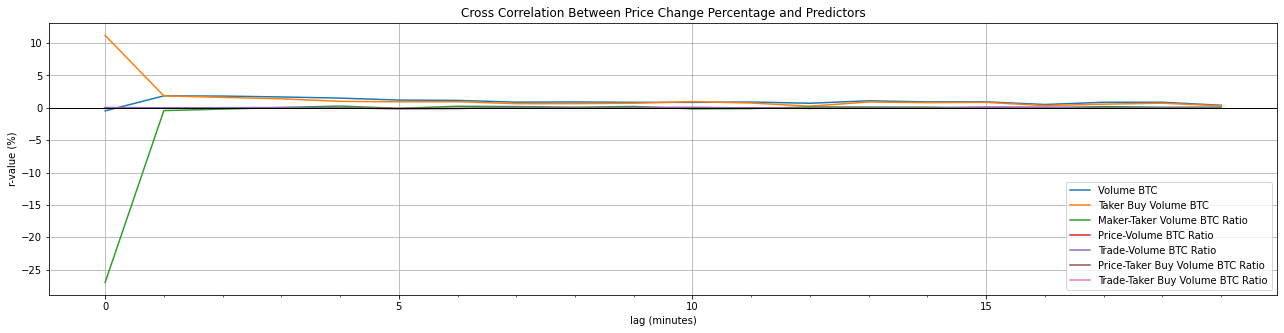

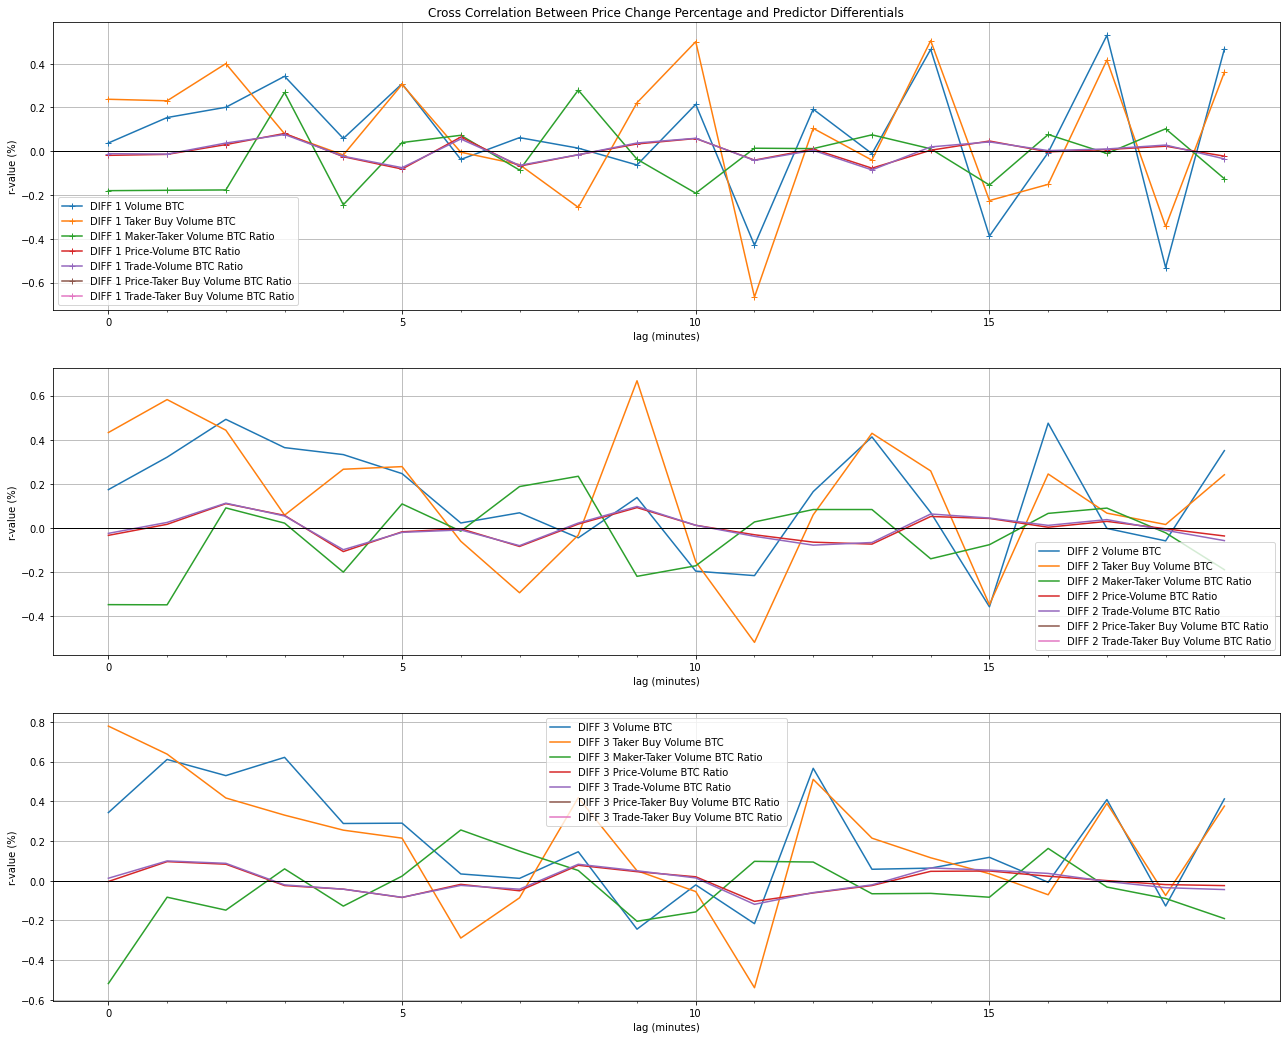

In [28]:
plt.figure(figsize=(22,5));
plt.plot(lagged_correlation[[col for col in lagged_correlation.columns if ('Volume ' + quote_asset in col or 'Ratio' in col) and ('DIFF ' not in col and 'LAG ' not in col)]]);
plt.legend(lagged_correlation[[col for col in lagged_correlation.columns if ('Volume ' + quote_asset in col or 'Ratio' in col) and ('DIFF ' not in col and 'LAG ' not in col)]].columns);
plt.axhline(y=0, c='k', lw=1);
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(5))
plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(1))
plt.title('Cross Correlation Between Price Change Percentage and Predictors');
plt.ylabel('r-value (%)');
plt.xlabel('lag (minutes)');
plt.grid('both')


fig, axs = plt.subplots(nrows=3,figsize=(22,6*3))
axs[0].plot(lagged_correlation[[col for col in lagged_correlation.columns if ('Volume ' + quote_asset in col or 'Ratio' in col) and ('DIFF 1' in col)]],marker='+');
axs[0].legend(lagged_correlation[[col for col in lagged_correlation.columns if ('Volume ' + quote_asset in col or 'Ratio' in col) and ('DIFF 1' in col)]]);

axs[1].plot(lagged_correlation[[col for col in lagged_correlation.columns if ('Volume ' + quote_asset in col or 'Ratio' in col) and ('DIFF 2' in col)]]);
axs[1].legend(lagged_correlation[[col for col in lagged_correlation.columns if ('Volume ' + quote_asset in col or 'Ratio' in col) and ('DIFF 2' in col)]]);

axs[2].plot(lagged_correlation[[col for col in lagged_correlation.columns if ('Volume ' + quote_asset in col or 'Ratio' in col) and ('DIFF 3' in col)]]);
axs[2].legend(lagged_correlation[[col for col in lagged_correlation.columns if ('Volume ' + quote_asset in col or 'Ratio' in col) and ('DIFF 3' in col)]]);



axs[0].set_title('Cross Correlation Between Price Change Percentage and Predictor Differentials');
for x in axs: x.set_ylabel('r-value (%)');
for x in axs: x.set_xlabel('lag (minutes)');
for x in axs: x.set_xticks(range(0,lagged_correlation.shape[0]));
for x in axs: x.grid('both');
for x in axs: x.axhline(y=0, c='k', lw=1);
for x in axs: x.xaxis.set_major_locator(plt.MultipleLocator(5));
for x in axs: x.xaxis.set_minor_locator(plt.MultipleLocator(1));

Maker-Taker Ratio Kurtosis = -0.3246779


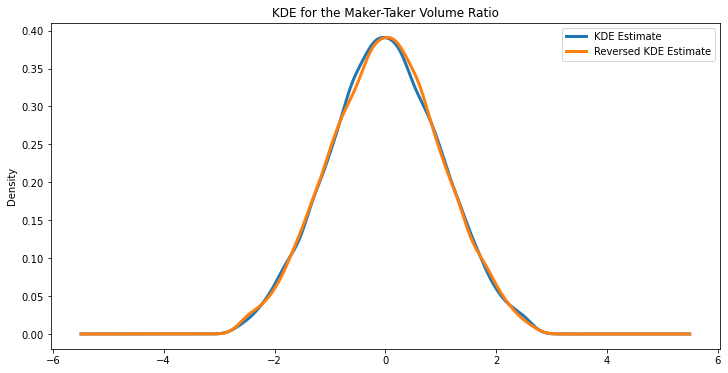

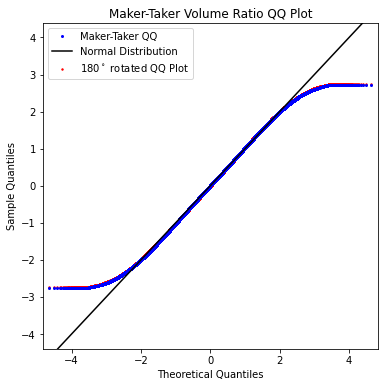

In [29]:
InteractiveShell.ast_node_interactivity = "last_expr"
# check normality assumption in Maker-Taker Volume Ratio

# plot KDE, and flip for visual symmetry check
mtvol_sample = complete_data.sample(16000)['Maker-Taker Volume ' + quote_asset + ' Ratio'];

mtvol_desc_stats = mtvol_sample.describe();
mtvol_sample_normalized = (mtvol_sample - mtvol_desc_stats['mean']) / mtvol_desc_stats['std'];

# plot QQ, and flip 180 deg for visual symmetry check
ax = plt.figure(figsize=(12,6));
mtvol_sample_normalized.plot.kde(lw=3,label='KDE Estimate');

(-1.0*mtvol_sample_normalized).plot.kde(lw=3,label='Reversed KDE Estimate');
plt.legend();

plt.title('KDE for the Maker-Taker Volume Ratio');

sm.qqplot(complete_data['Maker-Taker Volume ' + quote_asset + ' Ratio'],
fit=True,markersize=2,label='Maker-Taker QQ').set_size_inches((6,6));

ax = plt.gca();
ax.scatter(-ax.lines[0].get_xdata(),-ax.lines[0].get_ydata(),s=2,c='r',label='$180^\circ$ rotated QQ Plot');
ax.axline([-4,-4],[4,4],c='k',label='Normal Distribution');

plt.title('Maker-Taker Volume Ratio QQ Plot');
plt.legend();

print('Maker-Taker Ratio Kurtosis = ' + str(complete_data['Maker-Taker Volume ' + quote_asset + ' Ratio'].kurtosis()));



# distribution is appproximately normal with slight left-skew and slight negative kurtosis


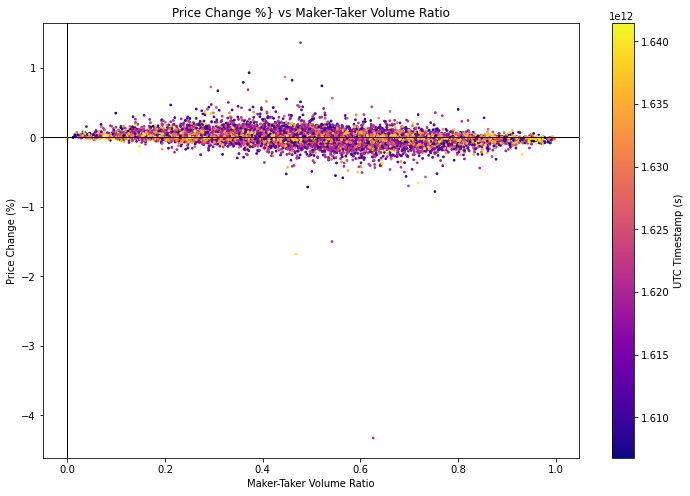

In [30]:
# Inspect the 
plot_sample = complete_data.sample(16000);


plt.figure(figsize=(12,8));
# ax = plt.axes(projection='3d')
plt.axhline(0,color='black',lw=1);
plt.axvline(0,color='black',lw=1);

x = (plot_sample['Maker-Taker Volume ' + quote_asset + ' Ratio']).to_numpy()

plt.scatter(x,plot_sample['Percent Change ' + quote_asset],
# c=plot_sample.index, ###
c=plot_sample.index,
s=3,alpha=1,cmap='plasma');
plt.colorbar().set_label('UTC Timestamp (s)');
plt.xlabel('Maker-Taker Volume Ratio');
plt.ylabel('Price Change (%)');
plt.title('Price Change %}' + ' vs ' + 'Maker-Taker Volume Ratio');

#ax=plt.gca();
#plt.xlim([0,1])
#plt.ylim([-2,2])

#ax.yaxis.set_ticks(np.arange(-2,2.2,0.2));

# plt.yscale('symlog',linthresh = 0.001);
# plt.xscale('symlog',linthresh = 0.001);

In [31]:
# # Plot all price difference - x pairs
# plot_sample = complete_data.sample(16000);

# for x in ( x for x in plot_sample.columns if 'Ratio' in x ):
#     plt.figure(figsize=(6,6));
#     # ax = plt.axes(projection='3d')
#     plt.axhline(0,color='black',lw=1);
#     plt.axvline(0,color='black',lw=1);

#     plt.scatter(
#         plot_sample[x],
#         plot_sample['Difference ' + quote_asset],
#         # c=plot_sample.index, ###
#         c=plot_sample.index,cmap='cool',
#         s=3,alpha=1);

#     # plt.colorbar();
#     plt.xlabel(x);
#     plt.ylabel('Price Difference %');
#     plt.title(x + ' vs ' + 'Price Difference %');
    

    #ax=plt.gca();
    #plt.xlim([0,1])
    #plt.ylim([-2,2])

    #ax.yaxis.set_ticks(np.arange(-2,2.2,0.2));

    # plt.yscale('symlog',linthresh = 0.001);
    # plt.xscale('symlog',linthresh = 0.001);
    # plt.yscale('logit');
